In [1]:
# Clean old installs
!pip uninstall -y torch torchvision torchaudio transformers accelerate peft trl datasets bitsandbytes triton

# Install compatible packages
!pip install --upgrade pip
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install unsloth transformers datasets accelerate peft trl bitsandbytes ipywidgets


Found existing installation: torch 2.5.0a0+e000cf0ad9.nv24.10
Uninstalling torch-2.5.0a0+e000cf0ad9.nv24.10:
  Successfully uninstalled torch-2.5.0a0+e000cf0ad9.nv24.10
Found existing installation: torchvision 0.20.0a0
Uninstalling torchvision-0.20.0a0:
  Successfully uninstalled torchvision-0.20.0a0
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2
Looking in indexes: https://download.pytorch.org/whl/cu121, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.4/780.4 MB 8.6 MB/s eta 0:00:0000:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 8.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 8.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7

In [1]:
import torch
from datasets import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: If you want to finetune Gemma 2, upgrade flash-attn to version 2.6.3 or higher!
Newer versions support faster and less memory usage kernels for Gemma 2's attention softcapping!
To update flash-attn, do the below:

pip install --no-deps --upgrade "flash-attn>=2.6.3"
🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
# Load CSV
df = pd.read_csv("medquad_tamil.csv").dropna()

# Create 'text' column for training, but keep original columns too
df["text"] = "### கேள்வி:\n" + df["question_tamil"] + "\n\n### பதில்:\n" + df["answer_tamil"]

# Split, keeping all columns
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Convert to HF dataset
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))



In [4]:
model_id = "abhinand/tamil-llama-7b-instruct-v0.2"
max_seq_length = 512

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_id,
    max_seq_length=max_seq_length,
    dtype=torch.float16,          # A100 supports fp16
    load_in_4bit=True,            # Load model in 4-bit to save memory
)

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


==((====))==  Unsloth 2025.6.2: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.394 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

pytorch_model-00001-of-00003.bin:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

pytorch_model-00002-of-00003.bin:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

pytorch_model-00003-of-00003.bin:   0%|          | 0.00/3.83G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Unsloth: Will load abhinand/tamil-llama-7b-instruct-v0.2 as a legacy tokenizer.


abhinand/tamil-llama-7b-instruct-v0.2 does not have a padding token! Will use pad_token = <unk>.


In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r=64,
    lora_alpha=32,
    lora_dropout=0.0,     # ✅ Fastest patching with dropout=0.0
    bias="none",          # ✅ Standard setting
    # Do NOT include task_type manually
)


In [ ]:
training_args=TrainingArguments(
        per_device_train_batch_size=8,
        gradient_accumulation_steps=4,
        warmup_ratio=0.1,
        num_train_epochs=4,  # ✅ Specify number of epochs here
        learning_rate=2e-4,
        fp16=True,
        bf16=False,
        logging_steps=10,
        optim="adamw_8bit",
        weight_decay=0.05,
        lr_scheduler_type="cosine",
        seed=42,
        output_dir="outputs",
    )

In [12]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,              # 🚫 No validation set used here
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    args=training_args,
)


Unsloth: Tokenizing ["text"]:   0%|          | 0/14766 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"]:   0%|          | 0/1641 [00:00<?, ? examples/s]

In [13]:

trainer.train()


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 14,766 | Num Epochs = 4 | Total steps = 1,848
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 4 x 1) = 32
 "-____-"     Trainable parameters = 159,907,840/7,000,000,000 (2.28% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,3.809000
20,3.642200
30,3.376000
40,3.133900
50,2.933700
60,2.737300
70,2.586400
80,2.358600
90,2.362100
100,2.318100


TrainOutput(global_step=1848, training_loss=1.5045444010656117, metrics={'train_runtime': 2701.5656, 'train_samples_per_second': 21.863, 'train_steps_per_second': 0.684, 'total_flos': 2.6839096389648384e+17, 'train_loss': 1.5045444010656117})

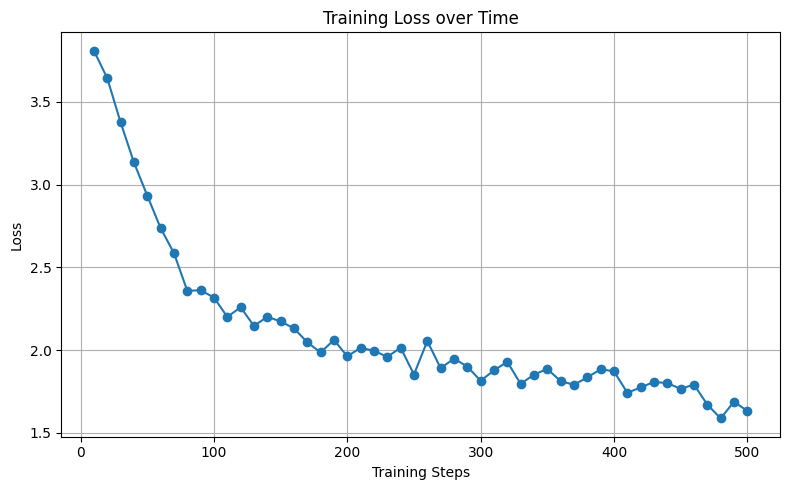

In [1]:
import json
import matplotlib.pyplot as plt

# Replace with the path to your trainer_state.json
state_path = "outputs/checkpoint-500/trainer_state.json"

with open(state_path) as f:
    state = json.load(f)

steps = []
losses = []

for log in state["log_history"]:
    if "loss" in log:
        steps.append(log["step"])
        losses.append(log["loss"])

plt.figure(figsize=(8, 5))
plt.plot(steps, losses, marker='o')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
trainer.model.save_pretrained("finetuned_tamil_llm")
tokenizer.save_pretrained("finetuned_tamil_llm")

('finetuned_tamil_llm/tokenizer_config.json',
 'finetuned_tamil_llm/special_tokens_map.json',
 'finetuned_tamil_llm/chat_template.jinja',
 'finetuned_tamil_llm/tokenizer.model',
 'finetuned_tamil_llm/added_tokens.json')

In [4]:
!pip install bert-score transformers


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
from unsloth import FastLanguageModel
from transformers import AutoTokenizer
import torch
from tqdm import tqdm

# ✅ Load model and tokenizer
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="finetuned_tamil_llm",  # Local folder
    max_seq_length=512,
    dtype=torch.float16,
    load_in_4bit=True,
    device_map="auto",  # This allows offloading to CPU  # Allow CPU offload for incompatible modules
)


tokenizer.pad_token = tokenizer.eos_token  # Ensure padding works
model.eval()

generated_answers = []
reference_answers = []

for item in tqdm(test_dataset):
    question = item["question_tamil"]
    reference = item["answer_tamil"]

    # ✅ Use clear and complete prompt format
    prompt = f"""### கேள்வி:
{question}

### பதில்:"""

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=512,
            do_sample=False,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
        )

    # ✅ Decode output safely
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

    # ✅ Extract only the answer part
    if "### பதில்:" in decoded:
        answer = decoded.split("### பதில்:")[-1].strip()
    else:
        # fallback in case delimiter is missing
        answer = decoded.replace(prompt, "").strip()

    if not answer:
        print(f"⚠️ No answer for question: {question}")
        print("🔍 Full decoded output:\n", decoded)
    else:
        print(f"✅ Answer generated for: {question}")

    generated_answers.append(answer)
    reference_answers.append(reference)


==((====))==  Unsloth 2025.6.2: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.394 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

pytorch_model-00002-of-00003.bin:  40%|####      | 3.33G/8.28G [00:00<?, ?B/s]

pytorch_model-00001-of-00003.bin:  39%|###9      | 3.21G/8.20G [00:00<?, ?B/s]

pytorch_model-00003-of-00003.bin:  46%|####6     | 3.31G/7.14G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Unsloth: Will load abhinand/tamil-llama-7b-instruct-v0.2 as a legacy tokenizer.


abhinand/tamil-llama-7b-instruct-v0.2 does not have a padding token! Will use pad_token = <unk>.


Unsloth 2025.6.2 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.
  0%|                                                                                                                                                                     | 1/1641 [00:04<2:03:45,  4.53s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இளைஞர் ஹண்டிங்டன் நோய்த்தொற்று என்ன?


  0%|▏                                                                                                                                                                      | 2/1641 [00:05<59:58,  2.20s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பெர்ரி நோய்க்கான சிகிச்சைகள் என்ன?


  0%|▎                                                                                                                                                                    | 3/1641 [00:09<1:27:59,  3.22s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குரோமோசோமை 17q நீக்கத்தின் அறிகுறிகள் என்ன?


  0%|▍                                                                                                                                                                    | 4/1641 [00:12<1:30:30,  3.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டிரான்ஸ்ட்யர்டின் அமிலலோயடைஸிற்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


  0%|▌                                                                                                                                                                    | 5/1641 [00:16<1:29:43,  3.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சமநிலைப் பிரச்சினைகளைத் தடுக்க எப்படி?


  0%|▌                                                                                                                                                                    | 6/1641 [00:19<1:29:22,  3.28s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) சினூசிட்டிஸ் என்ன?


  0%|▋                                                                                                                                                                    | 7/1641 [00:21<1:20:12,  2.95s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹைப்பரகலெமிக் கால முடக்கநிலைகளின் அறிகுறிகள் என்ன?


  0%|▊                                                                                                                                                                    | 8/1641 [00:25<1:27:43,  3.22s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Acrodermatitis enteropathica என்பது என்ன?


  1%|▉                                                                                                                                                                    | 9/1641 [00:26<1:05:24,  2.40s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: cytochrome P450 ஆக்சைடோரெக்டேகாஸ் பற்றாக்குறை எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


  1%|▉                                                                                                                                                                   | 10/1641 [00:28<1:04:48,  2.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மோர்கியோ தொற்று நோயின் அறிகுறிகள் என்ன?


  1%|█                                                                                                                                                                   | 11/1641 [00:31<1:10:54,  2.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மருத்துவம் மற்றும் தொடர்ச்சியான கவனிப்பு என்பது என்ன?


  1%|█▏                                                                                                                                                                  | 12/1641 [00:35<1:18:03,  2.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: புறம்போக்குத் தொற்றுக்கு என்ன காரணம்?


  1%|█▎                                                                                                                                                                  | 13/1641 [00:36<1:03:56,  2.36s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் நோய்த்தொற்று நோயால் பாதிக்கப்படுகின்றனர்?


  1%|█▍                                                                                                                                                                    | 14/1641 [00:37<56:03,  2.07s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹெமோக்ரோமட் நோய்க்கான காரணம் என்ன?


  1%|█▌                                                                                                                                                                    | 15/1641 [00:39<55:40,  2.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கர்ரி ஜோன்ஸ் நோயின் அறிகுறிகள் என்ன?


  1%|█▌                                                                                                                                                                    | 16/1641 [00:41<53:23,  1.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃபேசில் எக்ஸ் நோய்த்தொற்று மரபாகின்றதா?


  1%|█▋                                                                                                                                                                    | 17/1641 [00:43<55:01,  2.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: D-glycericacidemia அறிகுறிகள் என்ன?


  1%|█▊                                                                                                                                                                    | 18/1641 [00:44<45:30,  1.68s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஓஸ்டியோஜெனிசஸ் இன்ஸ்பெக்டாவின் அறிகுறிகள் என்ன?


  1%|█▉                                                                                                                                                                    | 19/1641 [00:47<58:23,  2.16s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: 16 - ன் கூட்டு ஆக்சிடேட் போஸ்போரிலஸ் பற்றாக்குறையின் அறிகுறிகள் என்ன?


  1%|██                                                                                                                                                                    | 20/1641 [00:49<56:39,  2.10s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிஸ்டிக் சிறுநீரக நோய்த் தொற்று (Cystic kidney disease) என்பது என்ன?


  1%|██                                                                                                                                                                    | 21/1641 [00:52<58:31,  2.17s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கம்பு (பழங்குடியினர்) நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


  1%|██▏                                                                                                                                                                 | 22/1641 [00:54<1:01:49,  2.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சர்க்கரை நோய்க்கான பிரச்சினைகளைத் தடுக்க என்ன செய்ய வேண்டும்?


  1%|██▎                                                                                                                                                                 | 23/1641 [00:57<1:09:58,  2.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கவலைக்குட்பட்டவர்களுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


  1%|██▍                                                                                                                                                                 | 24/1641 [01:02<1:26:29,  3.21s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (ஆ) Y chromosome infertility என்பது என்ன?


  2%|██▍                                                                                                                                                                 | 25/1641 [01:04<1:16:29,  2.84s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுபான்மையினர் மூளை மற்றும் முதுகு நோய்க்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொண்டு வருகிறது?


  2%|██▌                                                                                                                                                                 | 26/1641 [01:07<1:19:08,  2.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அ) ஏஎல்ஜி6 கர்ப்பிணி காய்ச்சல் குறைபாடு என்ன?


  2%|██▋                                                                                                                                                                 | 27/1641 [01:11<1:24:56,  3.16s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அல்பேர்ஸ் - ஹட்டெனலோச்சர் நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


  2%|██▊                                                                                                                                                                 | 28/1641 [01:15<1:31:17,  3.40s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: """""""""""உணர்ச்சிகள்"""என்ன?"


  2%|██▉                                                                                                                                                                 | 29/1641 [01:19<1:36:17,  3.58s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வயதான மத்திய நரம்பு நோய்த்தொற்றுக்கு ஆபத்து யார்?


  2%|██▉                                                                                                                                                                 | 30/1641 [01:21<1:24:05,  3.13s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃபெப்ரில்லா தொற்று தொடர்பான எபிஎல்ப்சிஸ் நோயின் அறிகுறிகள் என்ன?


  2%|███                                                                                                                                                                 | 31/1641 [01:23<1:17:10,  2.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லங்கு புற்றுநோய்க்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகின்றன?


  2%|███▏                                                                                                                                                                | 32/1641 [01:27<1:20:57,  3.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) பரக்ஸிஸ்மல் நுரையீரல் ஹெமோகோளோபின்யரியா என்ன?


  2%|███▎                                                                                                                                                                | 33/1641 [01:29<1:17:55,  2.91s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லாரோன் நோய்த்தொற்று என்ன?


  2%|███▍                                                                                                                                                                | 34/1641 [01:32<1:15:37,  2.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: """"""""""அது என்ன?"


  2%|███▍                                                                                                                                                                | 35/1641 [01:36<1:22:36,  3.09s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) டைஹைட்ரோபிரைமடின் டெஹைட்ரஜனேசின் பற்றாக்குறை என்ன?


  2%|███▌                                                                                                                                                                | 36/1641 [01:38<1:13:21,  2.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹெமோபீலியாவின் அறிகுறிகள் என்ன?


  2%|███▋                                                                                                                                                                | 37/1641 [01:40<1:07:14,  2.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இதயக் குறைபாட்டின் அறிகுறிகள் என்ன?


  2%|███▊                                                                                                                                                                | 38/1641 [01:43<1:12:56,  2.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சைக்கிள் வீணாக்கும் நோய்த்தொற்று என்ன?


  2%|███▉                                                                                                                                                                | 39/1641 [01:45<1:05:42,  2.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆன்லைன் அறிகுறிகள் என்ன?


  2%|███▉                                                                                                                                                                | 40/1641 [01:47<1:02:48,  2.35s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹால்ட் - ஓரம் நோய்த்தொற்றுக்கு மரபாகமா?


  2%|████                                                                                                                                                                | 41/1641 [01:52<1:22:30,  3.09s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தானியங்கி மேலாதிக்கத்தனமான Craniometaphyseal displasia, என்ன சிகிச்சைகள் உள்ளன?


  3%|████▏                                                                                                                                                               | 42/1641 [01:55<1:22:00,  3.08s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சப்போ தொற்றுக்கு என்ன சிகிச்சைகள்?


  3%|████▎                                                                                                                                                               | 43/1641 [01:55<1:01:12,  2.30s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மலோனில்-கோஏ டெகர்பாக்சிலாஸ் பற்றாக்குறையால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


  3%|████▍                                                                                                                                                                 | 44/1641 [01:57<57:03,  2.14s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வெள்ளம் என்பது என்ன?


  3%|████▍                                                                                                                                                               | 45/1641 [02:01<1:10:07,  2.64s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) பெம்பிரிஸ் வுல்கரிஸ் என்ன?


  3%|████▌                                                                                                                                                               | 46/1641 [02:03<1:08:06,  2.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Hypothyroidism க்கு என்ன காரணம்?


  3%|████▋                                                                                                                                                               | 47/1641 [02:05<1:03:57,  2.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹாண்டிங்டன் நோயின் அறிகுறிகள் என்ன?


  3%|████▊                                                                                                                                                               | 48/1641 [02:08<1:05:29,  2.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கலை நோய்த்தொற்றுக்கு என்ன காரணம்?


  3%|████▉                                                                                                                                                               | 49/1641 [02:10<1:05:33,  2.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தர்மம் மற்றும் தாமிக் கார்சினோமாவின் அறிகுறிகள் என்ன?


  3%|████▉                                                                                                                                                               | 50/1641 [02:13<1:10:55,  2.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மெக்கோயுன் அல்பிரைட் தொற்றுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


  3%|█████                                                                                                                                                               | 51/1641 [02:16<1:12:46,  2.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முற்போக்கான எஸ்கோலி நோய்த்தொற்றுடன் கிடைமட்ட எரிவாயுப் பாலசி என்னவாகும்?


  3%|█████▏                                                                                                                                                              | 52/1641 [02:18<1:05:03,  2.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மிட்டோகண்டரியல் மூலக்கூறு புரோட்டீன் பற்றாக்குறை இதற்குக் காரணம்தானா?


  3%|█████▎                                                                                                                                                              | 53/1641 [02:20<1:02:54,  2.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நீண்டகால QT நோய்த்தொற்று நோயின் அறிகுறிகள் என்ன?


  3%|█████▍                                                                                                                                                              | 54/1641 [02:22<1:00:54,  2.30s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுநீரகம் தோல்விக்கு என்ன சிகிச்சைகள்: உங்களுக்கு சரியான சிகிச்சையை தேர்ந்தெடுப்பது?


  3%|█████▍                                                                                                                                                              | 55/1641 [02:26<1:11:46,  2.72s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வெட்டு லாக்சா தொடர்பான மரபியல் மாற்றங்கள் என்ன?


  3%|█████▌                                                                                                                                                              | 56/1641 [02:28<1:02:46,  2.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கோஹேன் தொற்றுநோயை எப்படிக் கண்டறிவது?


  3%|█████▋                                                                                                                                                              | 57/1641 [02:33<1:25:57,  3.26s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அத்தியாவசியமான பெல்ல்பாரோசாமை நோக்கிய நோக்கம் என்ன?


  4%|█████▊                                                                                                                                                              | 58/1641 [02:35<1:19:46,  3.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்டூவே விட்யெமன் நோயின் அறிகுறிகள் என்ன?


  4%|█████▉                                                                                                                                                              | 59/1641 [02:58<3:54:10,  8.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: I cell நோயின் அறிகுறிகள் என்ன?


  4%|█████▉                                                                                                                                                              | 60/1641 [02:58<2:48:16,  6.39s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கில்ஸ்பி நோய்த்தொற்று எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


  4%|██████                                                                                                                                                              | 61/1641 [03:02<2:27:00,  5.58s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எல்சாட் பற்றாக்குறை என்ன?


  4%|██████▏                                                                                                                                                             | 62/1641 [03:06<2:10:33,  4.96s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆட்டோமன் அட்ரோபிக் கெஸ்டரிட்டை எப்படிக் கண்டறிவது?


  4%|██████▎                                                                                                                                                             | 63/1641 [03:09<1:59:37,  4.55s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: WaterhouseFriderichsen நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


  4%|██████▍                                                                                                                                                             | 64/1641 [03:12<1:45:58,  4.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எலெர்ஸ் - டான்லோஸ் நோய்த்தொற்று, இரத்தக்களரி வகை ஆகியவற்றின் வாரிசுவா?


  4%|██████▍                                                                                                                                                             | 65/1641 [03:34<4:10:30,  9.54s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) பன்னோக்கு எபிபீசல் நோய்த்தொற்று என்ன?


  4%|██████▌                                                                                                                                                             | 66/1641 [03:37<3:12:43,  7.34s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃபெப்ரீல் கையெழுத்துக்களுக்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகின்றன?


  4%|██████▋                                                                                                                                                             | 67/1641 [03:39<2:32:18,  5.81s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அடிப்படை நுரையீரல் நோயைக் கண்டறிவது எப்படி?


  4%|██████▊                                                                                                                                                             | 68/1641 [03:41<2:03:57,  4.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வேயர்ஸ் அக்கிரம நோயின் அறிகுறிகள் என்ன?


  4%|██████▉                                                                                                                                                             | 69/1641 [03:42<1:33:10,  3.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஒழுங்கு மாற்றுப் பற்றாக்குறையினால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


  4%|██████▉                                                                                                                                                             | 70/1641 [03:44<1:19:09,  3.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இது சேர்க்கப்பட்ட மெத்திலமலேனிக் அமிலத்தின் மரபாகும்?


  4%|███████                                                                                                                                                             | 71/1641 [03:46<1:16:48,  2.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிஸ்டிக் ஃபிப்ரோசாவை எப்படிக் கண்டறிவது?


  4%|███████▏                                                                                                                                                            | 72/1641 [03:50<1:20:40,  3.09s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) செபாலிக் குழப்பம் என்ன?


  4%|███████▎                                                                                                                                                            | 73/1641 [03:53<1:21:26,  3.12s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முன்கூட்டிய காய்ச்சல் மற்றும் முன்கூட்டிய காய்ச்சல் ஆகியவற்றின் அறிகுறிகள் என்ன?


  5%|███████▍                                                                                                                                                            | 74/1641 [03:56<1:22:30,  3.16s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மசோரியக் arthritis உடன் தொடர்புடைய மரபியல் மாற்றங்கள் என்ன?


  5%|███████▍                                                                                                                                                            | 75/1641 [03:59<1:17:18,  2.96s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Osteochondritis dissecans - ன் அறிகுறிகள் என்ன?


  5%|███████▌                                                                                                                                                            | 76/1641 [04:02<1:20:22,  3.08s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்டாக்ராவுக்கு என்ன காரணம்?


  5%|███████▋                                                                                                                                                            | 77/1641 [04:08<1:39:20,  3.81s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: செவிலியர் இல்லங்கள் குறித்த தகவல்கள் உங்களிடம் உள்ளதா


  5%|███████▊                                                                                                                                                            | 78/1641 [04:08<1:14:52,  2.87s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் பெட்டா குளோபின் வகை methemoglobinemia மூலம் பாதிக்கப்படுகின்றனர்?


  5%|███████▉                                                                                                                                                            | 79/1641 [04:10<1:08:29,  2.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கவுச்சர் நோயின் அறிகுறிகள் என்ன?


  5%|███████▉                                                                                                                                                            | 80/1641 [04:14<1:17:01,  2.96s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹிர்ஷ்வுங் நோய்த்தொற்று என்னவாகும்?


  5%|████████                                                                                                                                                            | 81/1641 [04:18<1:22:01,  3.15s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இதயப் பிளாக் காரணமா?


  5%|████████▏                                                                                                                                                           | 82/1641 [04:22<1:26:31,  3.33s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முற்போக்கான வெளிப்புற கண் நோய்த்தொற்று என்னவாகும்?


  5%|████████▎                                                                                                                                                           | 83/1641 [04:24<1:22:31,  3.18s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சர்க்கரை நோய்த்தொற்றுக்கு என்ன காரணம்?


  5%|████████▍                                                                                                                                                           | 84/1641 [04:28<1:23:45,  3.23s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எபிட்ரம்போலீஸ் புல்லோசாவில் ஏற்படும் மரபணு மாற்றங்கள் என்ன?


  5%|████████▍                                                                                                                                                           | 85/1641 [04:30<1:12:46,  2.81s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: காய்ச்சல் புற்றுநோய்க்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகின்றன?


  5%|████████▌                                                                                                                                                           | 86/1641 [04:33<1:14:53,  2.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பலவகை மோட்டார் நியுரோபதிக்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொண்டு வருகிறது?


  5%|████████▋                                                                                                                                                           | 87/1641 [04:35<1:14:08,  2.86s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: """""சுயநலம்""""""""""""""""இது சுயநலம்"""இது சுயநலம்"""இது சுயநலம்""இது சுயநலம்"இது சுயநலம்"இது சுயநலம்"இது சுயநலம்"இது சுயநலம்"இது சுயநலம்"இது சுயநலம்"இது சுயநலம்"இது சுயநலம்"இது சுயநலம்"இது சுயநலம்


  5%|████████▊                                                                                                                                                           | 88/1641 [04:37<1:02:39,  2.42s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃபான்போனியின் மறுசுழற்சி நோயின் அறிகுறிகள் என்ன?


  5%|████████▉                                                                                                                                                           | 89/1641 [04:39<1:04:41,  2.50s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வயது தொடர்பான மனச்சோழ்வு என்பது என்ன?


  5%|█████████                                                                                                                                                             | 90/1641 [04:41<57:03,  2.21s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கோலின்ஸ் நோய்த்தொற்றுக்கு அறிகுறியாக இருக்கிறதா?


  6%|█████████▏                                                                                                                                                            | 91/1641 [04:43<53:43,  2.08s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சாந்திக்கு என்ன பிரச்சனைகள்?


  6%|█████████▎                                                                                                                                                            | 92/1641 [04:46<59:47,  2.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) சிரியோமா என்ன?


  6%|█████████▎                                                                                                                                                          | 93/1641 [04:50<1:16:47,  2.98s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: myotonia congenita க்கு என்ன சிகிச்சைகள் உள்ளன?


  6%|█████████▍                                                                                                                                                          | 94/1641 [04:54<1:22:18,  3.19s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அப்போஸ்தலிக்க அட்டாக்சியா தொடர்பான மரபணு மாற்றங்கள் என்ன?


  6%|█████████▍                                                                                                                                                          | 95/1641 [04:55<1:06:38,  2.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்டாரஜ் வேபர் நோய்க்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகின்றன?


  6%|█████████▌                                                                                                                                                          | 96/1641 [05:17<3:38:46,  8.50s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) Rh பொருத்தமின்மை என்ன?


  6%|█████████▋                                                                                                                                                          | 97/1641 [05:20<2:50:29,  6.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூலிகை புற்றுநோயைக் கண்டறிதல்


  6%|█████████▊                                                                                                                                                          | 98/1641 [05:22<2:17:03,  5.33s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: க்ளவுகோமாவுக்கு என்ன சிகிச்சைகள்?


  6%|█████████▉                                                                                                                                                          | 99/1641 [05:24<1:53:16,  4.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஓஸ்டியோபிரோஸ் 7 - ன் அறிகுறிகள் என்ன?


  6%|█████████▉                                                                                                                                                         | 100/1641 [05:27<1:44:40,  4.08s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பல மையமான ஓட்டோலிசிஸ், நெடுஞ்சாலை, தொற்று நோய் போன்ற மரபணு மாற்றங்கள் என்னவாகும்?


  6%|██████████                                                                                                                                                         | 101/1641 [05:31<1:36:58,  3.78s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அல்ட்சைமர் நோய்த்தொற்று என்ன?


  6%|██████████▏                                                                                                                                                        | 102/1641 [05:34<1:32:03,  3.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டோஹு நோய்க்கான சிகிச்சைகள் என்ன?


  6%|██████████▏                                                                                                                                                        | 103/1641 [05:35<1:13:04,  2.85s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சுய நோய்த்தொற்று நோயால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


  6%|██████████▎                                                                                                                                                        | 104/1641 [05:37<1:04:49,  2.53s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மயோசைன் சேமிப்பு மயோபதி பாரம்பரியமா?


  6%|██████████▌                                                                                                                                                          | 105/1641 [05:37<50:59,  1.99s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: WAGR நோய்த்தொற்று எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


  6%|██████████▌                                                                                                                                                        | 106/1641 [05:41<1:07:23,  2.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முக்கோபலிசாக்கரடோயிஸ் வகை I என்பது என்ன?


  7%|██████████▋                                                                                                                                                        | 107/1641 [05:45<1:12:49,  2.85s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வாய்க்கு என்ன காரணம்?


  7%|██████████▋                                                                                                                                                        | 108/1641 [05:48<1:12:54,  2.85s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குளுக்கோஸ் கலாட்டோஸ் மாசோர்போஷன் தொடர்பான மரபணு மாற்றங்கள் என்ன?


  7%|██████████▊                                                                                                                                                        | 109/1641 [05:50<1:08:19,  2.68s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லம்பேர்ட் ஈடனின் மையக்கருத்து நோயின் அறிகுறிகள் என்ன?


  7%|██████████▉                                                                                                                                                        | 110/1641 [05:53<1:13:26,  2.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிதரோபளஸ்டிக் அனீமியா பெரிடோக்சின் மறுபரிசீலனைக்கான சிகிச்சைகள் என்ன?


  7%|███████████                                                                                                                                                        | 111/1641 [05:56<1:14:58,  2.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கிராப் நோய்க்கு என்ன சிகிச்சைகள்?


  7%|███████████                                                                                                                                                        | 112/1641 [05:59<1:14:22,  2.92s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மெக்கோயுன் அல்பிரைட் நோய்த்தொற்று என்ன?


  7%|███████████▏                                                                                                                                                       | 113/1641 [06:01<1:07:18,  2.64s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹைப்பிராய்டுவின் அறிகுறிகள் என்ன?


  7%|███████████▎                                                                                                                                                       | 114/1641 [06:04<1:08:38,  2.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஐந்து சிகிச்சை அறிகுறிகள் என்ன?


  7%|███████████▍                                                                                                                                                       | 115/1641 [06:07<1:09:33,  2.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிளீபாரோபிம் நோய்த்தொற்று, பூட்டோசிஸ் மற்றும் தொற்று நோய்த்தொற்று ஆகியவை இரண்டாம் வகை திருப்புமுனையாக உள்ளனவா?


  7%|███████████▌                                                                                                                                                       | 116/1641 [06:09<1:03:34,  2.50s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எக்ஸ்-இணைந்த நைகோஹிட்ரோட்டிக் எக்டோடேர்மல் குழப்பத்தின் அறிகுறிகள் என்ன?


  7%|███████████▊                                                                                                                                                         | 117/1641 [06:10<51:04,  2.01s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மைஹர் நோய்த்தொற்றுக்கு மரபாகமா?


  7%|███████████▊                                                                                                                                                         | 118/1641 [06:11<42:19,  1.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: செர்பெலார் ஐபோக்ளசியாவின் நோக்கம் என்ன?


  7%|███████████▉                                                                                                                                                         | 119/1641 [06:14<53:04,  2.09s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அல்ட்சைமர் நோய்த்தொற்று என்ன?


  7%|████████████                                                                                                                                                         | 120/1641 [06:15<49:41,  1.96s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: 48 - ற்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


  7%|████████████▏                                                                                                                                                        | 121/1641 [06:19<59:40,  2.36s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மாற்றுத் திறனாளிகள் என்பது என்ன?


  7%|████████████▎                                                                                                                                                        | 122/1641 [06:19<45:58,  1.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கோவிட் தொற்று காரணமாக எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


  7%|████████████▎                                                                                                                                                        | 123/1641 [06:21<45:36,  1.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தெத்ரா அமீலியா நோய்த்தொற்றுக்கு மரபாகமா?


  8%|████████████▍                                                                                                                                                        | 124/1641 [06:24<57:12,  2.26s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எஸ்டியோடிஸ் பிளாஸ்டிக் முதன்மை இரண்டாம் வகை மார்பகவாதத்தோடு தொடர்புடைய மரபணு மாற்றங்கள் என்ன?


  8%|████████████▌                                                                                                                                                        | 125/1641 [06:25<43:56,  1.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் ஃபைப்ரஹோண்ட்ரஜனேசஸினால் பாதிக்கப்படுகின்றனர்?


  8%|████████████▌                                                                                                                                                      | 126/1641 [06:29<1:04:21,  2.55s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கிரானியோபாசல் நுண்ணுயிர் சிகிச்சைக்கான சிகிச்சைகள் என்ன?


  8%|████████████▊                                                                                                                                                        | 127/1641 [06:31<54:50,  2.17s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் பிள்ளையால் பாதிக்கப்பட்டுள்ளார்கள்?


  8%|████████████▊                                                                                                                                                        | 128/1641 [06:33<53:45,  2.13s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அலோபியா மொத்தலிஸ் அறிகுறிகள் என்ன?


  8%|████████████▉                                                                                                                                                        | 129/1641 [06:34<51:03,  2.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வலிக்கு மரபணு விரக்தி மரபணுதானதா?


  8%|█████████████                                                                                                                                                        | 130/1641 [06:36<45:13,  1.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நீரூற்று மரபணு ஸ்டெனாசிஸ் காரணமாக இருந்த நீரூற்றுக்களை எப்படிக் கண்டறிவது?


  8%|█████████████                                                                                                                                                      | 131/1641 [06:40<1:01:46,  2.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) GLUT1 பற்றாக்குறை நோய்த்தொற்று என்ன?


  8%|█████████████                                                                                                                                                      | 132/1641 [06:43<1:06:09,  2.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வயிற்றுப்போக்கு ஏற்பட்டால் கருவுறவுக்கான தயாரிப்புகளைப் பற்றி என்ன செய்ய வேண்டும்?


  8%|█████████████▏                                                                                                                                                     | 133/1641 [06:45<1:06:16,  2.64s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உள்நுரையீரல் கொலஸ்டாசிஸ் கர்ப்பத்தின் அறிகுறிகள் என்ன?


  8%|█████████████▎                                                                                                                                                     | 134/1641 [06:49<1:12:36,  2.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எஸ். எல். சி4ஏ1-ஐ இணைத்துள்ள distal renal renal acidosis உடன் தொடர்புடைய மரபணு மாற்றங்கள் என்ன?


  8%|█████████████▍                                                                                                                                                     | 135/1641 [06:51<1:11:22,  2.84s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முற்போக்கான புல்பர் பருப்பு வகைகளுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


  8%|█████████████▌                                                                                                                                                     | 136/1641 [06:54<1:12:29,  2.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இன்டோகார்டிஸ் தடுப்பதற்கு எப்படி?


  8%|█████████████▌                                                                                                                                                     | 137/1641 [06:57<1:06:23,  2.65s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்பினோகெரபெல்லாரின் சீரழிவு மற்றும் மூலை நோய்த்தொற்றுகளின் அறிகுறிகள் என்ன?


  8%|█████████████▋                                                                                                                                                     | 138/1641 [07:00<1:08:58,  2.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உயிரிழந்தோர் குடும்பக் கொழுப்புக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


  8%|█████████████▊                                                                                                                                                     | 139/1641 [07:03<1:15:58,  3.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நிக்கோலாய்டு - பரத்சர் நோய்த்தொற்றுக்கு என்ன காரணம்?


  9%|█████████████▉                                                                                                                                                     | 140/1641 [07:06<1:15:18,  3.01s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆன்செபாலியம் தொடர்பான மரபியல் மாற்றங்கள் என்ன?


  9%|██████████████                                                                                                                                                     | 141/1641 [07:07<1:01:09,  2.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நடுத்தர சங்கிலி அசில்கோயென்சைம் - ஐடெஹைட்ரஜனேசின் குறைபாட்டின் அறிகுறிகள் என்ன?


  9%|██████████████▎                                                                                                                                                      | 142/1641 [07:09<56:08,  2.25s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அமியோட்ரோபிக்கின் பிற்படுத்தப்பட்ட காய்ச்சல் - பரபரப்பு/நெருக்கடி வளாகத்தின் அறிகுறிகள் என்ன?


  9%|██████████████▍                                                                                                                                                      | 143/1641 [07:11<53:33,  2.15s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மரபணு நரம்பு நோயின் அறிகுறிகள் என்ன?


  9%|██████████████▍                                                                                                                                                      | 144/1641 [07:13<55:20,  2.22s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மேகலன்செபலி, பலமிகோரியா, ஹைட்ரோசெபலஸ் (MPPH) நோயின் அறிகுறிகள் என்ன?


  9%|██████████████▍                                                                                                                                                    | 145/1641 [07:16<1:01:29,  2.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் லேமிலார் சிகிச்சை அறிகுறிகளால் பாதிக்கப்பட்டுள்ளனர்?


  9%|██████████████▋                                                                                                                                                      | 146/1641 [07:19<59:16,  2.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இளவயதி மயலமனோகி லூகீமியின் அறிகுறிகள் என்ன?


  9%|██████████████▊                                                                                                                                                      | 147/1641 [07:21<59:19,  2.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நியுரோசிபிளிசுக்கு என்ன சிகிச்சைகள்?


  9%|██████████████▋                                                                                                                                                    | 148/1641 [07:24<1:03:15,  2.54s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லாரோன் நோய்க்கு என்ன சிகிச்சைகள்?


  9%|██████████████▊                                                                                                                                                    | 149/1641 [07:26<1:01:27,  2.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கொரோனா தொற்றுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


  9%|██████████████▉                                                                                                                                                    | 150/1641 [07:29<1:02:07,  2.50s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தோல் நிலைமைகள் என்ன?


  9%|███████████████▏                                                                                                                                                     | 151/1641 [07:31<56:45,  2.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பார்டெட்-பைட்லின் நோய்த்தொற்று 11 - ன் அறிகுறிகள் என்ன?


  9%|███████████████▎                                                                                                                                                     | 152/1641 [07:32<46:49,  1.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எலும்பு முஸ்லிம்களுக்கான சிகிச்சைகள் என்ன?


  9%|███████████████▍                                                                                                                                                     | 153/1641 [07:34<48:56,  1.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கொரோனா புற்றுநோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


  9%|███████████████▍                                                                                                                                                     | 154/1641 [07:37<56:49,  2.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: thrombocytopania என்ன காரணம்?


  9%|███████████████▍                                                                                                                                                   | 155/1641 [07:40<1:04:00,  2.58s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹோமோசிஸ்டினூரியா, சிபிஎல்சி வகை என்னவாகும்?


 10%|███████████████▋                                                                                                                                                     | 156/1641 [07:42<56:40,  2.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) முக்கோண நுரையீரல் என்ன?


 10%|███████████████▊                                                                                                                                                     | 157/1641 [07:44<58:20,  2.36s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எரிவாயு பற்றி என்ன காரணம் தெரிய வேண்டும்?


 10%|███████████████▋                                                                                                                                                   | 158/1641 [07:47<1:01:08,  2.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது என்ன)?


 10%|███████████████▉                                                                                                                                                     | 159/1641 [07:49<55:20,  2.24s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Transaldolase பற்றாக்குறையின் அறிகுறிகள் என்ன?


 10%|███████████████▉                                                                                                                                                   | 160/1641 [07:52<1:00:33,  2.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) முதுகெலும்பு நோய் என்பது என்ன?


 10%|███████████████▉                                                                                                                                                   | 161/1641 [07:56<1:17:56,  3.16s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) கம்ப் (பழங்குடியினர்) நோய் என்பது என்ன?


 10%|████████████████                                                                                                                                                   | 162/1641 [08:00<1:19:50,  3.24s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூலக்கூற்று நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 10%|████████████████▏                                                                                                                                                  | 163/1641 [08:03<1:23:07,  3.37s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) டெர்மாடோயிட்டிஸ் என்ன?


 10%|████████████████▎                                                                                                                                                  | 164/1641 [08:04<1:04:13,  2.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முதுநிலைப் புற்றுநோய்க்கு ஆபத்து யார்?


 10%|████████████████▍                                                                                                                                                  | 165/1641 [08:07<1:03:48,  2.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இளைஞர் நோய்த்தொற்று என்ன?


 10%|████████████████▍                                                                                                                                                  | 166/1641 [08:10<1:09:20,  2.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பராகர் - சிமன் நோய்த் தொற்று என்ன?


 10%|████████████████▌                                                                                                                                                  | 167/1641 [08:14<1:12:50,  2.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஜிஎம்1 கங்குலியோசிட்டோவை எப்படிக் கண்டறிவது?


 10%|████████████████▋                                                                                                                                                  | 168/1641 [08:16<1:09:12,  2.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆரம்பநிலை அதிகபட்ச நுரையீரலை எப்படிக் கண்டறிவது?


 10%|████████████████▊                                                                                                                                                  | 169/1641 [08:18<1:05:24,  2.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நசோபதிஞ்சல் புற்றுநோய்க்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொண்டு வருகிறது?


 10%|████████████████▉                                                                                                                                                  | 170/1641 [08:23<1:17:39,  3.17s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) எல் - 2 - ஹைட்ரக்ஸுரக் அமிலம் என்ன?


 10%|████████████████▉                                                                                                                                                  | 171/1641 [08:24<1:07:05,  2.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அல்ட்சைமரின் கவனிப்பு என்ன?


 10%|█████████████████                                                                                                                                                  | 172/1641 [08:28<1:12:09,  2.95s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) பீட்டா தலசீமியா என்ன?


 11%|█████████████████▍                                                                                                                                                   | 173/1641 [08:28<53:38,  2.19s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிஸ்டோசிலை எப்படிக் கண்டறிவது?


 11%|█████████████████▍                                                                                                                                                   | 174/1641 [08:31<55:41,  2.28s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லிம்போமட்டோவிட் பாபுலோசிசின் அறிகுறிகள் என்ன?


 11%|█████████████████▌                                                                                                                                                   | 175/1641 [08:33<52:59,  2.17s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கோப் நோயின் அறிகுறிகள் என்ன?


 11%|█████████████████▋                                                                                                                                                   | 176/1641 [08:35<54:14,  2.22s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) த்ரோயர் நோய்த்தொற்று என்ன?


 11%|█████████████████▌                                                                                                                                                 | 177/1641 [08:39<1:04:20,  2.64s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எபிடர்மோலீஸ் புல்லோசா உடன் பேலரிக் அட்ரேசியா என்ன?


 11%|█████████████████▋                                                                                                                                                 | 178/1641 [08:41<1:02:30,  2.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ரேடியஸ் இல்லாத உயிரின முரண்பாடுகளின் அறிகுறிகள் என்ன?


 11%|█████████████████▉                                                                                                                                                   | 179/1641 [08:42<48:48,  2.00s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் லாமா2 தொடர்பான எலும்புக் கோளாறுகளால் பாதிக்கப்படுகின்றனர்?


 11%|█████████████████▉                                                                                                                                                 | 180/1641 [08:45<1:00:06,  2.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எக்ஸ்-இணைந்த திடோனியா-பர்கன்சோனிசம் பூர்வீகமானதா?


 11%|█████████████████▉                                                                                                                                                 | 181/1641 [08:48<1:00:06,  2.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வான் பூகெர்ட்-ஹோசை நோயின் அறிகுறிகள் என்ன?


 11%|██████████████████                                                                                                                                                 | 182/1641 [08:51<1:05:24,  2.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கழுத்து வலிமை தொடர்பான மரபியல் மாற்றங்கள் என்ன?


 11%|██████████████████▏                                                                                                                                                | 183/1641 [08:54<1:10:10,  2.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குடும்ப சிலிந்திர நோய்த்தொற்றுடன் தொடர்புடைய மரபணு மாற்றங்கள் என்ன?


 11%|██████████████████▎                                                                                                                                                | 184/1641 [08:58<1:13:05,  3.01s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சந்தேர் தொற்றுக்கு என்ன சிகிச்சைகள்?


 11%|██████████████████▍                                                                                                                                                | 185/1641 [08:59<1:04:03,  2.64s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஓகிலோபாரியனல் எலும்புக் கோளாறுக்கு என்ன காரணம்?


 11%|██████████████████▍                                                                                                                                                | 186/1641 [09:04<1:15:28,  3.11s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நியூபோர்னில் யுரேன் பிளாகஜ் என்ன செய்ய வேண்டும்?


 11%|██████████████████▌                                                                                                                                                | 187/1641 [09:07<1:20:29,  3.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஷெல்டோன் ஹால் நோய்க்கு என்ன சிகிச்சைகள்?


 11%|██████████████████▋                                                                                                                                                | 188/1641 [09:09<1:09:11,  2.86s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மிளகாய்ச்சல் பற்றாக்குறை நோய்தானா?


 12%|██████████████████▊                                                                                                                                                | 189/1641 [09:12<1:09:40,  2.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தானியங்கி மேலாதிக்கத்தனமான Craniometaphyseal displasia என்பவற்றின் அறிகுறிகள் என்ன?


 12%|██████████████████▊                                                                                                                                                | 190/1641 [09:14<1:01:49,  2.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஐசோபூட்டீரல்-CoA இன்ஹைட்ரஜன் ஏஸ் பற்றாக்குறை மரபாகமா?


 12%|██████████████████▉                                                                                                                                                | 191/1641 [09:17<1:04:32,  2.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: என்ன (அது) பொன்டோசெர்பெலார் நுரையீரல் வகை 1?


 12%|███████████████████                                                                                                                                                | 192/1641 [09:19<1:02:37,  2.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மேன்கிஸ் நோய்க்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகின்றன?


 12%|███████████████████▏                                                                                                                                               | 193/1641 [09:22<1:07:29,  2.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுவயது நிரம்பிய நோய்த் தாக்குதல் என்பது என்ன?


 12%|███████████████████▎                                                                                                                                               | 194/1641 [09:25<1:03:42,  2.64s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: 15q 13.3 நுண்ணுயிர் நோய்த் தொற்று என்னவாகும்?


 12%|███████████████████▎                                                                                                                                               | 195/1641 [09:28<1:05:18,  2.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நோய்க் கால்நடை நோய்க்கான மரபணு மாற்றங்கள் என்ன?


 12%|███████████████████▍                                                                                                                                               | 196/1641 [09:31<1:10:51,  2.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூலக்கூற்று நோய்க்கு என்ன காரணம்?


 12%|███████████████████▌                                                                                                                                               | 197/1641 [09:34<1:12:38,  3.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பரசீட் - பாபேசியஸ் நோயைக் கண்டறிவது எப்படி?


 12%|███████████████████▋                                                                                                                                               | 198/1641 [09:38<1:14:49,  3.11s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நோய்த்தொற்று நோயைத் தடுக்க எப்படி?


 12%|███████████████████▊                                                                                                                                               | 199/1641 [09:40<1:11:45,  2.99s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிரேசர் நோய்த்தொற்று என்ன?


 12%|███████████████████▊                                                                                                                                               | 200/1641 [09:42<1:03:01,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குரோமோசோமை 4q நீக்கத்தை எப்படி கண்டுபிடிக்க முடியும்?


 12%|███████████████████▉                                                                                                                                               | 201/1641 [09:45<1:05:31,  2.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிரதர்-வில்லி நோய்த் தொற்று என்னவாகும்?


 12%|████████████████████                                                                                                                                               | 202/1641 [09:49<1:14:29,  3.11s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஐசோலரிக் அமிலம் என்பது என்ன?


 12%|████████████████████▏                                                                                                                                              | 203/1641 [09:51<1:07:06,  2.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஓல்யர் நோய் என்பது என்ன?


 12%|████████████████████▎                                                                                                                                              | 204/1641 [09:53<1:00:04,  2.51s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கார்னடைன் - அசில்காரினின் மாற்றுத் திறனாளிகளுக்குப் பற்றாக்குறை ஏற்படுவது எப்படி?


 12%|████████████████████▌                                                                                                                                                | 205/1641 [09:54<46:22,  1.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கிளிைய்டிஜோமிலிக் நோயின் அறிகுறிகள் என்ன?


 13%|████████████████████▋                                                                                                                                                | 206/1641 [09:56<49:08,  2.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உரேட் புற்றுநோயின் கட்டங்கள் என்ன?


 13%|████████████████████▊                                                                                                                                                | 207/1641 [09:58<49:09,  2.06s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) பின்னடைவு என்ன?


 13%|████████████████████▉                                                                                                                                                | 208/1641 [10:00<47:07,  1.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூலக்கூறு மற்றும் மூலக்கூறு என்னவாகும்?


 13%|█████████████████████                                                                                                                                                | 209/1641 [10:01<44:38,  1.87s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அதிகபட்சமாக அதிகபட்சமாக நோய்த்தொற்றுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 13%|█████████████████████                                                                                                                                                | 210/1641 [10:02<36:11,  1.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வில்லியம்ஸ் நோய்க்கு என்ன சிகிச்சைகள்?


 13%|█████████████████████▏                                                                                                                                               | 211/1641 [10:05<47:05,  1.98s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: காய்ச்சல் இடைப்பட்ட பொர்பீரியாவுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 13%|█████████████████████▎                                                                                                                                               | 212/1641 [10:08<53:27,  2.24s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ரினல் செல் புற்றுநோய் என்பது என்ன?


 13%|█████████████████████▍                                                                                                                                               | 213/1641 [10:11<58:02,  2.44s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மிட்ரோகண்டரியல் இன்ஸ்பால்மியோபதி, லெக்டிக் அசிடோசிஸ் மற்றும் முந்தைய நிகழ்வுகள் போன்ற மரபணு மாற்றங்கள் என்னவாகும்?


 13%|█████████████████████▎                                                                                                                                             | 214/1641 [10:15<1:09:30,  2.92s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: போடோக்ஸ் குறித்த தகவல்கள் உங்களிடம் உள்ளதா


 13%|█████████████████████▎                                                                                                                                             | 215/1641 [10:17<1:06:18,  2.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: செவிசாய்ப்பின்மைக்கு என்ன காரணம்?


 13%|█████████████████████▍                                                                                                                                             | 216/1641 [10:21<1:12:20,  3.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: “Phacomatosis pigmentovascularis ” என்பதற்கு என்ன காரணம்?


 13%|█████████████████████▌                                                                                                                                             | 217/1641 [10:23<1:06:59,  2.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிரோடி மயோபதி என்பது என்ன?


 13%|█████████████████████▋                                                                                                                                             | 218/1641 [10:25<1:01:25,  2.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எஸ்கோபர் வகை பலவித பெட்ரோய்க்யம் நோயின் அறிகுறிகள் என்ன?


 13%|█████████████████████▊                                                                                                                                             | 219/1641 [10:29<1:06:32,  2.81s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: 8q12 நுண்ணுயிர்ப் பரவல் நோயின் அறிகுறிகள் என்ன?


 13%|█████████████████████▊                                                                                                                                             | 220/1641 [10:31<1:03:49,  2.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மனிதன் டி-செல் லூகீமியா வைரஸ் 2 க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 13%|█████████████████████▉                                                                                                                                             | 221/1641 [10:34<1:03:35,  2.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்பினோகெரபெல்லார் அடாக்சியா எக்ஸ்-ஐ இணைத்த வகை 3ன் அறிகுறிகள் என்ன?


 14%|██████████████████████                                                                                                                                             | 222/1641 [10:38<1:12:41,  3.07s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வைட்டமின் ஈ குறித்து உங்களுக்குத் தெரியுமா?


 14%|██████████████████████▏                                                                                                                                            | 223/1641 [10:40<1:09:16,  2.93s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Acupuncture பற்றிய தகவல்கள் உங்களிடம் உள்ளதா


 14%|██████████████████████▏                                                                                                                                            | 224/1641 [10:43<1:06:00,  2.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: 9q22.3 நுண்ணுயிரை நீக்குவது என்ன?


 14%|██████████████████████▎                                                                                                                                            | 225/1641 [10:46<1:06:52,  2.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உயர் ரத்த அழுத்தம் என்பது என்ன?


 14%|██████████████████████▋                                                                                                                                              | 226/1641 [10:48<59:36,  2.53s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உள்நாட்டு ஹைபர் குளோலஸ்டரோலெரெமியா


 14%|██████████████████████▌                                                                                                                                            | 227/1641 [10:52<1:11:03,  3.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தண்ணீர் மாசு குறித்த தகவல் உங்களிடம் இருக்கிறதா?


 14%|██████████████████████▉                                                                                                                                              | 228/1641 [10:52<53:04,  2.25s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆல்கப்டனுரியாவினால் எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 14%|██████████████████████▋                                                                                                                                            | 229/1641 [10:56<1:01:01,  2.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) Chondrodysplasia punctata 2 X இணைக்கப்பட்ட மேலாதிக்கம் என்ன?


 14%|███████████████████████▏                                                                                                                                             | 230/1641 [10:58<59:04,  2.51s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கிரிக்கலர் நஜ்ஜார் நோய்த்தொற்று நோயின் அறிகுறிகள் என்ன?


 14%|██████████████████████▉                                                                                                                                            | 231/1641 [11:02<1:06:49,  2.84s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இளைஞர்களுக்கான இன்டோபதிக் arthritis என்பது என்ன?


 14%|███████████████████████▎                                                                                                                                             | 232/1641 [11:03<55:59,  2.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முதுகில் உள்ள அரகினோயிட் செஸ்டுகளின் அறிகுறிகள் என்ன?


 14%|███████████████████████▍                                                                                                                                             | 233/1641 [11:05<51:59,  2.22s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குடும்ப வரையறைக்குட்பட்ட ஆண் பருவத்திற்குக் கீழ்ப்படியாமல் பருவப்பருவமா?


 14%|███████████████████████▌                                                                                                                                             | 234/1641 [11:07<50:55,  2.17s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மாரடைப்பு புற்றுநோய் என்பது என்ன?


 14%|███████████████████████▋                                                                                                                                             | 235/1641 [11:10<57:59,  2.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Pfeiffer நோய்த்தொற்றுக்கு ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 14%|███████████████████████▋                                                                                                                                             | 236/1641 [11:12<57:30,  2.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உலக அலோபியாவின் அறிகுறிகள் என்ன?


 14%|███████████████████████▊                                                                                                                                             | 237/1641 [11:13<46:43,  2.00s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் சிகிச்சை பெற்று வருகின்றனர்?


 15%|███████████████████████▋                                                                                                                                           | 238/1641 [11:18<1:03:01,  2.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) என்ன அதிர்ச்சி?


 15%|███████████████████████▋                                                                                                                                           | 239/1641 [11:20<1:03:06,  2.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வோல்ஃப்-பர்கின்சன்-வெள்ளை நோய்த்தொற்று என்னவாகும்?


 15%|███████████████████████▊                                                                                                                                           | 240/1641 [11:23<1:01:02,  2.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அரக்னோயிடிஸ் நோய்க்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகின்றன?


 15%|███████████████████████▉                                                                                                                                           | 241/1641 [11:25<1:00:03,  2.57s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குளோரெக்டல் புற்றுநோயின் ஆபத்து யார்?


 15%|████████████████████████▎                                                                                                                                            | 242/1641 [11:27<51:50,  2.22s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எக்ஸ்-இணைந்த மூலக்கூறு இரவில் குருடத்தனத்தைக் கண்டறிவது எப்படி?


 15%|████████████████████████▏                                                                                                                                          | 243/1641 [11:30<1:00:26,  2.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மாயஸ்டெனியா கிரேவிஸ் சிகிச்சைகள் என்ன?


 15%|████████████████████████▏                                                                                                                                          | 244/1641 [11:33<1:03:53,  2.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆதிக்கம் செலுத்தும் ஆப்டிக் அட்டூழியம் பூர்வீகமானதா?


 15%|████████████████████████▎                                                                                                                                          | 245/1641 [11:36<1:06:55,  2.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வயிற்றுப்போக்கு பற்றி எனக்குத் தெரிந்துகொள்ள வேண்டியது என்ன?


 15%|████████████████████████▍                                                                                                                                          | 246/1641 [11:39<1:07:27,  2.90s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டோபாமின் பெட்டா ஹைட்ரக்ஸிலாஸ் பற்றாக்குறை என்ன?


 15%|████████████████████████▌                                                                                                                                          | 247/1641 [11:43<1:10:00,  3.01s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தேசிய ஹார்மோன் மற்றும் பைபிள் திட்டத்திற்கான சிகிச்சை முறைகள் என்ன: பைபிள் மற்றும் பைபிள் மனித வளர்ச்சி ஹார்மோனுடன் சிகிச்சை பெற்ற மக்களுக்கான தகவல் (விரிவான அறிக்கை)


 15%|████████████████████████▋                                                                                                                                          | 248/1641 [11:45<1:07:43,  2.92s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: செரீப்ரல் ஆர்ட்டரிஸ்க்ளேரிஸ் நோய்க்கான நோக்கம் என்ன?


 15%|█████████████████████████                                                                                                                                            | 249/1641 [11:47<56:46,  2.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நோய்த்தொற்று நோயின் அறிகுறிகள் என்ன: நோய்த்தொற்று நோயின் நரம்பு சேதம் என்ன?


 15%|████████████████████████▊                                                                                                                                          | 250/1641 [11:50<1:02:48,  2.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிள்ளைகளான ரெஃப்சம் நோய்க்கு என்ன காரணம்?


 15%|█████████████████████████▏                                                                                                                                           | 251/1641 [11:51<52:19,  2.26s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சர்க்கோட் - மேரி டவுத் நோயின் அறிகுறிகள் என்ன?


 15%|█████████████████████████▎                                                                                                                                           | 252/1641 [11:54<56:47,  2.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லாரோன் நோய்க்கு என்ன சிகிச்சைகள்?


 15%|█████████████████████████▍                                                                                                                                           | 253/1641 [11:57<58:25,  2.53s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ரோட்முண்ட் தோம்சன் நோய்த்தொற்று என்ன?


 15%|█████████████████████████▏                                                                                                                                         | 254/1641 [12:00<1:03:49,  2.76s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பால்லிஸ்டர் - கில்லியன் மோசாக் நோய்த் தொற்று என்னவாகும்?


 16%|█████████████████████████▋                                                                                                                                           | 255/1641 [12:01<49:27,  2.14s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூளைச் சிகிச்சையில் ஏற்பட்ட பின்னடைவு arteriopathy, துணைப் பற்றாக்குறைகள் மற்றும் லூயோசென்பலோபதி ஆகியவற்றால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 16%|█████████████████████████▋                                                                                                                                           | 256/1641 [12:04<59:10,  2.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மெலனோமாவுக்கு என்ன சிகிச்சை?


 16%|█████████████████████████▌                                                                                                                                         | 257/1641 [12:07<1:03:23,  2.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹைபோகிளீமியா என்பது என்ன?


 16%|█████████████████████████▋                                                                                                                                         | 258/1641 [12:10<1:03:53,  2.77s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மிபேல்லியின் புரோகரடோசிஸ் அறிகுறிகள் என்ன?


 16%|█████████████████████████▋                                                                                                                                         | 259/1641 [12:15<1:16:25,  3.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லிம்போசிடிக் சோரியோமெனிஜிட்டை (LCM) தடுக்க எப்படி?


 16%|█████████████████████████▊                                                                                                                                         | 260/1641 [12:16<1:01:33,  2.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுவர்கள் மாரடைப்பு நோய்த்தொற்றை எப்படிக் கண்டறிவது?


 16%|██████████████████████████▏                                                                                                                                          | 261/1641 [12:18<55:30,  2.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்டிக்கலர் நோய்த்தொற்றுக்கு மரபாகமா?


 16%|██████████████████████████                                                                                                                                         | 262/1641 [12:21<1:03:28,  2.76s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆண்களிலுள்ள பாலியல் பிரச்சனைகள் குறித்த தகவல்கள் உமக்குக் கிடைக்குமா


 16%|██████████████████████████                                                                                                                                         | 263/1641 [12:44<3:18:17,  8.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (ஆ) ரீமடோயிட் அர்த்தம் என்பது என்ன?


 16%|██████████████████████████▏                                                                                                                                        | 264/1641 [12:46<2:30:58,  6.58s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கவாசகி நோய்த்தொற்றுக்கு மரபாகமா?


 16%|██████████████████████████▎                                                                                                                                        | 265/1641 [12:48<2:04:09,  5.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ராபர்ட்ஸ் நோய்த்தொற்று என்ன?


 16%|██████████████████████████▍                                                                                                                                        | 266/1641 [12:51<1:47:28,  4.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லெரி வில்லின் தொற்று நோய்த்தொற்று என்னவாகும்?


 16%|██████████████████████████▌                                                                                                                                        | 267/1641 [12:55<1:37:51,  4.27s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லிஹென் ப்ளான்ஸ் ஸ்பிரிடோசாவை எப்படிக் கண்டறிவது?


 16%|██████████████████████████▌                                                                                                                                        | 268/1641 [12:56<1:20:40,  3.53s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இதய அறிகுறியின் அறிகுறியே என்ன?


 16%|██████████████████████████▋                                                                                                                                        | 269/1641 [13:00<1:20:37,  3.53s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹெப்பரைடிஸ் பி: ஆசிய மற்றும் பசிபிக் தீவிரவாத அமெரிக்கர்கள் அறிந்துகொள்ள வேண்டியது என்ன?


 16%|██████████████████████████▊                                                                                                                                        | 270/1641 [13:02<1:12:38,  3.18s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சினோஸ்டோஸ், டார்சல், கர்பால் மற்றும் டிஜிட்டல் அறிகுறிகள் என்ன?


 17%|██████████████████████████▉                                                                                                                                        | 271/1641 [13:05<1:11:03,  3.11s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) ரீனல் குழாய் அக்கினோசிஸ் என்பது என்ன?


 17%|███████████████████████████                                                                                                                                        | 272/1641 [13:07<1:03:57,  2.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: செப்டோ-ஆப்டிக் குணமடைவுக்கான சிகிச்சைகள் என்ன?


 17%|███████████████████████████▍                                                                                                                                         | 273/1641 [13:09<59:34,  2.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூலக்கூற்று நோயின் அறிகுறிகள் என்ன?


 17%|███████████████████████████▏                                                                                                                                       | 274/1641 [13:14<1:14:02,  3.25s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அனெஸ்தீசியா என்பது என்ன?


 17%|███████████████████████████▎                                                                                                                                       | 275/1641 [13:16<1:06:56,  2.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கோப்பர் பற்றாக்குறை, குடும்ப உறுதியின்மை போன்ற அறிகுறிகள் என்ன?


 17%|███████████████████████████▍                                                                                                                                       | 276/1641 [13:20<1:10:31,  3.10s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வால்ன்பெர்க் நோய்த்தொற்று என்ன?


 17%|███████████████████████████▌                                                                                                                                       | 277/1641 [13:23<1:09:46,  3.07s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: """""யூபேர்ட் நோய்த்தொற்று"""""என்ன நோய்த் தொற்று?"


 17%|███████████████████████████▌                                                                                                                                       | 278/1641 [13:28<1:23:30,  3.68s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அஞ்சல்மான் நோய்த்தொற்றுக்கு ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 17%|███████████████████████████▋                                                                                                                                       | 279/1641 [13:31<1:17:22,  3.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஓம்ஸ்க் ஹெமோரக்டிக் காய்ச்சலைத் தடுக்க எப்படி?


 17%|███████████████████████████▊                                                                                                                                       | 280/1641 [13:34<1:13:37,  3.25s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (நபியே!) செவிசாய்ப் பற்றாக்குறை என்ன?


 17%|███████████████████████████▉                                                                                                                                       | 281/1641 [13:37<1:12:02,  3.18s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தொற்றுநோய் மற்றும் தொற்றுநோயைத் தடுக்க எப்படி?


 17%|████████████████████████████                                                                                                                                       | 282/1641 [13:40<1:12:14,  3.19s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) புரோதிரோபின் தொற்று நோய்த்தொற்று என்ன?


 17%|████████████████████████████                                                                                                                                       | 283/1641 [13:44<1:17:39,  3.43s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வெள்ளை பொம்மைக்கு என்ன சிகிச்சைகள்?


 17%|████████████████████████████▌                                                                                                                                        | 284/1641 [13:44<57:49,  2.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் உயிர்க்கொல்லி செருமியால் பாதிக்கப்படுகின்றனர்?


 17%|████████████████████████████▎                                                                                                                                      | 285/1641 [13:47<1:00:45,  2.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வாணவேடிக்கை பிரச்சினைகளுக்கு என்ன காரணம்?


 17%|████████████████████████████▍                                                                                                                                      | 286/1641 [13:50<1:02:32,  2.77s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (ஆ) கவலைக்குப் புறம்பானவர்கள் என்பது என்ன?


 17%|████████████████████████████▌                                                                                                                                      | 287/1641 [13:53<1:01:59,  2.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அமினோ அசிலாஸ் – 1 குறைபாடு என்ன?


 18%|████████████████████████████▌                                                                                                                                      | 288/1641 [13:56<1:03:37,  2.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அணுசக்தி மரபணு குறியீடு இடது நோய்த் தொற்று என்னவாகும்?


 18%|████████████████████████████▋                                                                                                                                      | 289/1641 [13:59<1:02:42,  2.78s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ப்ருனா வயிற்றுப் புற்றுநோய் என்பது என்ன?


 18%|████████████████████████████▊                                                                                                                                      | 290/1641 [14:02<1:07:58,  3.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹெபார்டிக் இன்ஸ்பாலோபதி (Hepatic Encephalopathy) என்ன?


 18%|████████████████████████████▉                                                                                                                                      | 291/1641 [14:05<1:06:17,  2.95s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) என்ன பச்சியோனியா மூலக்கூற்று?


 18%|█████████████████████████████                                                                                                                                      | 292/1641 [14:07<1:00:58,  2.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லிம்ப்கார்ட்ல் கடும் எலும்புக் காய்ச்சல் வகை 2ஏன் அறிகுறிகள் என்ன?


 18%|█████████████████████████████▍                                                                                                                                       | 293/1641 [14:08<46:08,  2.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கால்மான் நோய்த்தொற்று எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 18%|█████████████████████████████▌                                                                                                                                       | 294/1641 [14:11<52:25,  2.33s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சர்க்கரை நோய்த்தொற்று என்ன?


 18%|█████████████████████████████▋                                                                                                                                       | 295/1641 [14:12<47:44,  2.13s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹைபோகலேமிக் காலகட்டத்தில் முடக்கம் ஏற்பட்டுள்ளதா?


 18%|█████████████████████████████▊                                                                                                                                       | 296/1641 [14:14<44:10,  1.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முதுநிலைப் புற்றுநோயைத் தடுப்பதற்கான தகவல்கள் உமக்குக் கிடைக்குமா


 18%|█████████████████████████████▊                                                                                                                                       | 297/1641 [14:15<38:44,  1.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உள்நுரையீரல் கர்ப்பம் என்பது என்ன?


 18%|█████████████████████████████▉                                                                                                                                       | 298/1641 [14:17<40:47,  1.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தாய்சேச்சின் நோயின் அறிகுறிகள் என்ன?


 18%|██████████████████████████████                                                                                                                                       | 299/1641 [14:20<46:35,  2.08s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃப்ரீன்ஸ் நோய்த்தொற்று என்ன?


 18%|██████████████████████████████▏                                                                                                                                      | 300/1641 [14:22<45:39,  2.04s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டிரவீட் நோயின் அறிகுறிகள் என்ன?


 18%|██████████████████████████████▎                                                                                                                                      | 301/1641 [14:24<43:50,  1.96s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குரோனிக் ஹைகூப் மரபாக உள்ளதா?


 18%|██████████████████████████████▎                                                                                                                                      | 302/1641 [14:26<44:37,  2.00s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சந்தோஸ் மடேஸ் லீல் நோயின் அறிகுறிகள் என்ன?


 18%|██████████████████████████████▍                                                                                                                                      | 303/1641 [14:28<45:46,  2.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Myeloctic Leucemia போன்ற நோய்களின் அறிகுறிகள் என்னவாகும், குடும்ப நோய்த்தொற்று, நுரையீரல்?


 19%|██████████████████████████████▌                                                                                                                                      | 304/1641 [14:32<57:46,  2.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: 21 ஹைட்ரோக்சிலாஸ் பற்றாக்குறை என்ன?


 19%|██████████████████████████████▋                                                                                                                                      | 305/1641 [14:35<59:51,  2.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நுரையீரல் நோய்த்தொற்று தொடர்பான மரபணு மாற்றங்கள் என்ன?


 19%|██████████████████████████████▍                                                                                                                                    | 306/1641 [14:38<1:06:24,  2.98s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எஸ்.எல்.சி4ஏ1-ஐ தொடர்புடைய தொற்றுநோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 19%|██████████████████████████████▍                                                                                                                                    | 307/1641 [14:41<1:02:06,  2.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ராமஸ் அரோயோ கிளார்க் நோயின் அறிகுறிகள் என்ன?


 19%|██████████████████████████████▉                                                                                                                                      | 308/1641 [14:42<55:19,  2.49s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஓகிலோமக்ஸிலோ தொற்றுநோயின் அறிகுறிகள் என்ன?


 19%|███████████████████████████████                                                                                                                                      | 309/1641 [14:44<50:35,  2.28s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆல்பிரைட்டின் மரபார்ந்த எஸ்டியோடோடோபியா பின்னணியாக இருக்கிறதா?


 19%|███████████████████████████████▏                                                                                                                                     | 310/1641 [14:46<44:03,  1.99s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தானியங்கி நரம்பு அமைப்பு நோய்த்தொற்றுக்கள் என்பது என்ன?


 19%|███████████████████████████████▎                                                                                                                                     | 311/1641 [14:48<46:23,  2.09s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குரோனா வைரலைத் தடுக்க எப்படி?


 19%|███████████████████████████████▎                                                                                                                                     | 312/1641 [14:51<51:48,  2.34s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பரணாசல் சீனுஸ் மற்றும் நாசல் கவனி புற்றுநோயைக் கண்டறிவது எப்படி?


 19%|███████████████████████████████                                                                                                                                    | 313/1641 [14:55<1:01:54,  2.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃபிப்ரடீஸ் பிளாசியா ஓசிசிபிக்கள் முற்போக்கானது என்ன?


 19%|███████████████████████████████▏                                                                                                                                   | 314/1641 [14:58<1:02:55,  2.85s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆன்மீகத்திற்கான சிகிச்சைகள் என்ன?


 19%|███████████████████████████████▋                                                                                                                                     | 315/1641 [15:00<58:26,  2.64s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பலவகை ஓட்டோலிசிஸ் நைப்ரோபதி நோயின் அறிகுறிகள் என்ன?


 19%|███████████████████████████████▍                                                                                                                                   | 316/1641 [15:03<1:00:47,  2.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அடோசைன் டைமினாஸ் பற்றாக்குறை தொடர்பான மரபணு மாற்றங்கள் என்ன?


 19%|███████████████████████████████▊                                                                                                                                     | 317/1641 [15:05<54:02,  2.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுபான்மையிலேயே காய்ச்சல் புற்றுநோய் என்ன?


 19%|███████████████████████████████▉                                                                                                                                     | 318/1641 [15:07<55:18,  2.51s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹாஷிமோடோ தைராய்டுவுக்கு மரபாகமா?


 19%|███████████████████████████████▋                                                                                                                                   | 319/1641 [15:12<1:07:44,  3.07s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லிம்போசிசி கிலிட்டிஸ் என்ன?


 20%|███████████████████████████████▊                                                                                                                                   | 320/1641 [15:15<1:11:12,  3.23s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (ஆ) retinitis pigmentosa என்பது என்ன?


 20%|███████████████████████████████▉                                                                                                                                   | 321/1641 [15:19<1:15:57,  3.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அ) ஓகலூட்டனேஸ் அல்பிநிசம் வகை 2 என்பது என்ன?


 20%|███████████████████████████████▉                                                                                                                                   | 322/1641 [15:22<1:12:38,  3.30s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: DICER1 நோய்த் தொற்று என்ன?


 20%|████████████████████████████████                                                                                                                                   | 323/1641 [15:26<1:13:43,  3.36s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மிட்டோகண்டரியல் மயோபதிக்கு என்ன சிகிச்சைகள் உள்ளன?


 20%|████████████████████████████████▏                                                                                                                                  | 324/1641 [15:29<1:13:39,  3.36s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நிதி உதவி குறித்த தகவல்கள் உங்களிடம் உள்ளதா


 20%|████████████████████████████████▎                                                                                                                                  | 325/1641 [15:31<1:08:07,  3.11s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பரசீட் - பாபேசிஸ் நோயைத் தடுக்க எப்படி?


 20%|████████████████████████████████▍                                                                                                                                  | 326/1641 [15:36<1:14:30,  3.40s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ரேடியல் ஹைபோளசியா, திரிபுலஞ்சல் முழங்கால் மற்றும் ஹைபோஸ்பேடியாவின் அறிகுறிகள் என்ன?


 20%|████████████████████████████████▍                                                                                                                                  | 327/1641 [15:37<1:03:48,  2.91s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கலக்டோசிலைடோசி பூர்வீகமானதா?


 20%|████████████████████████████████▌                                                                                                                                  | 328/1641 [15:40<1:04:02,  2.93s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இன்சுலின் எதிர்ப்பு மற்றும் முன்கூட்டியேற்றத்திற்கான காரணம் என்ன?


 20%|████████████████████████████████▋                                                                                                                                  | 329/1641 [15:43<1:04:29,  2.95s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ப்ளூம் நோய்த்தொற்றுக்கு என்ன சிகிச்சைகள்?


 20%|████████████████████████████████▊                                                                                                                                  | 330/1641 [15:47<1:11:40,  3.28s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பார்கன்சோனிசம் 17 - ன் மூலம் முன்பக்கவலைக் கவலைக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 20%|████████████████████████████████▉                                                                                                                                  | 331/1641 [15:50<1:10:05,  3.21s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Greenberg displasia - ன் மரபியல் மாற்றங்கள் என்ன?


 20%|████████████████████████████████▉                                                                                                                                  | 332/1641 [15:53<1:08:26,  3.14s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) ரீனல் குழாய் அக்கினோசிஸ் என்பது என்ன?


 20%|█████████████████████████████████                                                                                                                                  | 333/1641 [15:56<1:06:04,  3.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃப்ரீபர்க் நோய்க்கான காரணம் என்ன?


 20%|█████████████████████████████████▏                                                                                                                                 | 334/1641 [15:59<1:07:00,  3.08s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) குரோமோசோம் 1q41-q42 நீக்க நோய்த் தொற்று என்ன?


 20%|█████████████████████████████████▎                                                                                                                                 | 335/1641 [16:02<1:06:46,  3.07s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கடுமையான மூலப்பொருள் நைட்ரோபெனியாவுக்கு என்ன சிகிச்சைகள் உள்ளன?


 20%|█████████████████████████████████▊                                                                                                                                   | 336/1641 [16:03<54:05,  2.49s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குடும்ப எரித்தொற்று நோயால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 21%|█████████████████████████████████▉                                                                                                                                   | 337/1641 [16:07<58:31,  2.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லீப் மற்றும் ஒரல் கவுதிட்ட புற்றுநோயைக் கண்டறிவது எப்படி?


 21%|█████████████████████████████████▉                                                                                                                                   | 338/1641 [16:08<50:00,  2.30s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நுரையீரல் குடியேற்ற நோயாளிகளுக்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகிறது?


 21%|██████████████████████████████████                                                                                                                                   | 339/1641 [16:11<53:54,  2.48s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லியோபார்டு நோயின் அறிகுறிகள் என்ன?


 21%|██████████████████████████████████▏                                                                                                                                  | 340/1641 [16:14<54:57,  2.53s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மிட்டோகண்டரியல் மரபணு சீரழிவுகள் என்பது என்ன?


 21%|██████████████████████████████████▎                                                                                                                                  | 341/1641 [16:17<57:58,  2.68s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எக்கோட்டோபிக் சிறுநீரகம் என்பது என்ன?


 21%|█████████████████████████████████▉                                                                                                                                 | 342/1641 [16:20<1:02:52,  2.90s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹிஸ்டைடீனீமியா வாரிசுதானே?


 21%|██████████████████████████████████                                                                                                                                 | 343/1641 [16:23<1:02:19,  2.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மீஸ்மேன் மூலை நோய்த்தொற்றுக்கு என்ன சிகிச்சைகள்?


 21%|██████████████████████████████████▏                                                                                                                                | 344/1641 [16:26<1:02:29,  2.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) குளோரெக்டல் புற்றுநோய் என்பது என்ன?


 21%|██████████████████████████████████▎                                                                                                                                | 345/1641 [16:29<1:02:18,  2.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிம்சன் - கோலாபி - பெம்ல் நோய்த்தொற்று என்ன?


 21%|██████████████████████████████████▎                                                                                                                                | 346/1641 [16:32<1:02:28,  2.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: புற்றுநோயைத் தடுக்க எப்படி?


 21%|██████████████████████████████████▍                                                                                                                                | 347/1641 [16:35<1:05:59,  3.06s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கார்போஹைட்ரேட் பற்றிய தகவல்கள் உங்களிடம் உள்ளதா


 21%|██████████████████████████████████▌                                                                                                                                | 348/1641 [16:38<1:04:59,  3.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) ஒளிவுமிகு அல்பிநிசம் என்பது என்ன?


 21%|███████████████████████████████████                                                                                                                                  | 349/1641 [16:38<48:31,  2.25s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லோயிண்டன் ஹெமத்துரியா நோய்த்தொற்றுக்கு என்ன காரணம்?


 21%|███████████████████████████████████▏                                                                                                                                 | 350/1641 [16:41<52:43,  2.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிள்ளையின் myocerebrohepatathy spectரம் தொடர்பான மரபணு மாற்றங்கள் என்ன?


 21%|███████████████████████████████████▎                                                                                                                                 | 351/1641 [16:44<51:46,  2.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மேர்க்கெல் செல் காரசினோமாவின் கட்டங்கள் என்ன?


 21%|███████████████████████████████████▍                                                                                                                                 | 352/1641 [16:47<55:14,  2.57s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மைய நுரையீரல் மயோபதிக்கான சிகிச்சைகள் என்ன?


 22%|███████████████████████████████████▍                                                                                                                                 | 353/1641 [16:49<55:23,  2.58s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இருதரப்பு முன்பக்கத்தனமான பலமிகுரத்தின் அறிகுறிகள் என்ன?


 22%|███████████████████████████████████▏                                                                                                                               | 354/1641 [16:53<1:01:43,  2.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: க்ரோனின் நோயைப் பற்றி என்ன செய்ய வேண்டும்?


 22%|███████████████████████████████████▋                                                                                                                                 | 355/1641 [16:55<57:08,  2.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: 18 ஹைட்ராக்சிலாஸ் பற்றாக்குறை அறிகுறிகள் என்ன?


 22%|███████████████████████████████████▎                                                                                                                               | 356/1641 [16:58<1:00:23,  2.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ப்ரோக் சிகிச்சைக்கான சிகிச்சைகள் என்ன?


 22%|███████████████████████████████████▉                                                                                                                                 | 357/1641 [17:01<58:28,  2.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Lymphedema-distichiasis நோயின் அறிகுறிகள் என்ன?


 22%|███████████████████████████████████▉                                                                                                                                 | 358/1641 [17:02<52:21,  2.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: காலியாகி விட்ட நோய்த்தொற்றுக்கு மரபாகி விட்டதா?


 22%|████████████████████████████████████                                                                                                                                 | 359/1641 [17:06<57:15,  2.68s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (ஆ) மீட்பு நோய்த்தொற்று என்ன?


 22%|███████████████████████████████████▊                                                                                                                               | 360/1641 [17:10<1:07:05,  3.14s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அபிவிருத்தி நோய்த்தொற்று குடும்பத்தினருக்கு என்ன காரணம்?


 22%|███████████████████████████████████▊                                                                                                                               | 361/1641 [17:12<1:00:17,  2.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கவாசகி நோயை எப்படிக் கண்டறிவது?


 22%|███████████████████████████████████▉                                                                                                                               | 362/1641 [17:16<1:05:49,  3.09s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சார்க்கோட் - மேரி டவுத் நோய்க்கான மரபணு மாற்றங்கள் என்ன?


 22%|████████████████████████████████████▍                                                                                                                                | 363/1641 [17:17<52:09,  2.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வலிக்கு என்ன காரியம்?


 22%|████████████████████████████████████▌                                                                                                                                | 364/1641 [17:19<53:57,  2.54s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சர்க்கரை நோயைத் தடுக்க எப்படி?


 22%|████████████████████████████████████▋                                                                                                                                | 365/1641 [17:22<56:39,  2.66s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சார்க்கோட் - மேரி டவுத் நோயின் அறிகுறிகள் என்ன?


 22%|████████████████████████████████████▊                                                                                                                                | 366/1641 [17:23<45:10,  2.13s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் ஸ்பாஸ்டிக் பாரம்பலிகியா வகை 7 மூலம் பாதிக்கப்பட்டுள்ளனர்?


 22%|████████████████████████████████████▉                                                                                                                                | 367/1641 [17:25<40:29,  1.91s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Whipple நோய்க்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொண்டு வருகின்றன?


 22%|█████████████████████████████████████                                                                                                                                | 368/1641 [17:29<57:48,  2.72s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முரண்பாடற்ற மூலக்கூறு எரித்ரோடர்மாவுக்கு என்ன சிகிச்சைகள் உள்ளன?


 22%|█████████████████████████████████████                                                                                                                                | 369/1641 [17:32<59:24,  2.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கிளைன்பெல்ட்டர் நோய்த்தொற்றுக்கு என்ன காரணம்?


 23%|█████████████████████████████████████▏                                                                                                                               | 370/1641 [17:35<57:07,  2.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுநீரகத் தோல்வி: ஹெமோடியலிசத்தின் போது உணவளிப்பதற்கு உரிமை உண்டா?


 23%|█████████████████████████████████████▎                                                                                                                               | 371/1641 [17:37<57:11,  2.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தீமோதி நோய்த்தொற்று என்ன?


 23%|████████████████████████████████████▉                                                                                                                              | 372/1641 [17:41<1:01:24,  2.90s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) முந்தைய வயிற்றின் அளவு என்ன?


 23%|█████████████████████████████████████                                                                                                                              | 373/1641 [17:44<1:06:08,  3.13s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தனிமைப்படுத்தப்பட்ட லிசென்செபலி வரிசையில் ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 23%|█████████████████████████████████████▌                                                                                                                               | 374/1641 [17:46<58:52,  2.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வயதான மத்திய நரம்பு நோயின் அறிகுறிகள் என்ன?


 23%|█████████████████████████████████████▋                                                                                                                               | 375/1641 [17:47<46:40,  2.21s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கிரோன் நோய்த்தொற்றுக்கு என்ன காரணம்?


 23%|█████████████████████████████████████▊                                                                                                                               | 376/1641 [17:51<55:38,  2.64s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்பினா பிசீடாவின் மரபணு மாற்றங்கள் என்ன?


 23%|█████████████████████████████████████▉                                                                                                                               | 377/1641 [17:53<49:17,  2.34s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) செரீப்ரல் பாலசி என்ன?


 23%|██████████████████████████████████████                                                                                                                               | 378/1641 [17:54<42:56,  2.04s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நியுரோலெப்டிக் காய்ச்சல் நோய்க்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொண்டு வருகிறது?


 23%|██████████████████████████████████████                                                                                                                               | 379/1641 [17:55<37:43,  1.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: செரிபிரல் ஐபோக்ஷியாவுக்கு என்ன நோக்கு?


 23%|██████████████████████████████████████▏                                                                                                                              | 380/1641 [17:58<46:04,  2.19s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சுற்றுச்சூழலுக்கு என்ன காரணம்?


 23%|██████████████████████████████████████▎                                                                                                                              | 381/1641 [18:01<50:33,  2.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஷிமெக்கே தடுப்பு நோய்த்தொற்றுக்கு என்ன சிகிச்சைகள்?


 23%|██████████████████████████████████████▍                                                                                                                              | 382/1641 [18:03<46:52,  2.23s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூலக்கூற்று நோய்க்கு உள்ளே ஏற்படும் மோசடிகளின் அறிகுறிகள் என்ன?


 23%|██████████████████████████████████████▌                                                                                                                              | 383/1641 [18:03<36:03,  1.72s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கோல் நோயால் எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 23%|██████████████████████████████████████▌                                                                                                                              | 384/1641 [18:06<42:59,  2.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பாலிசித்தீமியா பொராவுக்கு என்ன சிகிச்சைகள்?


 23%|██████████████████████████████████████▋                                                                                                                              | 385/1641 [18:08<41:23,  1.98s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: துணைநில்-CoA 3:-ketoacid CoA transferase பற்றாக்குறை மரபாகமா?


 24%|██████████████████████████████████████▊                                                                                                                              | 386/1641 [18:11<46:59,  2.25s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: 5q கழித்து நோய்த்தொற்றுக்கு என்ன சிகிச்சை?


 24%|██████████████████████████████████████▉                                                                                                                              | 387/1641 [18:14<49:13,  2.36s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பாப்புலர் தையராய்டு கார்சினோமாவின் அறிகுறிகள் என்ன?


 24%|███████████████████████████████████████                                                                                                                              | 388/1641 [18:17<55:07,  2.64s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மாபெரும் மூலப்பொருளுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 24%|███████████████████████████████████████                                                                                                                              | 389/1641 [18:20<58:25,  2.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிளேயர் எக்ஸ்-ஐ தொடர்புடைய புயல்/தக்ஸியா நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 24%|██████████████████████████████████████▋                                                                                                                            | 390/1641 [18:23<1:00:29,  2.90s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மென்கிஸ் நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 24%|██████████████████████████████████████▊                                                                                                                            | 391/1641 [18:27<1:04:20,  3.09s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மரபணு மாற்றங்கள் என்னவாகும்?


 24%|██████████████████████████████████████▉                                                                                                                            | 392/1641 [18:29<1:01:52,  2.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குருவுக்கு என்ன நோக்கு?


 24%|███████████████████████████████████████▌                                                                                                                             | 393/1641 [18:31<54:57,  2.64s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குரோனிக் சிறுநீரக நோயால் ஏற்பட்டுள்ள குழந்தைகளின் வளர்ச்சித் தோல்வி என்ன?


 24%|███████████████████████████████████████▌                                                                                                                             | 394/1641 [18:34<54:11,  2.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: என்ன (அது) மயோத்தோனியா கென்யீனா?


 24%|███████████████████████████████████████▋                                                                                                                             | 395/1641 [18:36<51:58,  2.50s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று


 24%|███████████████████████████████████████▊                                                                                                                             | 396/1641 [18:39<56:57,  2.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிறப்பு எடை குறித்த தகவல்கள் உங்களிடம் உள்ளதா


 24%|███████████████████████████████████████▉                                                                                                                             | 397/1641 [18:42<54:58,  2.65s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) பல்லோத்தின் தேற்றறிவு என்ன?


 24%|███████████████████████████████████████▌                                                                                                                           | 398/1641 [18:45<1:00:36,  2.93s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குரோனிக் நியூட்ரோபிலிக் லெகெமியாவுக்கு என்ன சிகிச்சைகள் உள்ளன?


 24%|████████████████████████████████████████                                                                                                                             | 399/1641 [18:48<55:55,  2.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூளையின் வெள்ளை மாளிகையின் அறிகுறிகள் என்ன?


 24%|███████████████████████████████████████▋                                                                                                                           | 400/1641 [18:51<1:00:25,  2.92s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ரங் குரோமோசோம் 20 நோய்த்தொற்றுக்கு ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 24%|███████████████████████████████████████▊                                                                                                                           | 401/1641 [18:54<1:00:52,  2.95s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கிரேவ்ஸ் நோய் என்பது என்ன?


 24%|███████████████████████████████████████▉                                                                                                                           | 402/1641 [18:57<1:00:17,  2.92s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹெக்ட்ரொக்ஸி நோய்த்தொற்று தொடர்பான மரபணு மாற்றங்கள் என்ன?


 25%|████████████████████████████████████████                                                                                                                           | 403/1641 [19:00<1:01:39,  2.99s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டிரவீட் நோய்க்கு என்ன சிகிச்சைகள் உள்ளன?


 25%|████████████████████████████████████████▏                                                                                                                          | 404/1641 [19:03<1:02:55,  3.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூலப்டெனம் கவசப் பற்றாக்குறை என்ன?


 25%|████████████████████████████████████████▏                                                                                                                          | 405/1641 [19:07<1:08:17,  3.31s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூளையின் புற்றுநோய்கள் என்ன?


 25%|████████████████████████████████████████▎                                                                                                                          | 406/1641 [19:10<1:06:06,  3.21s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மந்த நிலைக்கு என்ன காரணம்?


 25%|████████████████████████████████████████▍                                                                                                                          | 407/1641 [19:14<1:08:58,  3.35s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: warfarin sensitivity என்பதில் ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 25%|█████████████████████████████████████████                                                                                                                            | 408/1641 [19:16<58:59,  2.87s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


 25%|█████████████████████████████████████████                                                                                                                            | 409/1641 [19:18<59:17,  2.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உயர் மீட்டியோனீமியா தொடர்பான மரபணு மாற்றங்கள் என்ன?


 25%|█████████████████████████████████████████▏                                                                                                                           | 410/1641 [19:20<53:47,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கோஸ்டோராகுவைட் பிணைப்பு அறிகுறிகள் என்னவாகும்?


 25%|█████████████████████████████████████████▎                                                                                                                           | 411/1641 [19:23<52:06,  2.54s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: NADH cytochrome B5 reducase குறைபாட்டின் அறிகுறிகள் என்ன?


 25%|█████████████████████████████████████████▍                                                                                                                           | 412/1641 [19:26<53:52,  2.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சார்க்கோசியை எப்படிக் கண்டறிவது?


 25%|█████████████████████████████████████████▌                                                                                                                           | 413/1641 [19:28<54:02,  2.64s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (ஆ) முதுநிலைக் கூட்டுத் தொற்று என்பது என்ன?


 25%|█████████████████████████████████████████▋                                                                                                                           | 414/1641 [19:31<55:58,  2.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Osteogenesis imperfecta type III - ன் அறிகுறிகள் என்ன?


 25%|█████████████████████████████████████████▏                                                                                                                         | 415/1641 [19:54<2:56:37,  8.64s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: செப்டோ ஆப்டிக் திஸ்ப்ளேசியாவின் நோக்கம் என்ன?


 25%|█████████████████████████████████████████▎                                                                                                                         | 416/1641 [19:57<2:25:25,  7.12s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்பொண்டிலிட்டிஸ் தொற்றுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 25%|█████████████████████████████████████████▍                                                                                                                         | 417/1641 [20:00<1:55:51,  5.68s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்பொண்டிலோடேபியல் செடகத்யன் வகை நோயின் அறிகுறிகள் என்ன?


 25%|█████████████████████████████████████████▌                                                                                                                         | 418/1641 [20:03<1:38:46,  4.85s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எக்ஸ்-இணைந்த குழந்தைகளுக்கான ஸ்பேஸ் நோய்த்தொற்றுடன் தொடர்புடைய மரபணு மாற்றங்கள் என்ன?


 26%|█████████████████████████████████████████▌                                                                                                                         | 419/1641 [20:05<1:23:27,  4.10s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) நுரையீரல்வாதம் என்பது என்ன?


 26%|█████████████████████████████████████████▋                                                                                                                         | 420/1641 [20:08<1:15:43,  3.72s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சாத்தானுக்கு மரபியம் உண்டா?


 26%|█████████████████████████████████████████▊                                                                                                                         | 421/1641 [20:10<1:08:24,  3.36s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இரண்டாம் வகை நுரையீரமைப்பு நோய்த்தொற்றுடன் தொடர்புடைய மரபணு மாற்றங்கள் என்ன?


 26%|██████████████████████████████████████████▍                                                                                                                          | 422/1641 [20:12<59:31,  2.93s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: LCHAD குறைபாட்டின் அறிகுறிகள் என்ன?


 26%|██████████████████████████████████████████▌                                                                                                                          | 423/1641 [20:13<45:03,  2.22s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஓக்கோவா நோய்த்தொற்று எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 26%|██████████████████████████████████████████▋                                                                                                                          | 424/1641 [20:13<35:44,  1.76s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கவாசகி நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 26%|██████████████████████████████████████████▋                                                                                                                          | 425/1641 [20:15<36:23,  1.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வயிற்றின் அறிகுறிகள் என்ன?


 26%|██████████████████████████████████████████▊                                                                                                                          | 426/1641 [20:19<45:55,  2.27s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இடைநிலை சிஸ்டிட்டிஸ் / காய்ச்சல் பிளேடர் நோய்த்தொற்று பற்றி என்ன செய்ய வேண்டும்?


 26%|██████████████████████████████████████████▉                                                                                                                          | 427/1641 [20:21<44:48,  2.21s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிரேத புற்றுநோய்க்கு ஆபத்து யார்?


 26%|███████████████████████████████████████████                                                                                                                          | 428/1641 [20:24<51:58,  2.57s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்வான்மோட்டரிஸ் நோய்க்கான காரணம் என்ன?


 26%|███████████████████████████████████████████▏                                                                                                                         | 429/1641 [20:27<53:23,  2.64s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) எக்கோரோபிக் கர்ப்பம் என்பது என்ன?


 26%|██████████████████████████████████████████▋                                                                                                                        | 430/1641 [20:49<2:53:27,  8.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: புற்றுநோயால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 26%|██████████████████████████████████████████▊                                                                                                                        | 431/1641 [20:53<2:20:03,  6.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அமீஷின் உயிர்கொல்லி நுண்ணுயிர் மரணத்திற்குரியதா?


 26%|██████████████████████████████████████████▉                                                                                                                        | 432/1641 [20:55<1:54:48,  5.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ரோட்டர் நோய்த்தொற்றுக்கு என்ன காரணம்?


 26%|███████████████████████████████████████████                                                                                                                        | 433/1641 [20:57<1:33:14,  4.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அல்வேலர் கேபிலரி குணமின்மையின் அறிகுறிகள் என்ன?


 26%|███████████████████████████████████████████                                                                                                                        | 434/1641 [21:01<1:29:21,  4.44s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அர்கினின் குறைபாடு என்ன?


 27%|███████████████████████████████████████████▏                                                                                                                       | 435/1641 [21:05<1:22:04,  4.08s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அ) பரவலாக பரவி வரும் அட்டினிக் புரோகரடோசிஸ் என்ன?


 27%|███████████████████████████████████████████▊                                                                                                                         | 436/1641 [21:05<59:44,  2.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இமினோகிளசினீரியாவின் அறிகுறிகள் என்ன?


 27%|███████████████████████████████████████████▍                                                                                                                       | 437/1641 [21:10<1:12:45,  3.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: செவி சக்திகளுடன் கூடிய தன்னியக்க மேலாதிக்க பகுதியினுடைய உயிரைப் பற்றிய மரபியல் மாற்றங்கள் என்ன?


 27%|████████████████████████████████████████████                                                                                                                         | 438/1641 [21:12<58:44,  2.93s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குழந்தைகாலம் எத்தனை பேர் மயோகிரோகெபாரோக்டோபதி ஸ்பெக்டரினால் பாதிக்கப்படுகின்றனர்?


 27%|████████████████████████████████████████████▏                                                                                                                        | 439/1641 [21:14<57:17,  2.86s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குளுக்கோஸ்-6- போஸ்பேட் இன்ஹைட்ரஜன்சின் குறைவு என்னவாகும்?


 27%|████████████████████████████████████████████▏                                                                                                                        | 440/1641 [21:17<57:22,  2.87s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) சாலிவரி க்ளாண்ட் பேரழிவுகள் என்ன?


 27%|████████████████████████████████████████████▎                                                                                                                        | 441/1641 [21:19<50:35,  2.53s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


 27%|████████████████████████████████████████████▍                                                                                                                        | 442/1641 [21:21<50:15,  2.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அவசர கால சிகிச்சைக்காக என்ன சிகிச்சை அளிக்கப்படுகிறது?


 27%|████████████████████████████████████████████▌                                                                                                                        | 443/1641 [21:25<55:47,  2.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கேரடோகனஸ் என்பது என்ன?


 27%|████████████████████████████████████████████                                                                                                                       | 444/1641 [21:47<2:53:19,  8.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிடன்ஹாம் சோரியாவுக்கு என்ன சிகிச்சைகள் உள்ளன?


 27%|████████████████████████████████████████████▏                                                                                                                      | 445/1641 [21:48<2:05:22,  6.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஞாபக சக்தி வகை 2ஐ எப்படிக் கண்டறிவது?


 27%|████████████████████████████████████████████▎                                                                                                                      | 446/1641 [21:51<1:44:35,  5.25s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நுரையீரலில் உள்ள நுரையீரலில் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 27%|████████████████████████████████████████████▍                                                                                                                      | 447/1641 [21:52<1:22:31,  4.15s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஜெமான் - பிக்கு நோய்த்தொற்றுக்கு மரபாகமா?


 27%|████████████████████████████████████████████▍                                                                                                                      | 448/1641 [21:55<1:11:45,  3.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அத்தியாவசியமான பீல்போராசுமாவுக்கு மரபாகமா?


 27%|█████████████████████████████████████████████▏                                                                                                                       | 449/1641 [21:55<53:49,  2.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஷின்சல்-கிரியன் நோய்த்தொற்றுக்கு மரபாகமா?


 27%|█████████████████████████████████████████████▏                                                                                                                       | 450/1641 [21:58<56:34,  2.85s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வயதான மத்திய நரம்பு நோயின் கட்டங்கள் என்ன?


 27%|█████████████████████████████████████████████▎                                                                                                                       | 451/1641 [22:01<55:54,  2.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்பினோகெரபெல்லாரின் அட்டாக்சியா ஆட்டோமோசல் மந்த நிலை 3ன் அறிகுறிகள் என்ன?


 28%|█████████████████████████████████████████████▍                                                                                                                       | 452/1641 [22:03<49:43,  2.51s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹைலீஸ் - ஹைலீஸ் நோய்த்தொற்றுக்கு மரபாகமா?


 28%|█████████████████████████████████████████████▌                                                                                                                       | 453/1641 [22:04<39:40,  2.00s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முதுநிலைப் புற்றுநோய்க்கு ஆபத்து யார்?


 28%|█████████████████████████████████████████████▋                                                                                                                       | 454/1641 [22:04<30:04,  1.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எபிடர்மோலிசா புல்லோசா சிம்பக்ஸ் (Epidermolysa bullosa simplex) எலும்புக் கோளாறு கொண்டிருப்பதன் அறிகுறிகள் என்ன?


 28%|█████████████████████████████████████████████▋                                                                                                                       | 455/1641 [22:05<27:59,  1.42s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டாரியர் நோய்க்கு என்ன சிகிச்சைகள்?


 28%|█████████████████████████████████████████████▊                                                                                                                       | 456/1641 [22:07<31:00,  1.57s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹைட்ரோப்பின் அறிகுறிகள் என்ன?


 28%|█████████████████████████████████████████████▉                                                                                                                       | 457/1641 [22:10<39:37,  2.01s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மெவலோனேட் கினாஸ் பற்றாக்குறை தொடர்பான மரபணு மாற்றங்கள் என்ன?


 28%|██████████████████████████████████████████████                                                                                                                       | 458/1641 [22:11<32:20,  1.64s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: 3-பெட்டா-ஹைட்ரோக்ஸிஸ்டரோயிட் மைக்ரோஜென்சாஸ் பற்றாக்குறையால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 28%|██████████████████████████████████████████████▏                                                                                                                      | 459/1641 [22:15<43:06,  2.19s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிராக்ளிகெய்ன் பற்றாக்குறை உள்நாட்டில் இருக்கிறதா?


 28%|██████████████████████████████████████████████▎                                                                                                                      | 460/1641 [22:19<53:15,  2.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பெட்டூலிசத்தைத் தடுக்க அல்லது கட்டுப்படுத்துவதற்கு பொது சுகாதார நிறுவனங்கள் என்ன செய்கின்றன?


 28%|██████████████████████████████████████████████▎                                                                                                                      | 461/1641 [22:19<41:36,  2.12s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் குடும்ப இண்டியோபதி அடிப்படை கம்புலியா கால்சியினால் பாதிக்கப்படுகின்றனர்?


 28%|██████████████████████████████████████████████▍                                                                                                                      | 462/1641 [22:20<35:45,  1.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நுரையீரல் குறைபாடு என்ன காரணமாகிறது?


 28%|██████████████████████████████████████████████▌                                                                                                                      | 463/1641 [22:22<36:47,  1.87s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இரண்டாம் வகை மரபணு லிம்பேடீமாவின் அறிகுறிகள் என்ன?


 28%|██████████████████████████████████████████████▋                                                                                                                      | 464/1641 [22:24<32:22,  1.65s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கேரடோடர்மா காய்ச்சலால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 28%|██████████████████████████████████████████████▊                                                                                                                      | 465/1641 [22:27<41:03,  2.10s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: QT நோய்த்தொற்றுக்கு என்ன காரணம்?


 28%|██████████████████████████████████████████████▊                                                                                                                      | 466/1641 [22:30<47:38,  2.43s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தேசிய ஹார்மோன் மற்றும் பைபிள் திட்டத்திற்கான சிகிச்சை முறைகள் என்ன: பைபிள் மற்றும் பைபிள் மனித வளர்ச்சி ஹார்மோனுடன் சிகிச்சை பெற்ற மக்களுக்கான தகவல் (விரிவான அறிக்கை)


 28%|██████████████████████████████████████████████▉                                                                                                                      | 467/1641 [22:32<47:06,  2.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கொரோனா தொற்றுநோயைத் தடுக்க எப்படி?


 29%|███████████████████████████████████████████████                                                                                                                      | 468/1641 [22:36<52:50,  2.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பாலியல் வளர்ச்சியின் (ஆண்) 46, எக்ஸ் செஸ்டிகல் சீரழிவு என்ன?


 29%|███████████████████████████████████████████████▏                                                                                                                     | 469/1641 [22:39<55:02,  2.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்போண்டிலோபிர்லா குழப்பம் என்பது என்ன?


 29%|██████████████████████████████████████████████▋                                                                                                                    | 470/1641 [23:01<2:49:32,  8.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அ) பரசாய்கள் - எச்சினோகோசிஸ் என்பது என்ன?


 29%|██████████████████████████████████████████████▊                                                                                                                    | 471/1641 [23:03<2:12:34,  6.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முத்தரப்பு நோய்த்தொற்றுக்கு என்ன காரணம்?


 29%|██████████████████████████████████████████████▉                                                                                                                    | 472/1641 [23:05<1:39:49,  5.12s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் பிரானியோபாசல் நைக்ரோசோமியாவால் பாதிக்கப்படுகின்றனர்?


 29%|██████████████████████████████████████████████▉                                                                                                                    | 473/1641 [23:09<1:32:38,  4.76s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹீமோபிலஸ் தொற்று (Hemophilus infection) என்பது என்ன?


 29%|███████████████████████████████████████████████                                                                                                                    | 474/1641 [23:12<1:22:17,  4.23s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வசுக்களை எப்படிக் கண்டறிவது?


 29%|███████████████████████████████████████████████▏                                                                                                                   | 475/1641 [23:14<1:11:16,  3.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹெமோபாகோசிட் லிம்போகிஸ்டியோசிட் நோயின் அறிகுறிகள் என்ன?


 29%|███████████████████████████████████████████████▊                                                                                                                     | 476/1641 [23:15<54:08,  2.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நைப்ரோபதி, ஆன்யோரிஸ்மங்கள், மற்றும் எலும்பு முறிவு ஆகியவற்றின் அறிகுறிகள் என்ன?


 29%|███████████████████████████████████████████████▍                                                                                                                   | 477/1641 [23:19<1:00:53,  3.14s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) பலஹீனம் என்பது என்ன?


 29%|███████████████████████████████████████████████▍                                                                                                                   | 478/1641 [23:41<2:54:05,  8.98s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் குடும்பப் பரக்ஸிஸ்மால் சீனஜீன தீக்கிணக்கத்தினால் பாதிக்கப்படுகின்றனர்?


 29%|███████████████████████████████████████████████▌                                                                                                                   | 479/1641 [23:43<2:11:53,  6.81s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஏஎல்ஜி6 க்ளைகோசிலாசனத்தின் மூலக்கூற்று நோய்த் தொற்று உள்ளதா?


 29%|███████████████████████████████████████████████▋                                                                                                                   | 480/1641 [23:45<1:45:27,  5.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பருவநிலை நோய்க்கான சிகிச்சைகள் என்ன?


 29%|███████████████████████████████████████████████▊                                                                                                                   | 481/1641 [23:48<1:29:08,  4.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டைரோசினேமியா தொடர்பான மரபணு மாற்றங்கள் என்ன?


 29%|███████████████████████████████████████████████▉                                                                                                                   | 482/1641 [23:52<1:24:36,  4.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: விளையாட்டு உடற்பயிற்சி குறித்த தகவல்கள் உங்களிடம் உள்ளதா


 29%|███████████████████████████████████████████████▉                                                                                                                   | 483/1641 [23:53<1:03:52,  3.31s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆக்ரோஸ்டியோலீஸ் ஆதிக்கம் செலுத்துவதின் அறிகுறிகள் என்ன?


 29%|████████████████████████████████████████████████                                                                                                                   | 484/1641 [23:56<1:06:11,  3.43s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) லுகெமியா என்ன?


 30%|████████████████████████████████████████████████▏                                                                                                                  | 485/1641 [23:59<1:02:43,  3.26s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அல்ட்சைமர் நோய்க்கு என்ன சிகிச்சைகள்?


 30%|████████████████████████████████████████████████▎                                                                                                                  | 486/1641 [24:02<1:00:59,  3.17s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வாவ்மான் ஒகூலோகிராஃபல் புற்றுநோயின் அறிகுறிகள் என்ன?


 30%|████████████████████████████████████████████████▎                                                                                                                  | 487/1641 [24:06<1:06:19,  3.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: IgA நேப்ரோபதிக்கு என்ன செய்ய வேண்டும்?


 30%|█████████████████████████████████████████████████                                                                                                                    | 488/1641 [24:08<59:08,  3.08s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூலிகைக்குள் தொற்று போன்ற பரம்பரை நோயின் அறிகுறிகள் என்ன?


 30%|████████████████████████████████████████████████▌                                                                                                                  | 489/1641 [24:12<1:00:20,  3.14s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூக்கோபலிசாக்கரிடோஸ் (Mucopolysaccharides) பற்றி என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகின்றன?


 30%|█████████████████████████████████████████████████▎                                                                                                                   | 490/1641 [24:12<44:26,  2.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Acrocepalopolydactylous dysplasia -இன் அறிகுறிகள் என்ன?


 30%|█████████████████████████████████████████████████▎                                                                                                                   | 491/1641 [24:16<50:44,  2.65s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: போன் வரைபடங்கள் குறித்த தகவல்கள் உங்களிடம் உள்ளதா


 30%|█████████████████████████████████████████████████▍                                                                                                                   | 492/1641 [24:19<57:15,  2.99s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சமநிலைப் பிரச்சினைகளின் அறிகுறிகள் என்ன?


 30%|█████████████████████████████████████████████████▌                                                                                                                   | 493/1641 [24:20<45:11,  2.36s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிரேதர்-வில்லி நோய்த்தொற்று எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 30%|█████████████████████████████████████████████████▋                                                                                                                   | 494/1641 [24:23<45:35,  2.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சுரட்டை நோய்த்தொற்று என்ன?


 30%|█████████████████████████████████████████████████▊                                                                                                                   | 495/1641 [24:27<57:51,  3.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்பினோகிரபெலர் அட்டாக்சியா 17 - ன் அறிகுறிகள் என்ன?


 30%|█████████████████████████████████████████████████▊                                                                                                                   | 496/1641 [24:30<57:41,  3.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சர்க்கரை நோய்த்தொற்று என்னவாகும்?


 30%|█████████████████████████████████████████████████▉                                                                                                                   | 497/1641 [24:31<47:25,  2.49s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் ஸ்பாஸ்டிக் பாரம்பலிகியா வகை 3ஏ மூலம் பாதிக்கப்படுகின்றனர்?


 30%|██████████████████████████████████████████████████                                                                                                                   | 498/1641 [24:34<49:49,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முன்பக்கட்ட பக்கத் நோய்த் தடுப்பு மற்றும் முன்பக்கட்ட மனக்கவலை ஆகியவற்றுடன் உடலமைப்பு மயோபதி என்னவாகும்?


 30%|██████████████████████████████████████████████████▏                                                                                                                  | 499/1641 [24:37<50:07,  2.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ரப்சன்-மென்டென்ஹோல் நோய்த்தொற்றுக்கு மரபாகமா?


 30%|██████████████████████████████████████████████████▎                                                                                                                  | 500/1641 [24:41<56:11,  2.96s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பொலிநூரோபதி (சிஐடிபி) என்னவாகும்?


 31%|██████████████████████████████████████████████████▎                                                                                                                  | 501/1641 [24:44<58:09,  3.06s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கொரோனா வைரஸ் நோயைக் கண்டறிவது எப்படி?


 31%|██████████████████████████████████████████████████▍                                                                                                                  | 502/1641 [24:45<47:21,  2.49s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: VACTERL உடைய சிகிச்சை முறைகள் என்ன?


 31%|██████████████████████████████████████████████████▌                                                                                                                  | 503/1641 [24:47<43:16,  2.28s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சைட்டோகிரோம் P450 ஆக்சைடரெக்டேகாஸ் பற்றாக்குறை மரபாகமா?


 31%|██████████████████████████████████████████████████▋                                                                                                                  | 504/1641 [24:48<35:41,  1.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முத்தரப்பு நோய்த்தொற்றுக்கு மரபாகமா?


 31%|██████████████████████████████████████████████████▊                                                                                                                  | 505/1641 [24:50<38:18,  2.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நோய்த்தொற்று நோய்த்தொற்றுக்கு ஆபத்து யார்?


 31%|██████████████████████████████████████████████████▉                                                                                                                  | 506/1641 [24:54<47:02,  2.49s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வேயர்ஸ் அக்ரோபாசில் தீவிர நோய்த்தொற்றுடன் தொடர்புடைய மரபணு மாற்றங்கள் என்ன?


 31%|██████████████████████████████████████████████████▉                                                                                                                  | 507/1641 [24:55<40:47,  2.16s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லுஜன் நோய்க்கு என்ன சிகிச்சைகள்?


 31%|███████████████████████████████████████████████████                                                                                                                  | 508/1641 [24:58<42:18,  2.24s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மார்பக காய்ச்சலுக்கு என்ன காரணம்?


 31%|███████████████████████████████████████████████████▏                                                                                                                 | 509/1641 [24:59<39:41,  2.10s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆன்டிபோஸ்போலிபிட் ஆன்டிபோடி நோயின் அறிகுறிகள் என்ன?


 31%|███████████████████████████████████████████████████▎                                                                                                                 | 510/1641 [25:01<37:50,  2.01s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தளத்தின் திருப்புமுனையில் டெக்ரோகார்டியா என்ன காரணம்?


 31%|███████████████████████████████████████████████████▍                                                                                                                 | 511/1641 [25:04<44:27,  2.36s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: யார் கவுட் அபாயத்தில் இருக்கிறார்கள்?


 31%|███████████████████████████████████████████████████▍                                                                                                                 | 512/1641 [25:07<44:21,  2.36s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: போரான்ஸ்பாலியின் நோக்கம் என்ன?


 31%|███████████████████████████████████████████████████▌                                                                                                                 | 513/1641 [25:09<42:49,  2.28s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கோசல் ஹெமடோடியாபீஷியல் மந்தநிலை நோயின் அறிகுறிகள் என்ன?


 31%|███████████████████████████████████████████████████▋                                                                                                                 | 514/1641 [25:11<43:26,  2.31s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அறியாத ஹெமோலிட்டிக் உரம நோய்த்தொற்று நோயைக் கண்டறிவது எப்படி?


 31%|███████████████████████████████████████████████████▊                                                                                                                 | 515/1641 [25:14<47:50,  2.55s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பரசபைட் - ஸ்காபிஸ் ஆபத்தில் யார்?


 31%|███████████████████████████████████████████████████▉                                                                                                                 | 516/1641 [25:18<52:49,  2.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தொற்றுநோயைக் கட்டுப்படுத்துவது குறித்த தகவல் உங்களிடம் இருக்கிறதா?


 32%|███████████████████████████████████████████████████▉                                                                                                                 | 517/1641 [25:21<56:04,  2.99s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்டிஃப் பேரன்ஸ் நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 32%|████████████████████████████████████████████████████                                                                                                                 | 518/1641 [25:24<57:20,  3.06s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆல்ஃபா - 1 ஆன்டிரிப்சின் குறைவு என்ன காரணம்?


 32%|████████████████████████████████████████████████████▏                                                                                                                | 519/1641 [25:26<50:23,  2.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நோய்க்கான அறிகுறிகள் என்ன?


 32%|████████████████████████████████████████████████████▎                                                                                                                | 520/1641 [25:29<48:25,  2.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வயிற்றுப்போக்கு நோய்த்தொற்று குறித்து என்னே தெரிந்துகொள்ள வேண்டும்?


 32%|████████████████████████████████████████████████████▍                                                                                                                | 521/1641 [25:32<53:04,  2.84s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வுல்ஃப்ராம் நோய்த்தொற்றுக்கு ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 32%|████████████████████████████████████████████████████▍                                                                                                                | 522/1641 [25:35<52:44,  2.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லிஃபரமுனி நோய்த்தொற்று என்ன?


 32%|████████████████████████████████████████████████████▌                                                                                                                | 523/1641 [25:39<57:53,  3.11s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: திருச்சோமனியாசம் என்பது என்ன?


 32%|████████████████████████████████████████████████████▋                                                                                                                | 524/1641 [25:40<49:30,  2.66s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இம்ருசுலண்ட்-கிர்ஸ்பெக் நோய்த்தொற்று எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 32%|████████████████████████████████████████████████████▊                                                                                                                | 525/1641 [25:44<57:03,  3.07s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குழந்தைகளுக்கான பயிற்சி பற்றிய தகவல்கள் உங்களிடம் உள்ளதா


 32%|████████████████████████████████████████████████████▉                                                                                                                | 526/1641 [25:48<59:08,  3.18s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹைபர்சோமினியாவுக்கு என்ன சிகிச்சைகள் உள்ளன?


 32%|████████████████████████████████████████████████████▎                                                                                                              | 527/1641 [25:52<1:03:43,  3.43s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டாக்சோ பிளாஸ்மஸ் (Toxoplasma infection) நோய்த் தொற்றுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 32%|█████████████████████████████████████████████████████                                                                                                                | 528/1641 [25:52<48:41,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: விஸ்கோட் அல்ட்ரிக் நோய்த்தொற்று எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 32%|█████████████████████████████████████████████████████▏                                                                                                               | 529/1641 [25:55<49:27,  2.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: காளையர் புற்றுநோய்க்கு என்ன நோக்கம்?


 32%|█████████████████████████████████████████████████████▎                                                                                                               | 530/1641 [25:57<46:57,  2.54s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எளிய சிறுநீரகக் காய்கறிகளைக் கண்டறிவது எப்படி?


 32%|█████████████████████████████████████████████████████▍                                                                                                               | 531/1641 [26:00<48:21,  2.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் குடும்ப நலவாழ்வினால் பாதிக்கப்படுகின்றனர்?


 32%|█████████████████████████████████████████████████████▍                                                                                                               | 532/1641 [26:01<37:40,  2.04s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உள் choroidopathy என்பதற்கு என்ன காரணம்?


 32%|█████████████████████████████████████████████████████▌                                                                                                               | 533/1641 [26:04<42:06,  2.28s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கோரோயிடு மற்றும் ரெட்டினா ஆகியவற்றின் அட்டோபதிகளுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 33%|█████████████████████████████████████████████████████▋                                                                                                               | 534/1641 [26:06<39:21,  2.13s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எக்ஸ்-இணைந்த லிம்போபிளவிருந்த நோய்த்தொற்று - 1ன் அறிகுறிகள் என்ன?


 33%|█████████████████████████████████████████████████████▊                                                                                                               | 535/1641 [26:09<48:04,  2.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆர்பைடின் டிரான்ஸ்கார்பாமிலாஸ் பற்றாக்குறை தொடர்பான மரபணு மாற்றங்கள் என்ன?


 33%|█████████████████████████████████████████████████████▉                                                                                                               | 536/1641 [26:13<53:07,  2.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: 3 மெத்தில்குளூட்டாகோனில்-கோஏ ஹைட்ராசாஸ் பற்றாக்குறைக்கான சிகிச்சைகள் என்ன?


 33%|█████████████████████████████████████████████████████▉                                                                                                               | 537/1641 [26:16<56:54,  3.09s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அங்கந்தமோபா - கிரானுலமட்டு அமேபிக் இன்செபலிடியை (GAE) எப்படிக் கண்டறிவது?


 33%|██████████████████████████████████████████████████████                                                                                                               | 538/1641 [26:20<57:14,  3.11s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிளாடைஸ்போனில்களின் உயிர்கொல்லி எலும்புக் காய்ச்சல், துன்புறுத்தல் வகை ஆகியவற்றின் வாரிசுவா?


 33%|██████████████████████████████████████████████████████▏                                                                                                              | 539/1641 [26:22<51:47,  2.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுநீரகம் தோல்விக்கு என்ன சிகிச்சைகள்: உங்களுக்கு சரியான சிகிச்சையை தேர்ந்தெடுப்பது?


 33%|██████████████████████████████████████████████████████▎                                                                                                              | 540/1641 [26:23<44:36,  2.43s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குறுகிய QT நோய்த் தொற்று பின்னணியாக இருக்கிறதா?


 33%|██████████████████████████████████████████████████████▍                                                                                                              | 541/1641 [26:27<51:06,  2.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹெமோகிராமோசிஸ் வகை 1 என்பது என்ன?


 33%|██████████████████████████████████████████████████████▍                                                                                                              | 542/1641 [26:30<53:59,  2.95s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கோவிட் தொற்றுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 33%|██████████████████████████████████████████████████████▌                                                                                                              | 543/1641 [26:33<55:16,  3.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (சூனியர்) மசோதா என்ன?


 33%|██████████████████████████████████████████████████████▋                                                                                                              | 544/1641 [26:35<48:26,  2.65s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டைப்போயிட் காய்ச்சலின் அறிகுறிகள் என்ன?


 33%|██████████████████████████████████████████████████████▊                                                                                                              | 545/1641 [26:39<53:36,  2.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கேப் மயோபதி என்பது என்ன?


 33%|██████████████████████████████████████████████████████▉                                                                                                              | 546/1641 [26:41<48:01,  2.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ரெட்னோஸ்கிசஸ் சுயநிலை ஆதிக்கம் செலுத்துவதன் அறிகுறிகள் என்ன?


 33%|███████████████████████████████████████████████████████                                                                                                              | 547/1641 [26:43<44:47,  2.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கோசை புரோட்டின் இணைந்த நுரையீரமைப்பின் அறிகுறிகள் என்ன?


 33%|███████████████████████████████████████████████████████                                                                                                              | 548/1641 [26:46<50:38,  2.78s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மபரி நோய்த்தொற்றுக்கு ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 33%|███████████████████████████████████████████████████████▏                                                                                                             | 549/1641 [26:48<44:55,  2.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நியுரோபஸ்டோமாவின் கட்டங்கள் என்ன?


 34%|███████████████████████████████████████████████████████▎                                                                                                             | 550/1641 [26:51<46:25,  2.55s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ப்ரொலட்சினாவை எப்படிக் கண்டறிவது?


 34%|███████████████████████████████████████████████████████▍                                                                                                             | 551/1641 [26:53<42:26,  2.34s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: புற்றுநோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 34%|███████████████████████████████████████████████████████▌                                                                                                             | 552/1641 [26:54<39:23,  2.17s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உள்நாட்டு உயர்நிலைவாதம் பூர்வீகமானதா?


 34%|███████████████████████████████████████████████████████▌                                                                                                             | 553/1641 [26:58<47:16,  2.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) வைரல் கேஸ்ட்ரோநெரடிஸ் என்ன?


 34%|███████████████████████████████████████████████████████▋                                                                                                             | 554/1641 [26:58<35:24,  1.95s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கஷ்டித்தீவுக்கு என்ன காரணம்?


 34%|███████████████████████████████████████████████████████▊                                                                                                             | 555/1641 [27:02<44:49,  2.48s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) ஓவரரி சிஸ்டம் என்ன?


 34%|███████████████████████████████████████████████████████▉                                                                                                             | 556/1641 [27:05<44:22,  2.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: 16p 13.3 குரோமோசோமின் அறிகுறிகள் என்ன?


 34%|████████████████████████████████████████████████████████                                                                                                             | 557/1641 [27:07<45:42,  2.53s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுவயது வரையிலான ஹோட்கின் லிம்போமாவின் கட்டங்கள் என்ன?


 34%|████████████████████████████████████████████████████████                                                                                                             | 558/1641 [27:11<52:04,  2.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) லுகெமியா என்ன?


 34%|███████████████████████████████████████████████████████▌                                                                                                           | 559/1641 [27:16<1:06:14,  3.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) உயர் ரத்த குளோலஸ்டரோல் என்ன?


 34%|████████████████████████████████████████████████████████▎                                                                                                            | 560/1641 [27:18<57:24,  3.19s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மில்லர் நோய்த்தொற்று என்ன?


 34%|████████████████████████████████████████████████████████▍                                                                                                            | 561/1641 [27:20<48:52,  2.72s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுவயது நிரம்பிய நோய்த்தொற்றுக்கு என்ன காரணம்?


 34%|████████████████████████████████████████████████████████▌                                                                                                            | 562/1641 [27:23<51:06,  2.84s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஷிம்க்கே தடுப்பு நோய்த்தொற்றுக்கு என்ன சிகிச்சைகள்?


 34%|████████████████████████████████████████████████████████▌                                                                                                            | 563/1641 [27:27<54:35,  3.04s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அடிப்படைக் கம்புலியா மற்றும் மூளைச்சோளையின் அட்டோபியுடன் ஹைப்போயிலேஷன் என்ன காரணம்?


 34%|████████████████████████████████████████████████████████                                                                                                           | 564/1641 [27:49<2:40:16,  8.93s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) எரிகிறது என்ன?


 34%|████████████████████████████████████████████████████████                                                                                                           | 565/1641 [27:52<2:04:33,  6.95s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முதன்மை தன்னிச்சையான நியுமோத்தராக்ஸ் சிகிச்சைக்கான சிகிச்சைகள் என்ன?


 34%|████████████████████████████████████████████████████████▏                                                                                                          | 566/1641 [27:53<1:35:32,  5.33s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை நபர்கள் அசாதாரண மரபணுக்களால் பாதிக்கப்படுகிறார்கள்?


 35%|████████████████████████████████████████████████████████▎                                                                                                          | 567/1641 [27:56<1:22:25,  4.60s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சர்க்கரை நோய்த்தொற்றுக்கு என்ன காரணம்?


 35%|████████████████████████████████████████████████████████▍                                                                                                          | 568/1641 [27:58<1:08:44,  3.84s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூலக்கூறு சீரழிவு என்பது என்ன?


 35%|████████████████████████████████████████████████████████▌                                                                                                          | 569/1641 [28:02<1:09:35,  3.90s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மாறுபட்ட சிஇபிஏவுடன் கூடிய குடும்ப acute myeloid leucemia இன் மரபணு மாற்றங்கள் என்ன?


 35%|████████████████████████████████████████████████████████▌                                                                                                          | 570/1641 [28:09<1:22:35,  4.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: “உன்னா-தெஸ்ட் பேரீடர் கேரடோடர்மா ” என்ன சிகிச்சைகள்?


 35%|████████████████████████████████████████████████████████▋                                                                                                          | 571/1641 [28:12<1:15:55,  4.26s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அனோகியா குறித்த தகவல்கள் உங்களிடம் உள்ளதா


 35%|████████████████████████████████████████████████████████▊                                                                                                          | 572/1641 [28:13<1:00:20,  3.39s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கொரோனா தொற்று காரணமாக எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 35%|████████████████████████████████████████████████████████▉                                                                                                          | 573/1641 [28:17<1:01:06,  3.43s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வான் ஹிப்பெல் - லிண்டா நோய்க்கு என்ன காரணம்?


 35%|█████████████████████████████████████████████████████████▋                                                                                                           | 574/1641 [28:18<45:59,  2.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நுண்ணுயிர் அறிகுறிகள் என்ன?


 35%|█████████████████████████████████████████████████████████▊                                                                                                           | 575/1641 [28:20<46:03,  2.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃப்லோட்டிங் ஹார்பர் நோய்த்தொற்று என்ன?


 35%|█████████████████████████████████████████████████████████▉                                                                                                           | 576/1641 [28:23<48:24,  2.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: “உஷர் நோய்த்தொற்று, வகை 1பி ” என்பது என்ன?


 35%|██████████████████████████████████████████████████████████                                                                                                           | 577/1641 [28:25<43:20,  2.44s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: """யோரிஃபூஜி ஓகுனோ நோயின் அறிகுறிகள் என்ன?"


 35%|██████████████████████████████████████████████████████████                                                                                                           | 578/1641 [28:25<32:22,  1.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஓஸ்டியோபிரோசிஸ் தன்னிறைவு வகை 1ன் அறிகுறிகள் என்ன?


 35%|██████████████████████████████████████████████████████████▏                                                                                                          | 579/1641 [28:26<26:32,  1.50s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஐ/ஐஎக்ஸ் மூலக்கூற்று வகை மூலக்கூற்று நோயின் அறிகுறிகள் என்ன?


 35%|██████████████████████████████████████████████████████████▎                                                                                                          | 580/1641 [28:30<40:01,  2.26s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லிச்சன் ப்ளான்ஸ் ஸ்பிரிடோஸ் என்ன?


 35%|██████████████████████████████████████████████████████████▍                                                                                                          | 581/1641 [28:31<34:53,  1.98s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: செரீப்ரல் பாலிசிக்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகின்றன?


 35%|██████████████████████████████████████████████████████████▌                                                                                                          | 582/1641 [28:36<46:17,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) மூலக்கூற்று வானொலி - உல்னார் சினோஸ்டோசிஸ் என்பது என்ன?


 36%|██████████████████████████████████████████████████████████▌                                                                                                          | 583/1641 [28:37<40:38,  2.30s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மர்பேர்க் ஹெமரோகிக் காய்ச்சலுக்கு ஆபத்து யார்?


 36%|██████████████████████████████████████████████████████████▋                                                                                                          | 584/1641 [28:41<47:44,  2.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குழந்தைகளுக்கிடையிலான நுரையீரல் காய்ச்சலைத் தடுக்க எப்படி?


 36%|██████████████████████████████████████████████████████████▊                                                                                                          | 585/1641 [28:43<47:10,  2.68s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: """"""""""""அது என்ன?"


 36%|██████████████████████████████████████████████████████████▉                                                                                                          | 586/1641 [28:46<45:22,  2.58s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நோய்த்தொற்றைத் தடுக்க எப்படி?


 36%|███████████████████████████████████████████████████████████                                                                                                          | 587/1641 [28:47<36:04,  2.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லென்ஸ் நைக்ரோப்ட்ஹெல்மியா நோய்க்கு என்ன சிகிச்சைகள் உள்ளன?


 36%|███████████████████████████████████████████████████████████                                                                                                          | 588/1641 [28:50<41:43,  2.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மருத்துவம் மற்றும் தொடர்ச்சியான கவனிப்பு என்பது என்ன?


 36%|███████████████████████████████████████████████████████████▏                                                                                                         | 589/1641 [28:51<35:49,  2.04s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: திடீரென ஏற்படக்கூடிய இருதய அடைப்புக்கு ஆபத்து யார்?


 36%|███████████████████████████████████████████████████████████▎                                                                                                         | 590/1641 [28:53<37:23,  2.13s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கார்பன்டர் நோய்த்தொற்று (karpenter) என்பது என்ன?


 36%|██████████████████████████████████████████████████████████▋                                                                                                        | 591/1641 [29:00<1:00:12,  3.44s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) டெங்கு என்ன?


 36%|███████████████████████████████████████████████████████████▌                                                                                                         | 592/1641 [29:03<58:06,  3.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: XE நோய்த் தொற்று பரவலாமா?


 36%|███████████████████████████████████████████████████████████▋                                                                                                         | 593/1641 [29:06<56:35,  3.24s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) சென்ட்ரிக் செல் புற்றுநோய் என்ன?


 36%|███████████████████████████████████████████████████████████▋                                                                                                         | 594/1641 [29:09<55:04,  3.16s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மெக்கோயுன் அல்பிரைட் நோயின் அறிகுறிகள் என்ன?


 36%|███████████████████████████████████████████████████████████▊                                                                                                         | 595/1641 [29:11<49:12,  2.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: செர்டோலி சென்லி நோயின் அறிகுறிகள் என்ன?


 36%|███████████████████████████████████████████████████████████▏                                                                                                       | 596/1641 [29:33<2:31:27,  8.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கவலையுணர்விற்கு ஆபத்து யார்?


 36%|███████████████████████████████████████████████████████████▎                                                                                                       | 597/1641 [29:35<1:55:13,  6.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குடும்பத்தில் தீவிரமடைந்த இருதய நோய்த் தாக்குதல் பூர்வீகமானதா?


 36%|███████████████████████████████████████████████████████████▍                                                                                                       | 598/1641 [29:39<1:41:28,  5.84s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) அல்ட்சேடிவ் கோலிடிஸ் என்பது என்ன?


 37%|███████████████████████████████████████████████████████████▍                                                                                                       | 599/1641 [29:41<1:22:03,  4.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மெலீடா நோயின் அறிகுறிகள் என்ன?


 37%|███████████████████████████████████████████████████████████▌                                                                                                       | 600/1641 [29:43<1:07:20,  3.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தனிமைப்படுத்தப்பட்ட ஹார்மோன் பற்றாக்குறையின் அறிகுறிகள் என்ன?


 37%|███████████████████████████████████████████████████████████▋                                                                                                       | 601/1641 [29:47<1:09:17,  4.00s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: La Crosse மூல நோய்த்தொற்றுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 37%|███████████████████████████████████████████████████████████▊                                                                                                       | 602/1641 [29:51<1:04:37,  3.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கிரானியோபசல் மைக்ரோசோமியா தொடர்பான மரபணு மாற்றங்கள் என்ன?


 37%|████████████████████████████████████████████████████████████▋                                                                                                        | 603/1641 [29:53<59:39,  3.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அ) எக்ஸ்-இணைந்த பக்கோபளஸ்டிக் அனீமியா மற்றும் அட்டாக்சியா என்ன?


 37%|████████████████████████████████████████████████████████████▋                                                                                                        | 604/1641 [29:55<52:19,  3.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மரபுவழி செறிவூட்டு நோய்த்தொற்றுக்கு மரபுவழி உண்டா?


 37%|████████████████████████████████████████████████████████████▊                                                                                                        | 605/1641 [29:58<48:33,  2.81s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிரேத புற்றுநோயின் கட்டங்கள் என்ன?


 37%|████████████████████████████████████████████████████████████▉                                                                                                        | 606/1641 [29:59<39:35,  2.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எரித்திரோமெல்கியாவின் அறிகுறிகள் என்ன?


 37%|█████████████████████████████████████████████████████████████                                                                                                        | 607/1641 [30:02<43:39,  2.53s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கோஸ்டெஃப் நோய்த்தொற்றுக்கு ஏற்படும் மரபியல் மாற்றங்கள் என்ன?


 37%|█████████████████████████████████████████████████████████████▏                                                                                                       | 608/1641 [30:05<47:38,  2.77s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுநீரக கல் பற்றி என்ன தெரிய வேண்டும் என்பதைத் தடுக்க எப்படி?


 37%|█████████████████████████████████████████████████████████████▏                                                                                                       | 609/1641 [30:06<38:55,  2.26s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இந்நோயால் எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 37%|█████████████████████████████████████████████████████████████▎                                                                                                       | 610/1641 [30:09<42:15,  2.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: """அடாக்சியா தெலங்கிடேசியா""""""அடாக்சியா தெலங்கிடேசியா""""அடாக்சியா தெலங்கிடேசியா""""அடாக்சியா தெலங்கிடேசியா"""என்ன நோக்கு?


 37%|█████████████████████████████████████████████████████████████▍                                                                                                       | 611/1641 [30:11<41:25,  2.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முதுகெலும்புகளுக்கான சிகிச்சைகள் என்ன?


 37%|█████████████████████████████████████████████████████████████▌                                                                                                       | 612/1641 [30:13<38:08,  2.22s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குரோனியோடேபீசல் குழப்பம், சுயசார்பு மேலாதிக்கம் ஆகியவை பாரம்பரியமானவையா?


 37%|█████████████████████████████████████████████████████████████▋                                                                                                       | 613/1641 [30:15<37:51,  2.21s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பைருவத் சீனாஸ் பற்றாக்குறையின் அறிகுறிகள் என்ன?


 37%|█████████████████████████████████████████████████████████████▋                                                                                                       | 614/1641 [30:17<36:18,  2.12s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஜிஎம்2 கங்லியோசிடோசிஸ், ஏபி வேரியண்ட்டில் ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 37%|█████████████████████████████████████████████████████████████▊                                                                                                       | 615/1641 [30:21<43:42,  2.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: செர்டோலி சென்லி நோய்த்தொற்று (Sertoli cell-only) என்பது என்ன?


 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 616/1641 [30:23<39:02,  2.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மெதுலரி ஸ்பான்ஜி சிறுநீரகத்தைக் கண்டறிவது எப்படி?


 38%|██████████████████████████████████████████████████████████████                                                                                                       | 617/1641 [30:26<43:23,  2.54s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூலிகை சுகாதாரம் மற்றும் மேம்பாடு குறித்த தகவல் உங்களிடம் இருக்கிறதா?


 38%|██████████████████████████████████████████████████████████████▏                                                                                                      | 618/1641 [30:28<44:20,  2.60s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நுண்ணுயிர் பொலிங்கிட்டீசுக்கு என்ன காரணம்?


 38%|██████████████████████████████████████████████████████████████▏                                                                                                      | 619/1641 [30:32<48:23,  2.84s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அ) துணைநோய்க்குழு ஹெர்டோடோபியா என்ன?


 38%|██████████████████████████████████████████████████████████████▎                                                                                                      | 620/1641 [30:35<48:16,  2.84s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பாலிசித்தீமியா பொராவுக்கு என்ன சிகிச்சைகள்?


 38%|██████████████████████████████████████████████████████████████▍                                                                                                      | 621/1641 [30:38<51:17,  3.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இதயத் தோல்விக்கு ஆபத்து யார்?


 38%|██████████████████████████████████████████████████████████████▌                                                                                                      | 622/1641 [30:42<53:22,  3.14s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) வெனடோபரிக் குணமின்மை என்ன?


 38%|██████████████████████████████████████████████████████████████▋                                                                                                      | 623/1641 [30:44<51:55,  3.06s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: திருச்சோத்திலோமனியா என்பது என்ன?


 38%|██████████████████████████████████████████████████████████████▋                                                                                                      | 624/1641 [30:46<45:20,  2.68s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இமானுவேல் நோய்த்தொற்றுக்கு மரபாகமா?


 38%|██████████████████████████████████████████████████████████████▊                                                                                                      | 625/1641 [30:48<40:19,  2.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குளோபியோஸ்பெர்மியாவுக்கு என்ன சிகிச்சைகள்?


 38%|██████████████████████████████████████████████████████████████▉                                                                                                      | 626/1641 [30:51<43:53,  2.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: myasthenia gravis இன் மரபியல் மாற்றங்கள் என்ன?


 38%|███████████████████████████████████████████████████████████████                                                                                                      | 627/1641 [30:53<41:02,  2.43s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மையக்கருத்து தர்ம நுரையீரல் மரபணுமா?


 38%|███████████████████████████████████████████████████████████████▏                                                                                                     | 628/1641 [30:55<37:56,  2.25s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அதிகரிக்கும் மிட்ரோமின் சி. உணர்ச்சியுடன் உட்பகுதி வளர்ச்சியின் அறிகுறிகள் என்ன?


 38%|███████████████████████████████████████████████████████████████▏                                                                                                     | 629/1641 [30:58<44:22,  2.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அதிர்ச்சிகரமான கொரிட்டிஸ் என்ன காரணம்?


 38%|███████████████████████████████████████████████████████████████▎                                                                                                     | 630/1641 [31:01<44:26,  2.64s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உணவில்லாத நோய்க்கு ஆபத்து யார்?


 38%|███████████████████████████████████████████████████████████████▍                                                                                                     | 631/1641 [31:04<44:03,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூச்சு விடுவதில் தோல்விகளை எப்படிக் கண்டறிவது?


 39%|███████████████████████████████████████████████████████████████▌                                                                                                     | 632/1641 [31:06<43:19,  2.58s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முதுகு புற்றுநோய்க்கு ஆபத்து யார்?


 39%|███████████████████████████████████████████████████████████████▋                                                                                                     | 633/1641 [31:08<41:15,  2.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹெக்ட்ரொக்ஸி நோய்த்தொற்றுக்கு என்ன சிகிச்சைகள்?


 39%|███████████████████████████████████████████████████████████████▋                                                                                                     | 634/1641 [31:10<38:28,  2.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: துவக்க மன அறிகுறிகள் என்னவாகும், அவற்றின் அறிகுறிகள் என்னவாகும்?


 39%|███████████████████████████████████████████████████████████████▊                                                                                                     | 635/1641 [31:13<40:41,  2.43s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மயோபதிக்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) செய்யப்படுகின்றன?


 39%|███████████████████████████████████████████████████████████████▉                                                                                                     | 636/1641 [31:16<42:02,  2.51s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: """உயிர்பாரதிராய்டு"""உயிர்பாரதிராய்டு"""""உயிர்பாரதிராய்டு"""""உயிர்பாரதிராய்டு"""உயிர்பாரதிராய்டு"""உயிர்பாரதிராய்டு"""உயிர்பாரதிராய்டு"""உயிர்பாரதிராய்டு""உயிர்பாரதிராய்டு"உயிர்பாரதி


 39%|████████████████████████████████████████████████████████████████                                                                                                     | 637/1641 [31:17<38:46,  2.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கொரோனா வைரஸ் நோயின் அறிகுறிகள் என்ன?


 39%|████████████████████████████████████████████████████████████████▏                                                                                                    | 638/1641 [31:21<45:06,  2.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மரபுவழி நுரையீரல் அமியோட்ரோபிக்கு என்ன சிகிச்சைகள் உள்ளன?


 39%|████████████████████████████████████████████████████████████████▎                                                                                                    | 639/1641 [31:23<43:29,  2.60s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நுரையீரல் நுரையீரல் புற்றுநோயின் (இலட் செல் புற்றுநோயின்) கட்டங்கள் என்ன?


 39%|████████████████████████████████████████████████████████████████▎                                                                                                    | 640/1641 [31:26<44:54,  2.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வாசுகிசுக்கு என்ன காரணம்?


 39%|████████████████████████████████████████████████████████████████▍                                                                                                    | 641/1641 [31:30<49:53,  2.99s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அக்கோண்ட்ரஜனேசஸ் வகை 2 என்பது என்ன?


 39%|███████████████████████████████████████████████████████████████▊                                                                                                   | 642/1641 [31:35<1:00:04,  3.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) பரசனிட் - பரகனிமியாஸ் (பாரகனிமஸ் தொற்று) என்னவாகும்?


 39%|████████████████████████████████████████████████████████████████▋                                                                                                    | 643/1641 [31:37<50:53,  3.06s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுபான்மையின் மத்திய நரம்பு அமைப்புக்கான சிகிச்சைகள் என்ன?


 39%|████████████████████████████████████████████████████████████████▊                                                                                                    | 644/1641 [31:39<45:46,  2.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஷேய் நோயின் அறிகுறிகள் என்ன?


 39%|████████████████████████████████████████████████████████████████▊                                                                                                    | 645/1641 [31:40<38:55,  2.34s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கோல் நோய்க்கு என்ன சிகிச்சைகள்?


 39%|████████████████████████████████████████████████████████████████▉                                                                                                    | 646/1641 [31:41<32:10,  1.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஷ்வார்ட்ஸ் - ஜம்பேல் நோய்த்தொற்று எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 39%|█████████████████████████████████████████████████████████████████                                                                                                    | 647/1641 [31:42<25:04,  1.51s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வைட்டமின் ஈ பற்றாக்குறையினால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                   | 648/1641 [31:45<32:12,  1.95s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) முதுகில் உள்ள ரெஃப்சம் நோய் என்பது என்ன?


 40%|█████████████████████████████████████████████████████████████████▎                                                                                                   | 649/1641 [31:46<31:09,  1.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹிருஷ்ண்குங் நோயால் எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 40%|█████████████████████████████████████████████████████████████████▎                                                                                                   | 650/1641 [31:52<49:38,  3.01s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பரிசோதனை நோய்த்தொற்று காரணமாக திடீரென இறந்த குழந்தை என்னவாகும்?


 40%|█████████████████████████████████████████████████████████████████▍                                                                                                   | 651/1641 [31:55<47:24,  2.87s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பரசினோசைட் - திருச்சினெல்லோசிஸ் (Trichinois) தடுப்பதற்கு எப்படி?


 40%|█████████████████████████████████████████████████████████████████▌                                                                                                   | 652/1641 [31:57<44:45,  2.72s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அணுகல் கப்பல் எலும்புகளின் அறிகுறிகள் என்ன?


 40%|█████████████████████████████████████████████████████████████████▋                                                                                                   | 653/1641 [32:00<46:35,  2.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஜாக்சன்-வீஸ் தொற்றுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 40%|█████████████████████████████████████████████████████████████████▊                                                                                                   | 654/1641 [32:02<39:38,  2.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூதாதைய பொர்பீரியாவின் அறிகுறிகள் என்ன?


 40%|█████████████████████████████████████████████████████████████████▊                                                                                                   | 655/1641 [32:05<45:05,  2.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குளுக்கோஸ் போஸ்பேட் ஐசோமெரஸ் பற்றாக்குறை என்ன?


 40%|█████████████████████████████████████████████████████████████████▉                                                                                                   | 656/1641 [32:08<45:39,  2.78s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: புகைப்பொருள் மற்றும் பேரின்பொருள் முறைக்கு ஆபத்து யார்?


 40%|█████████████████████████████████████████████████████████████████▎                                                                                                 | 657/1641 [32:30<2:22:02,  8.66s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: """உயிர்ப்பிப்பவர்கள்"""என்ன?"


 40%|█████████████████████████████████████████████████████████████████▎                                                                                                 | 658/1641 [32:32<1:47:02,  6.53s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃப்ரீபர்க் நோயை எப்படிக் கண்டறிவது?


 40%|█████████████████████████████████████████████████████████████████▍                                                                                                 | 659/1641 [32:35<1:28:30,  5.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுநீரகத் தோல்வி: உங்களுக்குச் சரியான சிகிச்சையைத் தேர்ந்தெடுப்பது?


 40%|█████████████████████████████████████████████████████████████████▌                                                                                                 | 660/1641 [32:36<1:07:13,  4.11s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தரியர் நோயால் எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                  | 661/1641 [32:38<55:43,  3.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மெதுலரி சிஸ்டிக் சிறுநீரக நோய்தானா?


 40%|██████████████████████████████████████████████████████████████████▌                                                                                                  | 662/1641 [32:41<55:47,  3.42s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சாந்திரிங் ஸ்ப்ளீனுக்கான சிகிச்சைகள் என்ன?


 40%|██████████████████████████████████████████████████████████████████▋                                                                                                  | 663/1641 [32:43<47:56,  2.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Galactosemia க்கு என்ன சிகிச்சைகள் உள்ளன?


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                  | 664/1641 [32:45<42:13,  2.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உள்நாட்டிலுள்ள பூர்வீக அனூருரிசம் மரபாகி விட்டதா?


 41%|██████████████████████████████████████████████████████████████████▊                                                                                                  | 665/1641 [32:48<47:58,  2.95s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டி. சி. 2 - ன் அருகிலுள்ள டி. டி. என். டி. பிளெஸ்யூம், மியோபதி வடிவம் ஆகியவற்றின் மரபணு மாற்றங்கள் என்ன?


 41%|██████████████████████████████████████████████████████████████████▉                                                                                                  | 666/1641 [32:50<42:13,  2.60s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குடும்பப் பரக்ஸிஸ்மல் nonkinesigenic discinesia வாரிசுவா?


 41%|███████████████████████████████████████████████████████████████████                                                                                                  | 667/1641 [32:52<36:43,  2.26s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முக்கோபிலிசாக்கரைடோசைஸ் வகை I - ன் மரபணு மாற்றங்கள் என்ன?


 41%|███████████████████████████████████████████████████████████████████▏                                                                                                 | 668/1641 [32:54<39:25,  2.43s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லம்பேர்ட் ஈடான் (Lambert Eaton) என்ன நோய்த்தொற்று?


 41%|███████████████████████████████████████████████████████████████████▎                                                                                                 | 669/1641 [32:58<43:49,  2.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லின்ச் நோய்க்கு என்ன சிகிச்சைகள் உள்ளன?


 41%|███████████████████████████████████████████████████████████████████▎                                                                                                 | 670/1641 [33:01<46:42,  2.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஜாக்சன்-வீஸ் நோய்த்தொற்றுக்கு ஏற்படும் மரபியல் மாற்றங்கள் என்ன?


 41%|███████████████████████████████████████████████████████████████████▍                                                                                                 | 671/1641 [33:02<35:23,  2.19s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் தானியங்கித் தொற்று நோயால் பாதிக்கப்படுகின்றனர்?


 41%|███████████████████████████████████████████████████████████████████▌                                                                                                 | 672/1641 [33:04<38:24,  2.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உயிர்க்கொல்லி மிகுந்த சிகிச்சைக்கான சிகிச்சைகள் என்ன?


 41%|███████████████████████████████████████████████████████████████████▋                                                                                                 | 673/1641 [33:08<45:35,  2.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ப்ரான்கியோடெர்னல் நோய்த்தொற்று என்னவாகும்?


 41%|███████████████████████████████████████████████████████████████████▊                                                                                                 | 674/1641 [33:11<45:30,  2.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மார்பர்க் ஹெமரோகிக் காய்ச்சலைக் கண்டறிவது எப்படி?


 41%|███████████████████████████████████████████████████████████████████▊                                                                                                 | 675/1641 [33:16<53:38,  3.33s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முற்போக்கான பலதரப்பு லூகோன்செபாலோபதி என்னவாகும்?


 41%|███████████████████████████████████████████████████████████████████▉                                                                                                 | 676/1641 [33:18<49:14,  3.06s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தடுப்பூசி குறித்த தகவல் உங்களிடம் இருக்கிறதா?


 41%|████████████████████████████████████████████████████████████████████                                                                                                 | 677/1641 [33:19<40:17,  2.51s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மஞ்சள் நோய்த்தொற்றுக்கு மரபாகமா?


 41%|████████████████████████████████████████████████████████████████████▏                                                                                                | 678/1641 [33:22<39:15,  2.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃப்ளோரிட் சிமென்டோயஸ் நோய்த்தொற்று நோயின் அறிகுறிகள் என்ன?


 41%|████████████████████████████████████████████████████████████████████▎                                                                                                | 679/1641 [33:23<36:00,  2.25s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: போரான்ஸ்பாலியின் அறிகுறிகள் என்ன?


 41%|████████████████████████████████████████████████████████████████████▎                                                                                                | 680/1641 [33:25<33:43,  2.11s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ’ஜுகன் நோய்த்தொற்றுக்கு மரபாகமா?


 41%|████████████████████████████████████████████████████████████████████▍                                                                                                | 681/1641 [33:26<27:32,  1.72s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூளையின் இரும்பு சேகரிப்புடன் நுண்ணுயிரைப் புதுப்பித்தலுக்காக என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகின்றன?


 42%|████████████████████████████████████████████████████████████████████▌                                                                                                | 682/1641 [33:29<32:41,  2.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) உடலியல் போலித் தடுப்பு என்பது என்ன?


 42%|████████████████████████████████████████████████████████████████████▋                                                                                                | 683/1641 [33:32<37:27,  2.35s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தீவிர சிகிச்சைக்கான சிகிச்சைகள் என்ன?


 42%|████████████████████████████████████████████████████████████████████▊                                                                                                | 684/1641 [33:35<42:26,  2.66s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அசத்தீமியம் என்பது என்ன?


 42%|████████████████████████████████████████████████████████████████████▉                                                                                                | 685/1641 [33:37<40:04,  2.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தன்னிச்சையான பின்னடைவு சார்க்கோட் - மேரி - டவுத் நோயின் அறிகுறிகள் என்ன?


 42%|████████████████████████████████████████████████████████████████████▉                                                                                                | 686/1641 [33:42<48:11,  3.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அகாந்தோமா என்பது என்ன?


 42%|█████████████████████████████████████████████████████████████████████                                                                                                | 687/1641 [33:43<38:03,  2.39s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குழந்தைப் பருவத்தில் தேயோக்ரோமைட்டோமாவின் அறிகுறிகள் என்ன?


 42%|█████████████████████████████████████████████████████████████████████▏                                                                                               | 688/1641 [33:45<37:53,  2.39s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உத்தரின் சர்க்கரை நோயைக் கண்டறிவது எப்படி?


 42%|█████████████████████████████████████████████████████████████████████▎                                                                                               | 689/1641 [33:49<44:44,  2.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தோல் புற்றுநோய் என்பது என்ன?


 42%|█████████████████████████████████████████████████████████████████████▍                                                                                               | 690/1641 [33:51<40:34,  2.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆல்ஃபா - 1 ஆன்டிரிப்சின் குறைபாட்டால் ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 42%|█████████████████████████████████████████████████████████████████████▍                                                                                               | 691/1641 [33:53<36:49,  2.33s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: காரினடைன் - அசில்காரின்டின் மாற்றுநோய்க் குறைவு தான் இதற்குக் காரணம்?


 42%|█████████████████████████████████████████████████████████████████████▌                                                                                               | 692/1641 [33:54<34:12,  2.16s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முற்போக்கான ஸ்கோலியோஸைக் கொண்ட கிடைமட்ட காசுப் பருப்பு மரபணுமா?


 42%|█████████████████████████████████████████████████████████████████████▋                                                                                               | 693/1641 [33:58<40:30,  2.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: spasttic paraplegia 18 - ன் அறிகுறிகள் என்ன?


 42%|█████████████████████████████████████████████████████████████████████▊                                                                                               | 694/1641 [34:01<44:05,  2.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆதிசோன் நோய்க்கான சிகிச்சைகள் என்ன?


 42%|█████████████████████████████████████████████████████████████████████▉                                                                                               | 695/1641 [34:05<47:16,  3.00s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: systemic lupus erythematosus இன் மரபணு மாற்றங்கள் என்ன?


 42%|█████████████████████████████████████████████████████████████████████▉                                                                                               | 696/1641 [34:08<49:48,  3.16s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கிளைகோட்டரனல்/பிளைகோட்டிக் நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 42%|██████████████████████████████████████████████████████████████████████                                                                                               | 697/1641 [34:12<52:42,  3.35s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இதய முருகதைக்கு என்ன காரணம்?


 43%|██████████████████████████████████████████████████████████████████████▏                                                                                              | 698/1641 [34:14<47:06,  3.00s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃப்ரூவேலிச் நோயின் அறிகுறிகள் என்ன?


 43%|██████████████████████████████████████████████████████████████████████▎                                                                                              | 699/1641 [34:16<44:10,  2.81s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முற்றிலும் சிகிச்சை இல்லாத பருப்பு வகைகளுக்கு என்ன சிகிச்சை?


 43%|██████████████████████████████████████████████████████████████████████▍                                                                                              | 700/1641 [34:19<41:43,  2.66s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: 15q11.2 நுரையீரலின் அறிகுறிகள் என்ன?


 43%|██████████████████████████████████████████████████████████████████████▍                                                                                              | 701/1641 [34:21<40:12,  2.57s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று


 43%|██████████████████████████████████████████████████████████████████████▌                                                                                              | 702/1641 [34:23<39:07,  2.50s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஐகார்டி-கவுத்தியேராஸ் நோய்த்தொற்று நோய்த்தொற்றுக்கான நோக்கம் என்ன?


 43%|██████████████████████████████████████████████████████████████████████▋                                                                                              | 703/1641 [34:26<38:21,  2.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ரீனல் குழாய்ச்சலை எப்படிக் கண்டறிவது?


 43%|██████████████████████████████████████████████████████████████████████▊                                                                                              | 704/1641 [34:28<35:16,  2.26s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: விதிலிகோ மரபாகவோ?


 43%|██████████████████████████████████████████████████████████████████████▉                                                                                              | 705/1641 [34:31<39:18,  2.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கிராப் நோய்க்கான சிகிச்சைகள் என்ன?


 43%|██████████████████████████████████████████████████████████████████████▉                                                                                              | 706/1641 [34:33<35:51,  2.30s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: actin accumulation myopathy என்பதற்கு மரபாகமா?


 43%|███████████████████████████████████████████████████████████████████████                                                                                              | 707/1641 [34:35<38:25,  2.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆட்டோசோமல் ஆதிக்கம் செரோனல் லிப்பூசுசின் 4பி நோயின் அறிகுறிகள் என்ன?


 43%|███████████████████████████████████████████████████████████████████████▏                                                                                             | 708/1641 [34:36<29:54,  1.92s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ப்ரோத்ரோபின் பற்றாக்குறை காரணமாக எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 43%|███████████████████████████████████████████████████████████████████████▎                                                                                             | 709/1641 [34:38<31:48,  2.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூப்பர் (உயிர்) என்பது என்ன?


 43%|███████████████████████████████████████████████████████████████████████▍                                                                                             | 710/1641 [34:42<39:12,  2.53s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மாற்று ஹெமிப்பெகியாவுக்கு என்ன சிகிச்சைகள் உள்ளன?


 43%|███████████████████████████████████████████████████████████████████████▍                                                                                             | 711/1641 [34:44<34:20,  2.22s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: spondyloephyseal displasia congenita மரபாகக் காணப்படுகிறதா?


 43%|███████████████████████████████████████████████████████████████████████▌                                                                                             | 712/1641 [34:48<43:09,  2.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிஎம்எம2 க்ளைகோசிலேஷன் (gliccosylation) என்னவாகும்?


 43%|███████████████████████████████████████████████████████████████████████▋                                                                                             | 713/1641 [34:51<44:09,  2.86s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தனிமைப்படுத்தப்பட்ட வளர்ச்சி ஹார்மோன் பற்றாக்குறை மரபணுமா?


 44%|███████████████████████████████████████████████████████████████████████▊                                                                                             | 714/1641 [34:51<34:39,  2.24s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மைக்ரோகஸ்திரியா உறுப்புக் குறைவின் அறிகுறிகள் என்ன?


 44%|███████████████████████████████████████████████████████████████████████▉                                                                                             | 715/1641 [34:53<32:29,  2.11s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: MyD88 பற்றாக்குறை பின்னணியாக இருக்கிறதா?


 44%|███████████████████████████████████████████████████████████████████████▉                                                                                             | 716/1641 [34:55<31:50,  2.07s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எக்ஸ்-இணைந்த இருதய வல்லுநர் பிளஸ்லேசியாவின் அறிகுறிகள் என்ன?


 44%|████████████████████████████████████████████████████████████████████████                                                                                             | 717/1641 [34:58<35:37,  2.31s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃபாலோடின் தேவதராலோகி என்ன காரணம்?


 44%|████████████████████████████████████████████████████████████████████████▏                                                                                            | 718/1641 [35:01<40:16,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: """பெரிதோனல் துர்ச்சிகள்"""என்ன?"


 44%|████████████████████████████████████████████████████████████████████████▎                                                                                            | 719/1641 [35:05<45:09,  2.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹைபோகான்ட்ரஜனேசஸ் தொடர்பான மரபணு மாற்றங்கள் என்ன?


 44%|████████████████████████████████████████████████████████████████████████▍                                                                                            | 720/1641 [35:07<41:52,  2.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ராய்க்கு என்ன நோய்த் தொற்று?


 44%|████████████████████████████████████████████████████████████████████████▍                                                                                            | 721/1641 [35:12<48:54,  3.19s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: """Hepatitis B"" பற்றி என்ன தெரிய வேண்டும்?"


 44%|████████████████████████████████████████████████████████████████████████▌                                                                                            | 722/1641 [35:16<53:46,  3.51s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பரசீரியஸ் (பாச்சியோலா தொற்று) நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                            | 723/1641 [35:18<48:15,  3.15s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பல்வேறு தொற்று நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 44%|████████████████████████████████████████████████████████████████████████▊                                                                                            | 724/1641 [35:19<38:34,  2.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பராமியோனியா மூலப்பொருளால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 44%|████████████████████████████████████████████████████████████████████████▉                                                                                            | 725/1641 [35:22<38:53,  2.55s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மலேஸில் காயங்கள் ஏற்படுவதைத் தடுப்பது எப்படி?


 44%|████████████████████████████████████████████████████████████████████████▉                                                                                            | 726/1641 [35:23<31:33,  2.07s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் ஸ்பூனோகிரேபிலார் அடாக்சியா வகை 6 மூலம் பாதிக்கப்படுகின்றனர்?


 44%|█████████████████████████████████████████████████████████████████████████                                                                                            | 727/1641 [35:26<34:24,  2.26s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டார்டிவ தீஸ்கினியாவின் நோக்கம் என்ன?


 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                           | 728/1641 [35:28<34:58,  2.30s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தும்பு சீரமைப்பு, அலோபியா, ஒளிச்சத்துணர்வு முரண்பாடு ஆகிய அறிகுறிகள் என்ன?


 44%|█████████████████████████████████████████████████████████████████████████▎                                                                                           | 729/1641 [35:30<31:59,  2.10s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) நுண்ணுயிர் மூல நோய்த்தொற்று என்னவாகும்?


 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                           | 730/1641 [35:32<35:26,  2.33s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: துப்புரவு ஸ்க்ரோயிஸ் என்பது என்ன?


 45%|█████████████████████████████████████████████████████████████████████████▌                                                                                           | 731/1641 [35:36<39:41,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுவயது நிரம்பிய நோய்த் தாக்குதல் என்பது என்ன?


 45%|█████████████████████████████████████████████████████████████████████████▌                                                                                           | 732/1641 [35:38<39:25,  2.60s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பாலிசிஸ்டிக் சிறுநீரக நோயைத் தடுக்க எப்படி?


 45%|█████████████████████████████████████████████████████████████████████████▋                                                                                           | 733/1641 [35:41<38:38,  2.55s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆன்டிபோஸ்போலிபிட் ஆன்டிபோடி நோய்த்தொற்றுக்கு ஆபத்து யார்?


 45%|█████████████████████████████████████████████████████████████████████████▊                                                                                           | 734/1641 [35:44<43:00,  2.85s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: D-bifunctional புரோட்டின் பற்றாக்குறை இதற்குக் காரணம்?


 45%|█████████████████████████████████████████████████████████████████████████▉                                                                                           | 735/1641 [35:48<46:49,  3.10s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இரவு குருடலின் காரணமாக எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 45%|██████████████████████████████████████████████████████████████████████████                                                                                           | 736/1641 [35:50<42:46,  2.84s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: புற்றுநோய் என்பது என்ன?


 45%|██████████████████████████████████████████████████████████████████████████                                                                                           | 737/1641 [35:53<42:36,  2.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆக்ஸிபியல் நியூரஜியாவின் நோக்கு என்ன?


 45%|██████████████████████████████████████████████████████████████████████████▏                                                                                          | 738/1641 [35:56<42:45,  2.84s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (ஆ) பீட்ஸ்-ஜெகர்ஸ் நோய்த் தொற்று என்ன?


 45%|██████████████████████████████████████████████████████████████████████████▎                                                                                          | 739/1641 [35:58<41:21,  2.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: துச்சென்னி மற்றும் பெக்கர் இடையே எத்தனை பேர் சிக்கின்றனர்?


 45%|██████████████████████████████████████████████████████████████████████████▍                                                                                          | 740/1641 [36:01<41:58,  2.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நிக்கோலாயிட் பிரைட்சர் நோய்த்தொற்று என்ன?


 45%|██████████████████████████████████████████████████████████████████████████▌                                                                                          | 741/1641 [36:05<44:43,  2.98s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கல்லாமன் நோய்த்தொற்று தொடர்பான மரபணு மாற்றங்கள் என்ன?


 45%|██████████████████████████████████████████████████████████████████████████▌                                                                                          | 742/1641 [36:05<34:01,  2.27s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வி. லீடன் கோளாறு காரணமாக எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                          | 743/1641 [36:09<38:15,  2.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லெகிஸ் நோய்த்தொற்றுக்கு ஏற்படும் மரபியல் மாற்றங்கள் என்ன?


 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                          | 744/1641 [36:09<30:49,  2.06s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குழந்தை நரம்பியல் செரோயிட் லிப்பூசின் நோய்த்தொற்று எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                          | 745/1641 [36:12<33:44,  2.26s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கோஃபின் - சேரிஸ் நோய்த் தொற்று என்னவாகும்?


 45%|███████████████████████████████████████████████████████████████████████████                                                                                          | 746/1641 [36:14<32:49,  2.20s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: போஸ்போகிளசெரட் கழிவுப் பற்றாக்குறைக்கான அறிகுறிகள் என்ன?


 46%|███████████████████████████████████████████████████████████████████████████                                                                                          | 747/1641 [36:17<34:18,  2.30s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூன்றாம் வகை சியாரி முறைகேடுகளின் அறிகுறிகள் என்ன?


 46%|███████████████████████████████████████████████████████████████████████████▏                                                                                         | 748/1641 [36:20<36:57,  2.48s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) இடைநிலை சிஸ்டிட்டிஸ் என்ன?


 46%|███████████████████████████████████████████████████████████████████████████▎                                                                                         | 749/1641 [36:24<42:50,  2.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டெண்டினோஜெனிசஸ் அவசரம் என்ன காரணமாகிறது?


 46%|███████████████████████████████████████████████████████████████████████████▍                                                                                         | 750/1641 [36:28<48:54,  3.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எல்லர்ஸ் - டான்லோஸ் நோய்த்தொற்று என்னவாகும்?


 46%|███████████████████████████████████████████████████████████████████████████▌                                                                                         | 751/1641 [36:28<36:18,  2.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பல சல்ஃபாடேஸ் பற்றாக்குறையால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 46%|███████████████████████████████████████████████████████████████████████████▌                                                                                         | 752/1641 [36:30<33:23,  2.25s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ராபர்ட்ஸ் நோய்த்தொற்றுக்கு மரபாகமா?


 46%|███████████████████████████████████████████████████████████████████████████▋                                                                                         | 753/1641 [36:31<25:39,  1.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அதிக அறிகுறிகளின் அறிகுறிகள் என்ன?


 46%|███████████████████████████████████████████████████████████████████████████▊                                                                                         | 754/1641 [36:34<34:57,  2.36s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹெமோகூபின் ஈ நோய்த்தொற்று என்னவாகும்?


 46%|███████████████████████████████████████████████████████████████████████████▉                                                                                         | 755/1641 [36:38<38:42,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பேய்லிசாஸ்காரிஸ் தொற்று (பேய்லிசாஸ்காரிஸ்) என்பது என்ன?


 46%|████████████████████████████████████████████████████████████████████████████                                                                                         | 756/1641 [36:39<34:04,  2.31s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: போர்பிரியாவில் எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 46%|████████████████████████████████████████████████████████████████████████████                                                                                         | 757/1641 [36:41<32:45,  2.22s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: திருச்சோடிஸ்ட்ரோபி அறிகுறிகள் என்ன?


 46%|████████████████████████████████████████████████████████████████████████████▏                                                                                        | 758/1641 [36:44<35:01,  2.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆல்பிக்கள் அல்பிநிசம் மரபாகின்றதா?


 46%|████████████████████████████████████████████████████████████████████████████▎                                                                                        | 759/1641 [36:46<33:59,  2.31s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சர்க்கரை அரை அல்டிஹைடு தேஹைட்ரஜனேசின் பற்றாக்குறையைக் கண்டறிவது எப்படி?


 46%|████████████████████████████████████████████████████████████████████████████▍                                                                                        | 760/1641 [36:48<31:08,  2.12s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குரோனிக் சிறுநீரக நோயின் அறிகுறிகள் என்ன?


 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                        | 761/1641 [36:49<26:55,  1.84s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: விவசாயி நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                        | 762/1641 [36:52<34:09,  2.33s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஷெல்டன்-ஹால் நோய்த்தொற்றுக்கு ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                        | 763/1641 [36:54<31:32,  2.16s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கிரிக்கோபிளாஸ்டோமாவுக்கு என்ன காரணம்?


 47%|████████████████████████████████████████████████████████████████████████████▊                                                                                        | 764/1641 [36:57<32:33,  2.23s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கொரோனா வைரஸ் தொற்றுக்கு ஆபத்து யார்?


 47%|████████████████████████████████████████████████████████████████████████████▉                                                                                        | 765/1641 [36:57<25:36,  1.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பித்தியரியாவின் ரப்பர் தூணின் அறிகுறிகள் என்ன?


 47%|█████████████████████████████████████████████████████████████████████████████                                                                                        | 766/1641 [37:00<32:06,  2.20s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குருவுக்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) செய்யப்படுகின்றன?


 47%|█████████████████████████████████████████████████████████████████████████████                                                                                        | 767/1641 [37:04<37:51,  2.60s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மரபணு மாற்றங்கள் என்னவாகும்?


 47%|█████████████████████████████████████████████████████████████████████████████▏                                                                                       | 768/1641 [37:06<34:49,  2.39s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டெனாசின்-எக்ஸ் பற்றாக்குறை காரணமாக எல்லர்ஸ் - டான்லோஸ் போன்ற நோயின் அறிகுறிகள் என்ன?


 47%|█████████████████████████████████████████████████████████████████████████████▎                                                                                       | 769/1641 [37:09<37:53,  2.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்டர்கார்ட் நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 47%|█████████████████████████████████████████████████████████████████████████████▍                                                                                       | 770/1641 [37:09<28:10,  1.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Hypertrichosis lanuginosa congenita என்பதன் அறிகுறிகள் என்ன?


 47%|█████████████████████████████████████████████████████████████████████████████▌                                                                                       | 771/1641 [37:12<31:57,  2.20s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லெனோக்ஸ் கஸ்தவுட் நோய்த் தொற்று என்னவாகும்?


 47%|█████████████████████████████████████████████████████████████████████████████▌                                                                                       | 772/1641 [37:16<36:49,  2.54s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இளைஞனின் ஹைலின் ஃப்ரமோடோசிஸ் மரபாகவதா?


 47%|█████████████████████████████████████████████████████████████████████████████▋                                                                                       | 773/1641 [37:19<39:11,  2.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: திஸ்கரேட்டோசிஸ் மூலப்பொருள் வாரிசுதானே?


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                       | 774/1641 [37:22<40:53,  2.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நுரையீரல் நோய்த்தொற்று (நுரையீரல்) என்பது என்ன?


 47%|█████████████████████████████████████████████████████████████████████████████▉                                                                                       | 775/1641 [37:25<43:24,  3.01s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்போண்டிலோத்தராச்சிக் தொற்று (spondylothoracic disostosis) என்பது என்ன?


 47%|██████████████████████████████████████████████████████████████████████████████                                                                                       | 776/1641 [37:27<37:46,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முக்கோலிபீடோசிஸ் III ஆல்ஃபா/பெட்டா அறிகுறிகள் என்ன?


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                      | 777/1641 [37:30<41:15,  2.87s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொண்டு வருகிறது?


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                      | 778/1641 [37:34<43:37,  3.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நுரையீரமைப்பு, அடாக்சியா, மற்றும் retinitis pigmentosa என்பது என்ன?


 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                      | 779/1641 [37:37<45:22,  3.16s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இன்டோமியோசிஸ் என்பது என்ன?


 48%|██████████████████████████████████████████████████████████████████████████████▍                                                                                      | 780/1641 [37:39<41:17,  2.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எல்லர்ஸ் - டான்லோஸ் நோயின் அறிகுறிகள் என்ன?


 48%|██████████████████████████████████████████████████████████████████████████████▌                                                                                      | 781/1641 [37:41<35:01,  2.44s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இதயத் தாக்குதலின் அறிகுறிகள் என்ன?


 48%|██████████████████████████████████████████████████████████████████████████████▋                                                                                      | 782/1641 [37:44<36:57,  2.58s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சர்க்கரை நோய்க்கான பிரச்சினைகளைத் தடுப்பதற்கான சிகிச்சைகள் என்ன?


 48%|██████████████████████████████████████████████████████████████████████████████▋                                                                                      | 783/1641 [37:47<41:33,  2.91s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Vasculitis என்பது என்ன?


 48%|██████████████████████████████████████████████████████████████████████████████▊                                                                                      | 784/1641 [37:50<41:45,  2.92s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எந்த வகையான தொற்றுகள் வான்கொமினுக்கு எதிரானவை enterocococci காரணமாக உள்ளன?


 48%|██████████████████████████████████████████████████████████████████████████████▉                                                                                      | 785/1641 [37:54<43:04,  3.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிறப்புக் கட்டுப்பாடு என்பது என்ன?


 48%|███████████████████████████████████████████████████████████████████████████████                                                                                      | 786/1641 [37:57<42:41,  3.00s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹால்ட்-ஒராம் தொற்றுநோயை எப்படிக் கண்டறிவது?


 48%|███████████████████████████████████████████████████████████████████████████████▏                                                                                     | 787/1641 [37:59<39:36,  2.78s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹைபெர்ட்ரீக்ஸ் லானுகிநோசாவின் அறிகுறிகள் என்ன?


 48%|███████████████████████████████████████████████████████████████████████████████▏                                                                                     | 788/1641 [38:00<30:56,  2.18s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உபசரிக்கப்பட்டவர்கள்தானா?


 48%|███████████████████████████████████████████████████████████████████████████████▎                                                                                     | 789/1641 [38:02<32:46,  2.31s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிக்லர் கிறிஸ்தவ கோர்லின் தொற்று நோயின் அறிகுறிகள் என்ன?


 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                     | 790/1641 [38:05<35:53,  2.53s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: யாக்கோபு நோய்த்தொற்று எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 48%|███████████████████████████████████████████████████████████████████████████████▌                                                                                     | 791/1641 [38:07<31:44,  2.24s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுவயது நோய்த்தொற்று நோய்க்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) செய்யப்படுகின்றன?


 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                     | 792/1641 [38:08<28:05,  1.99s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வுல்மான் நோயால் எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                     | 793/1641 [38:10<27:12,  1.93s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அ) மாபெரும் அக்ஸோனல் நியுரோபதி என்பது என்ன?


 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                     | 794/1641 [38:12<26:35,  1.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உயிர்க்கொல்லி நோய்த்தொற்று அனீமியாவிற்கு மரபாகின்றதா?


 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                     | 795/1641 [38:15<32:24,  2.30s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹெமோபீலியாவை எப்படிக் கண்டறிவது?


 49%|████████████████████████████████████████████████████████████████████████████████                                                                                     | 796/1641 [38:20<41:28,  2.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குரோமோசோமை 4q நீக்கம் என்பது என்ன?


 49%|████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 797/1641 [38:23<42:36,  3.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பரணாசல் சினூஸ் மற்றும் நாசல் கவனி புற்றுநோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 49%|████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 798/1641 [38:27<48:16,  3.44s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பாரி-ரோம்பெர்க்க்கு என்ன சிகிச்சை?


 49%|████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 799/1641 [38:30<44:34,  3.18s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பருவநிலைக் காய்ச்சல், பருவநிலை காய்ச்சல், பருவநிலை காய்ச்சல், பருவநிலை காய்ச்சல் போன்ற அறிகுறிகள் என்ன?


 49%|████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 800/1641 [38:32<40:31,  2.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கோர்னிலியா தே லஞ்சு நோய்த்தொற்றுக்கு மரபாகமா?


 49%|████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 801/1641 [38:35<38:59,  2.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குழந்தைகளுக்கான சிறுநீரக நோயின் விவரம் என்ன?


 49%|████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 802/1641 [38:36<34:44,  2.48s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டிரிகோ-டென்டோ-ஏஸ்யூஸ் நோய்த்தொற்று - 1ன் அறிகுறிகள் என்ன?


 49%|████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 803/1641 [38:37<28:07,  2.01s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹைபோகான்ட்ரஜனேசஸ் காரணமாக எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 49%|████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 804/1641 [38:39<27:08,  1.95s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பார்சநேஜ் த்ர்னர் நோயின் அறிகுறிகள் என்ன?


 49%|████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 805/1641 [38:41<28:05,  2.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கொரோனா புற்றுநோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 49%|█████████████████████████████████████████████████████████████████████████████████                                                                                    | 806/1641 [38:43<27:05,  1.95s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஈய்ப் சர்க்கோமா உள்நாட்டில்தானா?


 49%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 807/1641 [38:46<33:16,  2.39s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) என்ன மரபார்ந்த angioedema?


 49%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 808/1641 [38:49<33:22,  2.40s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுநீரகத் தோல்வி: ஹெமோடியலிசத்தின் போது உணவளிப்பதற்கு உரிமை உண்டா?


 49%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 809/1641 [38:52<36:23,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: acromic displasia என்பது என்ன?


 49%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 810/1641 [38:55<39:34,  2.86s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லூஜோ ஹெமோராகக் காய்ச்சலை எப்படிக் கண்டறிவது?


 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 811/1641 [38:59<41:08,  2.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (ஆ) குடும்ப முற்போக்கு இருதய இயக்கக் குறைபாடு என்ன?


 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 812/1641 [39:00<34:43,  2.51s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: என்ன காரணம் ஹைட்ரோப்ஸ், எட்டோபிக் கால்சியமைப்பு, மோட்டீன் எலும்புக் குழப்பம்?


 50%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 813/1641 [39:02<34:00,  2.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மோயோபிளார் மயோபதி நோயின் அறிகுறிகள் என்ன?


 50%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 814/1641 [39:06<38:56,  2.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நீரிழிவு நோய்க்கான மருந்துகள் குறித்த தகவல்கள் உங்களிடம் உள்ளதா


 50%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 815/1641 [39:09<40:24,  2.93s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்டோக் ஆபத்தில் யார்?


 50%|█████████████████████████████████████████████████████████████████████████████████                                                                                  | 816/1641 [39:32<2:00:43,  8.78s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் குறைந்த வரிசையில் acyl-CoA dehydrogase பற்றாக்குறையால் பாதிக்கப்படுகின்றனர்?


 50%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 817/1641 [39:35<1:38:47,  7.19s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குடும்ப குளுக்கோர்டிகோயிட் பற்றாக்குறை தொடர்பான மரபணு மாற்றங்கள் என்ன?


 50%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 818/1641 [39:38<1:20:54,  5.90s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) இரும்புப் பற்றாக்குறை அனீமியா என்ன?


 50%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 819/1641 [39:41<1:10:21,  5.14s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆஃபிரின்கெனீமியாவுக்கு என்ன சிகிச்சைகள்?


 50%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 820/1641 [39:44<1:01:32,  4.50s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கார்டனர்-திரமோண்ட் நோயின் அறிகுறிகள் என்ன?


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 821/1641 [39:48<56:51,  4.16s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நெதர்டன் நோய்த்தொற்று காரணமாக ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 50%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 822/1641 [39:51<53:24,  3.91s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சலிவரியில் உள்ள புற்றுநோயைக் கண்டறிவது எப்படி?


 50%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 823/1641 [39:52<41:25,  3.04s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் ஸ்பூனோகிரேபிலார் அடாக்சியா வகை 36 மூலம் பாதிக்கப்பட்டுள்ளனர்?


 50%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 824/1641 [39:55<38:45,  2.85s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பீட்டர்ஸ் நோய்த்தொற்று என்ன?


 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 825/1641 [39:57<36:46,  2.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஜினோஸ்பாஸ்மாவை எப்படிக் கண்டறிவது?


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                  | 826/1641 [39:58<31:12,  2.30s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: போலீமியோசிட்டிற்காக என்ன ஆராய்ச்சிகள் (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகின்றன?


 50%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 827/1641 [40:02<35:23,  2.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கீர்ன்ஸ் - சேய்ரி நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 828/1641 [40:04<33:51,  2.50s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆதாம் ஒலிவர் நோய்த்தொற்று என்ன?


 51%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 829/1641 [40:05<26:50,  1.98s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கலாவாய்க் கோளாறு நோய்த்தொற்றுக்கு மரபாகமா?


 51%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 830/1641 [40:08<33:30,  2.48s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அ) முதுகெலும்புகள் என்பது என்ன?


 51%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 831/1641 [40:11<34:22,  2.55s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கிரிஸ்போனி புற்றுநோயின் அறிகுறிகள் என்ன?


 51%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 832/1641 [40:14<36:23,  2.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சர்க்கரை நோயைக் கண்டறிவது எப்படி?


 51%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 833/1641 [40:17<37:57,  2.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எக்ஸ்-இணைந்த திடோனியா-பாகித நோய்க்கான சிகிச்சைகள் என்ன?


 51%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 834/1641 [40:19<34:36,  2.57s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பேய்ரி நோயின் அறிகுறிகள் என்ன?


 51%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 835/1641 [40:23<38:04,  2.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிளாட்லெட் சேமிப்புக் குளம் பற்றாக்குறைக்கு என்ன காரணம்?


 51%|████████████████████████████████████████████████████████████████████████████████████                                                                                 | 836/1641 [40:25<37:45,  2.81s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Atrial Fibrillation என்பதற்கு என்ன காரணம்?


 51%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 837/1641 [40:27<34:49,  2.60s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: என்ன (அது) முரண்பாடற்ற மூலக்கூறு இக்திவாய்ந்த erythroderma?


 51%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 838/1641 [40:30<35:39,  2.66s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃப்ரூவேலிச் நோய்த்தொற்று என்ன?


 51%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 839/1641 [40:32<33:12,  2.48s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: யுபேர்ட் நோய்த்தொற்றுக்கு மரபாகமா?


 51%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 840/1641 [40:36<38:35,  2.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிஸ்டினோசிஸ் என்பது என்ன?


 51%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 841/1641 [40:40<41:05,  3.08s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிட்ரூலினெமியா வகை I என்பது என்ன?


 51%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 842/1641 [40:41<36:02,  2.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நுரையீரலில் உள்ள லீகோயோமம் நோயின் அறிகுறிகள் என்ன?


 51%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 843/1641 [40:44<35:01,  2.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: SyNGAP1-ன் அறிவுசார் குறைபாடு என்ன?


 51%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 844/1641 [40:48<42:43,  3.22s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முற்போக்கான குடும்பத்தினுள் கொலஸ்டாசிஸ் என்பதில் ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 845/1641 [40:51<39:54,  3.01s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கொய்லிட்டீஸ் காய்ச்சலின் அறிகுறிகள் என்ன?


 52%|█████████████████████████████████████████████████████████████████████████████████████                                                                                | 846/1641 [40:53<37:09,  2.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தோலில் பெரும் கேரடோயலின் குருமங்கள் கொண்டுள்ள இஷ்டி நோய்த்தொற்று நோயின் அறிகுறிகள் என்ன?


 52%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 847/1641 [40:56<35:33,  2.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கிரியூட்ச்வெல்ட்-ஜாகோப் நோயின் அறிகுறிகள் என்ன?


 52%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 848/1641 [40:59<39:26,  2.98s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹைப்பர்டினேமியா கத்தாராக்ட் நோய்த்தொற்றுக்கு ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 52%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 849/1641 [41:03<41:43,  3.16s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மேர்க்கெல் கார்சினோமாவுக்கு என்ன காரணம்?


 52%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 850/1641 [41:03<30:53,  2.34s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் ஞாபக சிகிச்சைப் பற்றாக்குறையால் பாதிக்கப்படுகின்றனர்?


 52%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 851/1641 [41:06<32:26,  2.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிறப்புக் குறைபாடுகள் என்ன?


 52%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 852/1641 [41:08<30:14,  2.30s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நோனால்கோலிக் ஸ்டீடோஹெபாட்டீஸை எப்படிக் கண்டறிவது?


 52%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 853/1641 [41:10<29:17,  2.23s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கிரானியோபதியோமாவுக்கு என்ன காரணம்?


 52%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 854/1641 [41:13<32:18,  2.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லாரோன் நோய்த்தொற்றுக்கு ஏற்படும் மரபியல் மாற்றங்கள் என்ன?


 52%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 855/1641 [41:16<33:23,  2.55s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கேசோர்டல் ரிப்ளக்ஸ் ஐ எப்படிக் கண்டறிவது?


 52%|██████████████████████████████████████████████████████████████████████████████████████                                                                               | 856/1641 [41:18<31:11,  2.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூல நோய்த்தொற்று என்னவாகும்?


 52%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 857/1641 [41:19<24:21,  1.86s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: DICER1 நோயால் எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 858/1641 [41:21<28:06,  2.15s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வேகன் நோய்த்தொற்றுக்கு மரபாகமா?


 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 859/1641 [41:23<23:59,  1.84s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எரெட்ஹெயிம்-செஸ்டர் நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 52%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 860/1641 [41:26<29:57,  2.30s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கானவன் நோய்க்கான நோக்கம் என்ன?


 52%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 861/1641 [41:28<30:51,  2.37s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சுரட்டை நோய்த்தொற்றுக்கு என்ன காரணம்?


 53%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 862/1641 [41:31<30:54,  2.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: “உன்னா-தெஸ்ட் பேரீத்தளஞ்சர் கேரடோடர்மா ” என்பதின் அறிகுறிகள் என்ன?


 53%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 863/1641 [41:34<34:50,  2.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இணைய பாதுகாப்பு குறித்த தகவல்கள் உங்களிடம் உள்ளதா


 53%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 864/1641 [41:37<34:53,  2.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Dysgraphia (Dysgraphia) மருத்துவ பரிசோதனைகளுக்கு என்ன ஆராய்ச்சி (அல்லது பரிசோதனைகள்) செய்யப்படுகின்றன?


 53%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 865/1641 [41:39<33:41,  2.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தனிமைப்படுத்தப்பட்ட டுயன் ஒத்திசைவு நோய்க்கு என்ன சிகிச்சைகள் வழங்கப்படுகின்றன?


 53%|███████████████████████████████████████████████████████████████████████████████████████                                                                              | 866/1641 [41:40<27:46,  2.15s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அக்ஸியல் ஓஸ்டியோமலாசியாவின் அறிகுறிகள் என்ன?


 53%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 867/1641 [41:43<30:28,  2.36s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சர்க்கரை நோயின் அறிகுறிகள் என்ன?


 53%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 868/1641 [41:46<30:44,  2.39s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) தொற்றுநோயான எபிடர்மோலசிஸ் புல்லோசா என்ன?


 53%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 869/1641 [41:48<29:13,  2.27s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டுச்சென்னி எலும்புக் குறைவின் அறிகுறிகள் என்ன?


 53%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 870/1641 [41:49<27:08,  2.11s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: புற்றுநோய்க்கான நோய்க்கு புற்றுநோய்க்கு புற்றுநோய்க்கு புற்றுநோய்க்கு புற்றுநோய்க்கான காரணம் என்ன?


 53%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 871/1641 [41:53<30:37,  2.39s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: என்ன காரணம் பெரிய உயிரைக் கடத்தல்?


 53%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 872/1641 [41:58<42:33,  3.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) உயர் ரத்த குளோலஸ்டரோல் என்ன?


 53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 873/1641 [42:00<38:07,  2.98s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹைபோட்ரிக்ஸ் சிம்பக்ஸ் அறிகுறிகள் என்ன?


 53%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 874/1641 [42:04<41:56,  3.28s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எக்கோபாகல் அட்ரேஷியா/ட்ரேஷியோசோபாகல் பிஸ்தூலாவிற்கு மரபாகமாயிருக்குமா?


 53%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 875/1641 [42:06<34:30,  2.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அனென்செபலிக்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்படுகின்றன?


 53%|████████████████████████████████████████████████████████████████████████████████████████                                                                             | 876/1641 [42:06<25:39,  2.01s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Atelosteogenesis type 1ன் அறிகுறிகள் என்ன?


 53%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 877/1641 [42:07<23:20,  1.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹைட்ரோசெபலசுக்கான நோக்கம் என்ன?


 54%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 878/1641 [42:10<24:47,  1.95s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) ஓகிலோபைகோர்டி நோய்த் தொற்று என்னவாகும்?


 54%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 879/1641 [42:10<20:08,  1.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கிரோனுடைய நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 54%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 880/1641 [42:13<25:11,  1.99s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டெர் கலாவுஸ்டியன் மக்கின்டோஷ் சில்வர் புற்றுநோயின் அறிகுறிகள் என்ன?


 54%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 881/1641 [42:16<26:52,  2.12s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லிப்பீடீமாவுக்கு என்ன சிகிச்சைகள் உள்ளன?


 54%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 882/1641 [42:18<27:37,  2.18s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ரேனல் பெல்விஸ் மற்றும் உரேட்டர் மூலக்கூற்று புற்றுநோய்க்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகின்றன?


 54%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 883/1641 [42:20<27:24,  2.17s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிரதர் வில்லி நோய்த் தொற்று என்ன?


 54%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 884/1641 [42:23<29:52,  2.37s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சுயநலம் ஆதிக்கம் செலுத்துவதற்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 54%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 885/1641 [42:23<22:21,  1.77s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எக்ஸ்-இணைந்த அறிகுறிகள், 1, என்ன அறிகுறிகள்?


 54%|█████████████████████████████████████████████████████████████████████████████████████████                                                                            | 886/1641 [42:25<20:03,  1.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுவர்கள் மாரடைப்புக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 54%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 887/1641 [42:27<21:44,  1.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இடியோபதி நைட்ரோபெனியாவின் அறிகுறிகள் என்ன?


 54%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 888/1641 [42:27<17:09,  1.37s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: போதைப்பொருள் போக்குவரத்து குறைபாடு நோயால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 54%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 889/1641 [42:29<18:41,  1.49s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஓகூலோபார்யனல் எலும்புச் சிதைவு மரபாகின்றதா?


 54%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 890/1641 [42:32<23:07,  1.85s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எரெட்ஹெயிம்-செஸ்டர் நோய்த்தொற்றுக்கு மரபாகமா?


 54%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 891/1641 [42:33<21:17,  1.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அப்பாசியாவுக்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகின்றன?


 54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 892/1641 [42:37<29:12,  2.34s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Langer mesomlic dysplasia - ன் மரபியல் மாற்றங்கள் என்ன?


 54%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 893/1641 [42:39<27:06,  2.17s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Acrocapitofemoral displasia அறிகுறிகள் என்ன?


 54%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 894/1641 [42:43<34:43,  2.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ப்ரான்சோமனரி டிஸ்ப்ளாசியாவுக்கு என்ன காரணம்?


 55%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 895/1641 [42:46<35:48,  2.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மிட்ரால் வால் பிரோலப்ஸ் என்ன காரணம்?


 55%|██████████████████████████████████████████████████████████████████████████████████████████                                                                           | 896/1641 [42:48<32:53,  2.65s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹெமோலிட்டிக் அனீமியாவின் அறிகுறிகள் என்ன?


 55%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 897/1641 [42:48<24:45,  2.00s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இதய அறிகுறிகள் என்ன, ஸ்பானிய வகை?


 55%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 898/1641 [42:51<28:08,  2.27s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பாம்பு நோய்க்கு என்ன சிகிச்சைகள்?


 55%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 899/1641 [42:54<31:09,  2.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சி3 குளோமருலோபதி பூர்வீகமானதா?


 55%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 900/1641 [42:57<31:48,  2.58s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சர்க்கரை நோய்த்தொற்று மற்றும் முன்கூட்டிய நோய்த்தொற்று நோய்க்கு என்ன காரணம்?


 55%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 901/1641 [43:00<32:59,  2.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்டீவன்ஸ்-ஜான்சன்ஸ் நோய்த் தொற்று என்னவாகும்?


 55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 902/1641 [43:04<36:24,  2.96s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: என்ன (அது) மரபணு ஹெமீடீஸ்ப்ளாசியா, இடைநிலை erythroderma மற்றும் இலைப் பிழைகளுடன்?


 55%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 903/1641 [43:05<29:07,  2.37s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் உயிர்க்கொல்லி நோயால் பாதிக்கப்படுகின்றனர்?


 55%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 904/1641 [43:08<33:42,  2.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கிரீஸ்செல்லி நோய்த்தொற்றுக்கு ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 55%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 905/1641 [43:13<40:44,  3.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்பினா பிஃபிதா என்ன?


 55%|███████████████████████████████████████████████████████████████████████████████████████████                                                                          | 906/1641 [43:14<32:18,  2.64s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அத்தியாவசியப் புயல் என்ன காரணமாகிறது?


 55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 907/1641 [43:16<29:08,  2.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: காரினடைன் - அசில்கர்னடின் (carnitine- acylcarnitine translocase) மாற்றுத் திறனாளிகளுக்கு என்ன காரணம்?


 55%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 908/1641 [43:17<25:08,  2.06s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கோஃபின் லோரி நோய்த்தொற்றுக்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகிறது?


 55%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 909/1641 [43:19<23:38,  1.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அஷிமோட்டோவின் நோய்த்தொற்றுக்கு மரபாகமா?


 55%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 910/1641 [43:22<29:06,  2.39s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மோயோஃபிளார் மயோபதிக்கு என்ன சிகிச்சைகள்?


 56%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 911/1641 [43:25<29:14,  2.40s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குளோரெக்டல் புற்றுநோயின் ஆபத்து யார்?


 56%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 912/1641 [43:27<28:55,  2.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுபான்மையின் தீவிர ஜெர்மன் செல் புற்றுநோயின் கட்டங்கள் என்ன?


 56%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 913/1641 [43:30<29:44,  2.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குழந்தைப் பருவ இளைஞர்களுக்கு என்ன சிகிச்சை அளிப்பது?


 56%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 914/1641 [43:33<32:17,  2.66s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கேட்கும் உதவிகள் என்பது என்ன?


 56%|████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 915/1641 [43:34<26:40,  2.20s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்டீவன்ஸ் - ஜோன்சோன் நோய்த்தொற்று / தொற்றுநோயால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 56%|████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 916/1641 [43:36<27:25,  2.27s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிங்கலெட்டன் மெர்டன் நோய்த்தொற்று நோயைக் கண்டறிவது எப்படி?


 56%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 917/1641 [43:41<36:55,  3.06s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முக்கோலிபிடோஸ் என்பது என்ன?


 56%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 918/1641 [43:45<37:56,  3.15s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: யாக்கோப்சன் நோய்த்தொற்று என்ன?


 56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 919/1641 [43:46<31:14,  2.60s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நியுரோபிரஸ்டோமா வாரிசுவா?


 56%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 920/1641 [43:48<28:16,  2.35s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: புஹ்ரமன் நோயின் அறிகுறிகள் என்ன?


 56%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 921/1641 [43:51<30:31,  2.54s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கொர்டிகோபாசல் குறைதீர்ப்புக்கான நோக்கம் என்ன?


 56%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 922/1641 [43:53<29:38,  2.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சலிவரியி கிராண்ட் புற்றுநோய்க்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொண்டு வருகிறது?


 56%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 923/1641 [43:55<29:01,  2.43s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மெதுளரி சிஸ்டிக் சிறுநீரக நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 924/1641 [43:57<26:50,  2.25s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: காய்ச்சல் புற்றுநோய்க்கு என்ன காரணம்?


 56%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 925/1641 [44:00<29:04,  2.44s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃபாலோபிக் புற்றுநோய் என்பது என்ன?


 56%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 926/1641 [44:02<27:58,  2.35s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மொத்த நைட்ரிக்ஸ், மரி வகை நோயின் அறிகுறிகள் என்ன?


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 927/1641 [44:06<32:03,  2.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உரையாடல் தொற்று (உரையாடல்) என்ன?


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 928/1641 [44:07<28:01,  2.36s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூலக்கூற்று நுரையீரலை எப்படிக் கண்டறிவது?


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 929/1641 [44:10<27:58,  2.36s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) குளோமரல் நோய்கள் என்ன?


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 930/1641 [44:12<27:17,  2.30s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: 47 புறநோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 931/1641 [44:14<25:52,  2.19s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பெண்ணுடைய தலையின் குடும்ப நெகிழ்ச்சியின் அறிகுறிகள் என்ன?


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 932/1641 [44:17<28:27,  2.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சார்க்கோட் - மேரி - டவுத் நோயின் அறிகுறிகள் என்ன?


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 933/1641 [44:19<27:35,  2.34s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முதுநிலைப் புற்றுநோய் என்பது என்ன?


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 934/1641 [44:21<27:28,  2.33s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பல்வேறு குடும்பத்தினருக்கான சிகிச்சைகள் என்ன?


 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 935/1641 [44:23<26:35,  2.26s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பராகர்-சைமன் நோயின் அறிகுறிகள் என்ன?


 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 936/1641 [44:25<24:53,  2.12s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வோவ்வெங்கல் நோய்த்தொற்றுக்கு மரபாகமா?


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 937/1641 [44:27<23:55,  2.04s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஐ. ஐ. வகை கிளார்கென்ஸ் சேமிப்பு நோய்த் தொற்று உள்ளதா?


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 938/1641 [44:29<24:32,  2.09s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: “அது சூடான நோய் என்ன?


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 939/1641 [44:31<24:49,  2.12s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கொரோனா புற்றுநோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 940/1641 [44:34<26:49,  2.30s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆதிசோன் நோய்த்தொற்று மற்றும் ஆட்ரனல் பற்றாக்குறைக்கு என்ன காரணம்?


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 941/1641 [44:37<30:02,  2.58s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) கூட்டுப் பொருள் 2 பற்றாக்குறை என்ன?


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 942/1641 [44:40<32:10,  2.76s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கம்பு (பிராயோடின்ட்) நோய்க்கு என்ன காரணம்?


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 943/1641 [44:45<40:17,  3.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஐசோபூட்டீரல்-CoA இன்ஹைட்ரஜன்ase பற்றாக்குறைக்கு என்ன காரணம்?


 58%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 944/1641 [44:47<32:24,  2.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: 17 ஆல்ஃபா ஹைட்ரோக்சிலாஸ் 17, 20 லயஸ் பற்றாக்குறை காரணமாக எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 58%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 945/1641 [44:48<28:50,  2.49s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆந்திராவில் நோய்த் தொற்று பரவியதா?


 58%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 946/1641 [44:49<21:57,  1.90s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மில்லர் நோய்த்தொற்று எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 947/1641 [44:53<28:10,  2.44s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: hidradenoccinoma க்கு என்ன சிகிச்சைகள் உள்ளன?


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 948/1641 [44:57<34:33,  2.99s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அ) பரனோபளஸ்டிக் மூளையின் சீரழிவு என்ன?


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 949/1641 [45:00<33:57,  2.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூன்றாம் கட்டப் பற்றாக்குறை என்ன?


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 950/1641 [45:03<33:31,  2.91s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சர்க்கரை நோயின் அறிகுறிகள் என்ன?


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 951/1641 [45:05<31:23,  2.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பேரரசைட்டுக்கான சிகிச்சைகள் என்ன?


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 952/1641 [45:06<24:20,  2.12s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: திமுகவுடன் தொடர்புடைய தீவிர இருதய நோயால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 953/1641 [45:08<24:11,  2.11s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பாலிசிஸ்டிக் லிபர் நோயின் அறிகுறிகள் என்ன?


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 954/1641 [45:11<28:16,  2.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ரெட் நோய்த்தொற்றுக்கான நோக்கம் என்ன?


 58%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 955/1641 [45:15<31:54,  2.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வாரிகோஸ் காய்ச்சல் என்ன?


 58%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 956/1641 [45:18<34:41,  3.04s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) இன்ட்ராகனல் arteriovenous malformation என்பது என்ன?


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 957/1641 [45:20<32:08,  2.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இவ்வாறு ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) யெகோவாவின் எபித்தீலியல், பல்லோபியன் டியூப் மற்றும் பிரதான எபித்தோனல் புற்றுநோய்க்கு மேற்கொள்ளப்பட்டு வருகிறது?


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 958/1641 [45:23<32:52,  2.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இதயத் தாக்குதலுக்கு என்ன சிகிச்சைகள்?


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 959/1641 [45:26<32:38,  2.87s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குழந்தைகளில் புற்றுநோய் என்பது என்ன?


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 960/1641 [45:31<38:18,  3.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிங்கல்ஸ் என்ன காரணம்?


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 961/1641 [45:33<32:51,  2.90s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Amelogenesis imperfecta என்பதற்கு மரபியம் உண்டா?


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 962/1641 [45:36<32:45,  2.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அப்ளாஸ்டிக் அனீமியாவை எப்படிக் கண்டறிவது?


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 963/1641 [45:38<31:19,  2.77s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இன்டோக்ரீன் நோய்கள் என்பது என்ன?


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 964/1641 [45:41<30:24,  2.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) மரபார்ந்த spherocity நோய்த்தொற்று என்ன?


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 965/1641 [45:43<31:01,  2.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃபேசோஸ் கேபூலூகரல் எலும்புச் சிதைவு தொடர்பான மரபணு மாற்றங்கள் என்ன?


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 966/1641 [45:47<33:22,  2.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எல்ட்சேடிவ் கிலிட்டிஸ் தொடர்பான மரபணு மாற்றங்கள் என்ன?


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 967/1641 [45:49<29:19,  2.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வோன் வில் பிராண்ட் நோய்த்தொற்றுக்கு மரபாகமா?


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 968/1641 [45:51<26:45,  2.39s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: காரணி XI பற்றாக்குறையின் அறிகுறிகள் என்ன?


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 969/1641 [45:52<24:46,  2.21s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மெதுலரி ஸ்பான்ஜி சிறுநீரகத்தின் அறிகுறிகள் என்ன?


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 970/1641 [45:56<28:43,  2.57s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸுபேரியர் ஸ்க்ரோயிஸின் நோக்கம் என்ன?


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 971/1641 [45:59<31:23,  2.81s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கானவன் நோய்க்கான சிகிச்சைகள் என்ன?


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 972/1641 [46:02<32:34,  2.92s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ரீமடோயிட் அர்த்தரிதத்தைக் கண்டறிவது எப்படி?


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 973/1641 [46:07<36:54,  3.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அத்தியாவசியமான thrombocitythemia என்பது என்ன?


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 974/1641 [46:08<32:11,  2.90s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: WT உறுப்பு இரத்த நோயின் அறிகுறிகள் என்ன?


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 975/1641 [46:11<31:20,  2.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இன்டோகார்டிஸ் ஆபத்து யார்?


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 976/1641 [46:14<30:05,  2.72s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அக்ஸென்பீல்ட் - ரிகர் நோய்த்தொற்று வகை 1ஐ எப்படிக் கண்டறிவது?


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 977/1641 [46:15<26:49,  2.42s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹெமீஃபசல் ஸ்பேஸ் என்ன?


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 978/1641 [46:16<20:11,  1.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எஸ்பைன் பார் வைரஸ் தொற்று மற்றும் நியோ பிளாசியாவுடன் இணைந்த மெக்னியஸியம் பற்றாக்குறையின் அறிகுறிகள் என்ன?


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 979/1641 [46:17<19:35,  1.78s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்திலமலோனிக் மூல நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 980/1641 [46:19<20:28,  1.86s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வெஸ்பால் நோயின் அறிகுறிகள் என்ன?


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 981/1641 [46:20<16:49,  1.53s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அங்கீனாவுக்கு என்ன சிகிச்சைகள் உள்ளன?


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 982/1641 [46:22<18:47,  1.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சுய நோய்த்தொற்று நோய்க்கு என்ன சிகிச்சைகள்?


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 983/1641 [46:25<21:01,  1.92s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குரோனிக் ஹெக்டாவை எப்படிக் கண்டறிவது?


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 984/1641 [46:27<21:50,  2.00s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆரம்ப காலம் மூச்சு விடுவதில் தோல்வி ஏற்பட்டால் (அது) மரபுவழி மயோபதி என்ன?


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 985/1641 [46:30<25:20,  2.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அ) தானியங்கி ஆதிக்கம் செலுத்துகின்ற vitreoretinochoroidopathy என்பது என்ன?


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 986/1641 [46:33<28:44,  2.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கீர்ன்ஸ் - சேய்ரி நோய்த்தொற்றுக்கு ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 987/1641 [46:36<29:12,  2.68s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: என்ன காரணம் தொற்றுநோய்க்கு இன்டோபதி எலும்பு மேல்நோய்க்கு?


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 988/1641 [46:39<31:14,  2.87s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆரம்ப கால சிலியர் தீஸ்கினியாவுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 989/1641 [46:43<32:34,  3.00s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பரக்ஸிஸ்மல் ஹெமிகிரானியாவுக்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகிறது?


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 990/1641 [46:45<30:00,  2.77s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்பினா பிஃபீடா ஒக்லட்டாவின் அறிகுறிகள் என்ன?


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 991/1641 [46:48<31:09,  2.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) சிரியோமியேலியா என்ன?


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 992/1641 [46:51<31:32,  2.92s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ருபின்ஸ்டின்-தெபி நோய்த்தொற்றுக்கு ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 993/1641 [46:52<24:51,  2.30s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: acromic displasia காரணமாக எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 994/1641 [46:55<28:07,  2.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குரோனிக் மைலோபிளேடிவ் நியோ பிளாஸ்ம்களை எப்படிக் கண்டறிவது?


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 995/1641 [46:58<29:41,  2.76s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ப்ருகிவோ நுண்கல நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 996/1641 [47:02<31:09,  2.90s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முழுமையான லசாட் பற்றாக்குறைக்கான சிகிச்சைகள் என்ன?


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 997/1641 [47:06<36:07,  3.37s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சோடோஸ் நோய்த்தொற்று என்ன?


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 998/1641 [47:09<34:18,  3.20s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) எரிச்சலளிக்கக்கூடிய மூல நோய்த்தொற்று என்ன?


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 999/1641 [47:13<36:00,  3.37s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எக்ஸ்-இணைந்த அறிவுசார் குறைபாடு, சித்தேரியஸ் வகை ஆகியவற்றின் மரபணு மாற்றங்கள் என்ன?


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1000/1641 [47:14<30:54,  2.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூலிகை காய்ச்சல் வளாகம் மரபாகின்றதா?


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 1001/1641 [47:17<28:52,  2.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: என்நோப்ட்ஹால்மோஸ், செஸ்டிக் மகூலர் சீரழிவு, மற்றும் கோணம் மூடல் க்ளாகோமத்தின் அறிகுறிகள் என்ன?


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 1002/1641 [47:20<29:23,  2.76s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டென்டரலால்-பாலடிக்கோலூசியன் கொடுமைகளின் அறிகுறிகள் என்ன?


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 1003/1641 [47:23<30:01,  2.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இளவயதின் மைக்ளோனிக் காலம் என்பது என்ன?


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1004/1641 [47:26<31:41,  2.99s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சனரணி - டார்ஃப்மன் நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 1005/1641 [47:28<27:50,  2.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூலப்பொருளால் உருவாக்கப்பட்ட அபிரிஜினேஷனியா?


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 1006/1641 [47:31<29:33,  2.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: விற்பனை குறித்த தகவல்கள் உங்களிடம் உள்ளதா


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1007/1641 [47:35<33:22,  3.16s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கோஃபின்-சைரிஸ் நோய்த்தொற்றுக்கு என்ன காரணம்?


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1008/1641 [47:37<28:42,  2.72s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Koolen-de Vries நோய்த்தொற்றுக்கு மரபாகமா?


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 1009/1641 [47:40<31:13,  2.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கோரோயிட் மற்றும் ரெடினாவின் கிரிரேட் அட்ரோபியில் ஏற்பட்டுள்ள மரபணு மாற்றங்கள் என்ன?


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1010/1641 [47:44<32:56,  3.13s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஜெரோடர்மா ஸ்பிரிடோசத்திற்கு என்ன சிகிச்சைகள் உள்ளன?


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 1011/1641 [47:45<28:14,  2.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டேபிஸ் டார்சலிஸ் என்ன நோக்கு?


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 1012/1641 [47:47<24:11,  2.31s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ரியல் எஸ்டீனோஸ் என்ன காரணம்?


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 1013/1641 [47:50<27:26,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) உலர்ந்த கண்களே என்ன?


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1014/1641 [47:53<28:16,  2.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: செடியாக் - ஹிகாசி நோய்த் தொற்று என்னவாகும்?


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 1015/1641 [47:54<24:06,  2.31s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அஞ்சல்மான் நோய்க்கு என்ன சிகிச்சைகள்?


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1016/1641 [47:58<28:26,  2.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: யூரியா சுழற்சி சீரழிவுகள் என்ன?


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1017/1641 [48:01<28:44,  2.76s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: """உன்வர்ட் - லுண்ட்கோர்க் நோய்த்தொற்று"""""என்ன நோய்த் தொற்று?"


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1018/1641 [48:02<23:20,  2.25s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹண்டிங்டன் நோயால் எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 1019/1641 [48:05<24:59,  2.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிப்ரவுஸ் நோய்த்தொற்று நோயின் அறிகுறிகள் என்ன?


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1020/1641 [48:08<27:54,  2.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வார்டன்பேர்க் நோய்த்தொற்றுக்கு ஏற்பட்டுள்ள மரபியல் மாற்றங்கள் என்ன?


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 1021/1641 [48:09<22:27,  2.17s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முத்தரப்பு நோய்த்தொற்றுக்கு மரபாகமா?


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1022/1641 [48:11<21:05,  2.04s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1023/1641 [48:15<26:11,  2.54s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அதற்கு ஹெனோக் - ஷ்ணுய்ன் பர்பாரா என்ன காரணம்?


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1024/1641 [48:18<27:32,  2.68s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) மனநல நோய்தானே?


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1025/1641 [48:20<27:57,  2.72s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Mycosis Fungaides மற்றும் Sarary Syndrome என்பவை என்னவாகும்?


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1026/1641 [48:23<27:09,  2.65s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வுல்மான் நோயின் அறிகுறிகள் என்ன?


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1027/1641 [48:27<30:55,  3.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சார்க்கோட் - மேரி - டவுத் நோய்க்கு என்ன காரணம்?


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1028/1641 [48:29<28:40,  2.81s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கொரோனா தொற்றுக்கு என்ன சிகிச்சைகள்?


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1029/1641 [48:32<30:10,  2.96s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மியோகண்டரியல் உறுப்பினரின் புரோட்டின் புரோட்டின் இணைந்த நுரையீரமைப்புக்கான சிகிச்சைகள் என்ன?


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1030/1641 [48:35<27:56,  2.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) Zika வைரஸ் என்ன?


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1031/1641 [48:36<24:58,  2.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆரம்ப உயர் ஆக்சலூரியா வகை 2 பாரம்பரியமா?


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1032/1641 [48:40<27:19,  2.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்பினோகிரபெலார் அட்டாக்சியா 4 - ன் அறிகுறிகள் என்ன?


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1033/1641 [48:42<25:59,  2.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹைபர் IgM வகை 1 - ன் நோய்த்தொற்று நோய்த்தொற்று நோயின் அறிகுறிகள் என்ன?


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1034/1641 [48:44<24:13,  2.40s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கோக்கிடீனியாவின் அறிகுறிகள் என்ன?


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1035/1641 [48:46<22:43,  2.25s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கஸ்ட்ரிட்டியின் அறிகுறிகள் என்ன?


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1036/1641 [48:49<24:42,  2.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இரண்டாம் வகை லூக்காமியா வைரஸின் அறிகுறிகள் என்ன?


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1037/1641 [48:52<28:32,  2.84s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) கொள்முதல் தூய்மையான சிவப்பு செல் அப்லாசியா என்ன?


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1038/1641 [48:56<29:22,  2.92s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வுல்ஃப்ராம் நோயின் அறிகுறிகள் என்ன?


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 1039/1641 [48:59<32:03,  3.20s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்பூனோசிபெல்லார் அடாக்சியா வகை 3 என்பது என்ன?


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1040/1641 [49:01<27:45,  2.77s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அச்சுறுத்தலை எப்படிக் கண்டறிவது?


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1041/1641 [49:05<31:17,  3.13s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மகப்பேறு காலக்கட்ட நோய்க்கு என்ன காரணம்?


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1042/1641 [49:06<24:21,  2.44s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: புரோட்டின் சி பற்றாக்குறைக்கு என்ன காரணம்?


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1043/1641 [49:09<27:02,  2.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தர்சல்-கர்பால் கூட்டணி நோய்த்தொற்றுக்கு ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1044/1641 [49:11<23:10,  2.33s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மைக்ரோப்ட்ஹால்மியா தொற்றுநோய்க்கு எதிரானது என்ன?


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1045/1641 [49:14<24:51,  2.50s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: புற்றுநோயைத் தடுக்க எப்படி?


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1046/1641 [49:15<21:45,  2.19s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: புற்றுநோய்க்கான காரணம் என்ன?


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1047/1641 [49:19<26:49,  2.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: 16p11.2 தொற்றுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1048/1641 [49:22<26:28,  2.68s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: """"""""""""அது என்ன?"


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1049/1641 [49:25<28:09,  2.85s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மில்ரோயின் நோய்த்தொற்று என்ன?


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1050/1641 [49:47<1:25:44,  8.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிரசோதனைக்கான நோக்கம் என்ன?


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1051/1641 [49:51<1:09:20,  7.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: புரோட்டின் சி பற்றாக்குறை என்ன?


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1052/1641 [49:53<56:37,  5.77s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அ) பெரிய அளவிலான சீரழிவு என்பது என்ன?


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1053/1641 [50:16<1:45:24, 10.76s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்கூமிக் செல் கார்சினோமா என்பது என்ன?


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1054/1641 [50:18<1:21:26,  8.33s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: புற்றுநோய்க்கு என்ன நோக்கம்?


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1055/1641 [50:22<1:06:28,  6.81s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) போரான்சுபாலி என்பது என்ன?


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1056/1641 [50:24<53:07,  5.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நுரையீரல் நோய்க்கு என்ன சிகிச்சைகள்?


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1057/1641 [50:26<42:19,  4.35s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹைபர்போஸ்டேமிக் குடும்ப புற்றுநோய்க்குட்பட்ட கால்சியன் நோய்த் தொற்று உள்ளதா?


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1058/1641 [50:27<34:45,  3.58s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லாக்டோஸ் சகிப்பு குறைபாடு உள்நாட்டாக இருக்கிறதா?


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1059/1641 [50:29<28:19,  2.92s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தற்காலிக சிம்பலஞ்சிசத்தை எப்படி கண்டுபிடிக்க முடியும்?


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1060/1641 [50:29<20:54,  2.16s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முந்தைய மூலக்கூற்றுநோயின் அறிகுறிகள் என்ன?


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1061/1641 [50:31<19:46,  2.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முதுநிலை அபிவிருத்தி: முதுநிலை அபிவிருத்தி: என்ன அறிகுறிகள்?


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1062/1641 [50:33<18:57,  1.96s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அசோண்ட்ரஜன்சஸ் மரபாக உள்ளதா?


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1063/1641 [50:36<21:26,  2.23s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: புற்றுநோய்க்கு ஆபத்து யார்?


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1064/1641 [50:36<16:43,  1.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மைக்ரோடுபிளேஷன் Xp11.22-p11.23 நோயின் அறிகுறிகள் என்ன?


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1065/1641 [50:40<21:36,  2.25s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்பாஸ்டிக் பாரம்பலிகியா வகை 15 - ல் ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1066/1641 [50:42<21:03,  2.20s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: thrombocytopenia - ன் அறிகுறிகள் என்ன?


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1067/1641 [50:45<22:54,  2.40s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மோவாட் வில்சன் நோய்த்தொற்றுக்கு என்ன காரணம்?


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1068/1641 [50:45<17:06,  1.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வோவ்க்கல் நோயின் அறிகுறிகள் என்ன?


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1069/1641 [50:47<18:47,  1.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பியர்சன் நோய்த்தொற்று என்ன?


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1070/1641 [50:51<23:32,  2.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆரம்ப பில்லியரி சுற்று நோயைக் கண்டறிவது எப்படி?


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1071/1641 [50:56<30:12,  3.18s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குரோமோசோமை 15q நீக்கம் என்பது என்ன?


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1072/1641 [50:58<26:17,  2.77s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உள்ளுணர்வு ஸ்கிலரோடர்மாவுக்கு என்ன காரணம்?


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1073/1641 [51:01<27:59,  2.96s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மேன்கீஸ் தொற்றுக்கு என்ன சிகிச்சைகள்?


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1074/1641 [51:04<28:41,  3.04s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வைட்டிலிகோ தொடர்பான மரபியல் மாற்றங்கள் என்ன?


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1075/1641 [51:07<26:27,  2.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூல நோய்க்கான சிகிச்சைகள் என்ன?


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1076/1641 [51:10<28:21,  3.01s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: CHST3 தொடர்பான எலும்புக் குறைபாடுகளின் மரபியல் மாற்றங்கள் என்ன?


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1077/1641 [51:13<26:53,  2.86s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முதுகெலும்பு நோயின் அறிகுறிகள் என்ன?


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1078/1641 [51:16<28:54,  3.08s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கோளாறு நோய்க்கான சிகிச்சைகள் என்ன?


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1079/1641 [51:18<26:53,  2.87s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அலகிள் தொற்றுக்கு என்ன சிகிச்சைகள்?


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1080/1641 [51:22<28:53,  3.09s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறிய அறிகுறிகளுடன் கூடிய நுரையீரல் புற்றுநோயின் கட்டங்கள் என்ன?


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1081/1641 [51:24<24:34,  2.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வாசனைப் பிரச்சினைகளுக்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகின்றன?


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1082/1641 [51:26<22:44,  2.44s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: காரினடைன் - அசில்காரின்டின் (carnitine-acylcarnitine translocase) மாற்றுப் பற்றாக்குறை என்ன?


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1083/1641 [51:28<23:17,  2.50s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஞாபகநோயின் அறிகுறிகள் என்ன?


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1084/1641 [51:32<27:46,  2.99s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) முதுகில் புற்றுநோய் என்பது என்ன?


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1085/1641 [51:33<20:29,  2.21s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வார்தின் புற்றுநோயின் அறிகுறிகள் என்ன?


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1086/1641 [51:36<24:11,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லஞ்சன் செல் ஹிஸ்டியோகிட் நோய்க்கு என்ன சிகிச்சைகள் உள்ளன?


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1087/1641 [51:38<21:51,  2.37s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்டர்கார்ட்டு நோய்த் தோன்றியதா?


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1088/1641 [51:41<22:07,  2.40s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பாப்ளயல் பெட்டரிகியா நோயின் அறிகுறிகள் என்ன?


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1089/1641 [51:44<24:47,  2.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: 5 ஆல்பா குறியாக்கப் பற்றாக்குறை என்ன?


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1090/1641 [51:46<23:47,  2.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) குளிர்ச்சியானது என்ன?


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1091/1641 [51:49<22:43,  2.48s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லூஸ் அனகென் மயிர் நோயின் அறிகுறிகள் என்ன?


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1092/1641 [51:51<22:11,  2.43s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சங்கீதத்திற்கு என்ன சிகிச்சைகள் உள்ளன?


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1093/1641 [51:54<23:21,  2.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எக்ஸ்இ தொற்று (XE) என்பது என்ன?


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1094/1641 [51:57<24:18,  2.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆஸ்தமாவுக்கு என்ன காரணம்?


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1095/1641 [51:59<22:04,  2.43s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முதுகில் புற்றுநோய்க்கு ஆபத்து யார்?


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1096/1641 [52:00<18:22,  2.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குஷிங் நோய்க்கான நோக்கம் என்ன?


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1097/1641 [52:03<22:39,  2.50s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்பினோசர்பெலார் அட்டாக்சியா வகை 6 என்பது என்ன?


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1098/1641 [52:06<23:58,  2.65s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அ) நரம்பெயர்தல் பேரழிவுகள் என்ன?


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1099/1641 [52:09<23:07,  2.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நோய்த்தொற்று நோயை எப்படிக் கண்டறிவது?


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1100/1641 [52:11<21:41,  2.40s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குஷிங் நோயின் அறிகுறிகள் என்ன?


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 1101/1641 [52:13<20:54,  2.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: புற்றுநோயை எப்படிக் கண்டறிவது?


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1102/1641 [52:16<23:23,  2.60s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: செவிசாய்க்கான சிகிச்சைகள் என்ன?


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1103/1641 [52:18<21:36,  2.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: புற்றுநோயின் அறிகுறிகள் என்ன?


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1104/1641 [52:19<17:53,  2.00s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கொக்ஸா வைரஸ், மூலப்பொருள் அறிகுறிகள் என்ன?


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1105/1641 [52:22<21:45,  2.44s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குடும்பத்தில் தனிமைப்படுத்தப்பட்ட உயர்மட்ட நோய்த்தொற்று என்னவாகும்?


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1106/1641 [52:26<24:23,  2.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூலக்கூற்று நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1107/1641 [52:29<24:35,  2.76s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முக்கோளிப்பிட நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1108/1641 [52:32<26:34,  2.99s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மாப்பிள் சைரூப் யூரின் நோய்தானே என்ன?


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1109/1641 [52:36<27:53,  3.15s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தானியங்கி பின்னடைவு மூளையின் அட்டாக்சியா வகை 1 க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1110/1641 [52:38<24:34,  2.78s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: திடீர் நோயின் அறிகுறிகள் என்ன?


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 1111/1641 [52:40<23:29,  2.66s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சுப்பிரமணப்படுத்துகையின் அறிகுறிகள் என்னவாகும்?


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1112/1641 [52:42<22:16,  2.53s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்போண்டிலோகஸ்டல் தீவிர நோய்த்தொற்று நோயின் அறிகுறிகள் என்ன?


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1113/1641 [52:45<21:38,  2.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கார்போட் - மேரி - டவுத் நோயின் அறிகுறிகள் என்ன?


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1114/1641 [52:47<21:17,  2.42s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நோய்த்தொற்று நோயைக் கண்டறிவது எப்படி?


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1115/1641 [52:50<23:40,  2.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சுயநலம் ஆதிக்கம் செலுத்தக்கூடிய ஹைபர்-ஐகே நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1116/1641 [52:53<24:03,  2.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ரோபோ நோய்த் தொற்று பரவியதா?


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1117/1641 [52:55<21:52,  2.50s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குரோம நோயின் அறிகுறிகள் என்ன?


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1118/1641 [52:58<23:07,  2.65s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எடை இழப்பு அறுவைச் சிகிச்சை குறித்த தகவல்கள் உங்களிடம் உள்ளதா


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1119/1641 [53:00<22:09,  2.55s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிற்படுத்தப்பட்ட காய்ச்சலுக்கு என்ன சிகிச்சைகள் உள்ளன?


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1120/1641 [53:04<24:18,  2.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) பாமோ பிளந்தர் கேரடோடர்மா என்பது என்ன?


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1121/1641 [53:04<17:59,  2.08s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஈசினோபிலிக் enteropathy -இன் அறிகுறிகள் என்ன?


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1122/1641 [53:07<20:27,  2.36s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆன்டிபோஸ்போலிபிட் ஆன்டிபோடி நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1123/1641 [53:10<20:19,  2.35s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறிய செல்லி புற்றுநோய்க்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகிறது?


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1124/1641 [53:13<23:24,  2.72s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஷ்வார்ட்ஸ் - ஜம்பேல் நோய்த்தொற்று என்ன?


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1125/1641 [53:16<23:31,  2.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: MYH7 தொடர்பான scpuloperoneal myopathy என்ன காரணம்?


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1126/1641 [53:19<24:09,  2.81s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூல நுரையீரல் நுரையீரல் நோய்த்தொற்று, வகை IIஐ ஒழிப்பதில் ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1127/1641 [53:21<21:33,  2.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கொர்னோடெமட்டோஸ் நோயின் அறிகுறிகள் என்ன?


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1128/1641 [53:23<21:31,  2.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வான் ஹிப்பெல் - லிண்டா நோயின் அறிகுறிகள் என்ன?


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1129/1641 [53:26<21:21,  2.50s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முதுகில் உள்ள முதுகில் உள்ளவர்களை எப்படிக் கண்டறிவது?


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1130/1641 [53:28<20:21,  2.39s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: 1 வகை தீரோசினேமியாவின் அறிகுறிகள் என்ன?


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1131/1641 [53:30<21:04,  2.48s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நீரிழிவு நோயின் காரணங்கள் என்ன?


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1132/1641 [53:35<25:34,  3.01s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எக்ஸ்-இணைந்த சந்திரோடிஸ்பிரசியா பன்தட்டா 1 வாரிசுவா?


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1133/1641 [53:37<22:23,  2.65s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Tracheobronchopathia osteoplastica என்பதற்கு வாரிசு உண்டா?


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1134/1641 [53:39<22:08,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (ஆ) Koolen-de Vries நோய்த்தொற்று என்ன?


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1135/1641 [53:41<20:25,  2.42s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: புற்றுநோயின் அறிகுறிகள் என்ன?


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1136/1641 [54:03<1:10:36,  8.39s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (ஆ) காதுக்குத் துன்மார்க்கன்கள் என்ன?


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1137/1641 [54:05<54:34,  6.50s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எய்ட்ஸின் நரம்பியல் சிக்கல்களுக்காக என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகின்றன?


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1138/1641 [54:28<1:34:24, 11.26s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: என்ன (அது) மூர்க்கத்தனமான இசேமிக் தாக்குதல்?


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1139/1641 [54:30<1:10:58,  8.48s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கேருபிசத்தின் அறிகுறிகள் என்ன?


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1140/1641 [54:32<55:46,  6.68s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) கிரோன்கிட் - கனடா நோய் என்பது என்ன?


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1141/1641 [54:34<43:31,  5.22s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுவர்கள் மாரடைப்பு நோயின் அறிகுறிகள் என்ன?


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1142/1641 [54:36<34:31,  4.15s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூளை மற்றும் முதுகு நோய்க்கு என்ன காரணம்?


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1143/1641 [54:39<32:23,  3.90s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மெல்கர்சன் - ரோசெந்தல் நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1144/1641 [55:01<1:18:08,  9.43s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சதான் என்பது என்ன?


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1145/1641 [55:03<59:00,  7.14s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஓப்தல்மோ அக்ரோமிலிக் நோய்த்தொற்றுக்கு மரபாகமா?


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1146/1641 [55:04<43:47,  5.31s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் மரபணு ஹெமோகிராம நோயால் பாதிக்கப்படுகின்றனர்?


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1147/1641 [55:07<36:16,  4.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நுரையீரல் பாதிப்புக்கு ஆபத்து யார்?


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1148/1641 [55:10<33:16,  4.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தேசிய ஹார்மோன் மற்றும் பைபிள் திட்டத்திற்கான சிகிச்சை முறைகள் என்ன: பைபிள் மற்றும் பைபிள் மனித வளர்ச்சி ஹார்மோனுடன் சிகிச்சை பெற்ற மக்களுக்கான தகவல் (விரிவான அறிக்கை)


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1149/1641 [55:12<28:22,  3.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹைட்ரோப்ஸ் பெட்டலிஸ் அறிகுறிகள் என்ன?


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1150/1641 [55:13<22:22,  2.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கவாசகி நோயைத் தடுக்க எப்படி?


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1151/1641 [55:16<23:11,  2.84s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சாந்தி பிரச்சினைகளைத் தடுக்க எப்படி?


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1152/1641 [55:18<20:33,  2.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நுண்ணுயிர் கொலிட்டீஸ்: கொலகினூஸ் கொலிட்டீஸ் மற்றும் லிம்போசிட்டிஸ் கொலிட்டீஸ்?


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1153/1641 [55:21<21:27,  2.64s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உயர் குருதி அழுத்தத்திற்கு ஆபத்து யார்?


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1154/1641 [55:43<1:09:23,  8.55s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: புற்றுநோயால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1155/1641 [55:46<55:19,  6.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிள்ளையின் மூளை மற்றும் முதுகுப் புற்றுநோய்கள் என்பது என்ன?


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1156/1641 [55:49<47:04,  5.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வால்கர்-வார்பர்க் நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1157/1641 [55:51<38:08,  4.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முழுமையான அண்ட்ரஜன் எதிர்ப்பு நோயின் அறிகுறிகள் என்ன?


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1158/1641 [55:55<34:11,  4.25s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் மரபுவழி நரம்பு நோயால் பாதிக்கப்படுகிறார்கள்?


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1159/1641 [55:57<28:41,  3.57s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கவாசகி நோயின் அறிகுறிகள் என்ன?


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1160/1641 [55:58<24:19,  3.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ட்ரெயர் நோய்த்தொற்றுக்கு மரபாகமா?


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1161/1641 [56:01<22:30,  2.81s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ரித்தினோபிளாஸ்டோமாவின் கட்டங்கள் என்ன?


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1162/1641 [56:04<24:46,  3.10s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பொலிநூரோபதி (CIDP) நோய்த்தொற்று நோய்த்தொற்றுக்கான சிகிச்சைகள் என்ன?


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1163/1641 [56:08<25:56,  3.26s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எக்ஸ்-இணைந்த ட்ரொமோசிட்டோபீனியாவிற்கு மரபியம் உண்டா?


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1164/1641 [56:12<26:37,  3.35s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முதுநிலைப் புற்றுநோயால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1165/1641 [56:15<26:28,  3.34s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: செப்டம் பெலுட்சிட் குறைவுக்கான சிகிச்சைகள் என்ன?


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1166/1641 [56:17<23:57,  3.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கொரோனா தொற்றுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1167/1641 [56:20<23:38,  2.99s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குடும்ப லிப்பரோட்டீன் லிபேஸ் பற்றாக்குறைக்கான சிகிச்சைகள் என்ன?


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1168/1641 [56:22<20:37,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வயிற்றுப்போக்கு நுரையீரல் புற்றுநோய்கள் (இலட் செல்லல் புற்றுநோய்கள்) என்பது என்ன?


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1169/1641 [56:25<22:02,  2.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லைஹேன்ஸ் ப்ளான்ஸ் லிபெர்டோசாஸ் என்ன காரணம்?


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1170/1641 [56:28<22:19,  2.84s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறிய அறிகுறிகளுடன் கூடிய நுரையீரல் புற்றுநோய்க்கு என்ன நோக்கம்?


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1171/1641 [56:29<18:51,  2.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மிளகாய்ச்சல் நோயால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1172/1641 [56:31<17:51,  2.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) மூலக்கூற்று என்ன?


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1173/1641 [56:34<17:58,  2.30s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூலக்கூற்று நோய்க்கான சிகிச்சைகள் என்ன?


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1174/1641 [56:36<18:44,  2.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: 17q23.1q23.2 நுரையீரல் நோய்த் தொற்று என்னவாகும்?


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1175/1641 [56:40<20:41,  2.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சர்க்கரை நோய்த்தொற்று மற்றும் கர்ப்பநிலை என்பது என்ன?


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1176/1641 [56:42<20:07,  2.60s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குளுக்கோஸ் போக்குவரத்து வகை 1 பற்றாக்குறை நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1177/1641 [56:44<17:23,  2.25s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நெப்பரோனோபித்திஸினால் எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1178/1641 [56:47<19:16,  2.50s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குடும்ப நுண்ணுயிர் பாப்போர்டீனீமியா தொடர்பான மரபணு மாற்றங்கள் என்ன?


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1179/1641 [56:49<17:53,  2.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: விஸ்கோட் - ஆல்டுரிச் நோய்த்தொற்றுக்கு மரபாகமா?


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1180/1641 [56:51<18:35,  2.42s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அ) மரபார்ந்த லீகோயாமோசிஸ் மற்றும் ரீனல் செல் புற்றுநோய் என்பது என்ன?


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1181/1641 [56:57<25:53,  3.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Dicarboxylic aminoaciduria என்பது என்ன?


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1182/1641 [56:58<21:10,  2.77s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மயோக்ளானுவுக்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) செய்யப்படுகின்றன?


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1183/1641 [57:02<23:04,  3.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தானியங்கி ஆதிக்கம் செலுத்துகின்ற vitreoretinochoroidopathy இன் மரபணு மாற்றங்கள் என்ன?


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1184/1641 [57:05<23:10,  3.04s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குடும்பத்தினர் தனிமைப்படுத்தப்பட்ட நுரையீரல் அடெனோமாவுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1185/1641 [57:08<23:01,  3.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்டிக்கலர் நோய்த்தொற்று - 1 என்னவாகும்?


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1186/1641 [57:12<24:16,  3.20s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எயுவிங் சர்க்கோமாவுடன் தொடர்புடைய மரபணு மாற்றங்கள் என்ன?


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1187/1641 [57:13<20:55,  2.77s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஓஸ்டீமியோபிக்னோசிஸ் அறிகுறிகள் என்ன?


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1188/1641 [57:24<38:01,  5.04s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வயது முதிர்ந்த வயது முதிர்ந்த வயது புற்றுநோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1189/1641 [57:27<33:49,  4.49s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உரையாடல் தொற்றுநோயைத் தடுக்க எப்படி?


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1190/1641 [57:29<28:57,  3.85s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குடும்ப நுரையீரல் நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1191/1641 [57:32<26:47,  3.57s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: 18q நீக்கம் நோய்த்தொற்றுக்கு மரபாகமா?


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 1192/1641 [57:36<27:25,  3.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எக்ஸ்-இணைந்த chondrodysplasia punctata 2 என்பது என்ன?


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 1193/1641 [57:40<27:35,  3.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பின்சுவங்கர் நோய்க்கு என்ன காரணம்?


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1194/1641 [57:43<25:37,  3.44s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குரோனிக் கொதிப்பு நோய்த்தொற்றுக்கு என்ன காரணம்?


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1195/1641 [57:45<23:08,  3.11s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ரினல் செல் புற்றுநோயின் கட்டங்கள் என்ன?


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1196/1641 [57:49<25:00,  3.37s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கவனிக்க வேண்டிய பற்றாக்குறை - Hyperactivity Disorder என்பது என்ன?


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1197/1641 [57:51<22:27,  3.04s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குற்றவாளி - காங்கோ ஹெமோரக்டரிக் காய்ச்சலை (CCHF) எப்படிக் கண்டறிவது?


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1198/1641 [57:52<16:38,  2.25s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ப்ரோட்டெட் புற்றுநோயால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1199/1641 [57:53<14:35,  1.98s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பாகிஸ்தான் நோய்க்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகின்றன?


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1200/1641 [57:55<14:41,  2.00s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஐபிஐடிஸ் நோயின் அறிகுறிகள் என்ன?


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1201/1641 [57:56<12:27,  1.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எக்ஸ்-இணைந்த க்ரீட்டின் பற்றாக்குறையின் அறிகுறிகள் என்ன?


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1202/1641 [58:00<16:31,  2.26s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: """உயிலைத் தகராறுகள்"""என்ன?"


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1203/1641 [58:03<19:32,  2.68s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பார்கின்சனின் நோய்த்தொற்றுக்கு என்ன காரணம்?


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1204/1641 [58:07<21:03,  2.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தற்காலிக கவனிப்பு பற்றிய தகவல்கள் உங்களிடம் உள்ளதா


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1205/1641 [58:09<18:52,  2.60s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃபோலர் நோயின் அறிகுறிகள் என்ன?


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1206/1641 [58:11<18:33,  2.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்போண்டிலோடேபீசல் தீவிரவாத வகை A4ன் அறிகுறிகள் என்ன?


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1207/1641 [58:14<19:22,  2.68s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லூஜோ ஹெமோரக்டிக் காய்ச்சலை தடுக்க எப்படி?


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1208/1641 [58:17<20:15,  2.81s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குடும்ப குளிர்ச்சியான தன்னிறைவு நோய்த்தொற்றுடன் தொடர்புடைய மரபணு மாற்றங்கள் என்ன?


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1209/1641 [58:19<18:33,  2.58s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அ) TK2 தொடர்பான தொற்றுநோய்க்குறி டி. டி. என். டி. பறிக்கல் நோய்த்தொற்று, மயோபதி வடிவம் என்ன?


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1210/1641 [58:22<19:08,  2.66s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லென்ஸ் நைக்ரோப்ட்ஹால்மியா நோய்த்தொற்றுக்கு ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1211/1641 [58:25<20:05,  2.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குறுகிய QT நோய்க்கு என்ன சிகிச்சைகள்?


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1212/1641 [58:28<19:20,  2.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) புகைமை நோய்த்தொற்று என்ன?


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1213/1641 [58:29<16:22,  2.30s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் தொற்றுநோயால் பாதிக்கப்படுகின்றனர்?


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1214/1641 [58:34<21:54,  3.08s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூன்றாம் வகை முக்கோபிலிசாக்கரைடோயிஸ் என்னவாகும்?


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1215/1641 [58:36<20:56,  2.95s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆர்டர் நோய்த்தொற்று நோயின் அறிகுறிகள் என்ன?


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 1216/1641 [58:41<23:43,  3.35s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குரோமோசோமை 1q41-q42 நீக்க நோயின் அறிகுறிகள் என்ன?


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1217/1641 [58:44<24:29,  3.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) What is tracheobronchomalacia?


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1218/1641 [58:45<18:12,  2.58s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் உயிர்க்கொல்லி - ஐசோமால்டேஸ் பற்றாக்குறையினால் பாதிக்கப்படுகின்றனர்?


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1219/1641 [58:49<20:57,  2.98s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) செர்பெலார் ஐபோக்ளசியா என்ன?


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1220/1641 [58:52<20:41,  2.95s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) வேனடோபாயின்மை என்னவாகும்?


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1221/1641 [58:54<18:10,  2.60s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: MECP2 தொற்று நோய்த்தொற்றுக்கு மரபாகமா?


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1222/1641 [58:55<16:31,  2.37s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: புற்றுநோய் காரணிகளுடன் தொடர்புடைய கால நோய்த்தொற்று என்ன?


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1223/1641 [58:58<16:53,  2.42s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: திருப்பு நோய்த்தொற்றுக்கு மரபாகமா?


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1224/1641 [59:00<15:51,  2.28s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குடும்ப நுரையீரலின் அறிகுறிகள் என்ன?


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1225/1641 [59:03<16:43,  2.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மில்லர்-தெக்கர் நோய்த்தொற்று என்ன?


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1226/1641 [59:05<17:32,  2.54s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுவயது மூளையின் புற்றுநோய்கள் என்ன?


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1227/1641 [59:09<19:31,  2.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கொலன் புற்றுநோயின் கட்டங்கள் என்ன?


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1228/1641 [59:10<16:19,  2.37s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சையன்ஹாம் சோரியாவுக்காக என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகிறது?


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1229/1641 [59:13<16:51,  2.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Paroxysmal ventricular fibrillation என்பதின் அறிகுறிகள் என்ன?


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1230/1641 [59:16<19:03,  2.78s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பார்கன்சோன் நோய்க்கான மரபணு மாற்றங்கள் என்ன?


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1231/1641 [59:17<14:38,  2.14s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மைக்ரோவிளஸ் சிகிச்சை நோயால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1232/1641 [59:20<15:11,  2.23s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (ஆ) Proopiomelanocortin பற்றாக்குறை என்ன?


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1233/1641 [59:23<18:09,  2.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டைஹைட்ரோலிபுமைடு டெஹைட்ரஜன் ஏரிக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1234/1641 [59:25<16:38,  2.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குடும்ப உயர்நிலைவாதத்தின் அறிகுறிகள் என்ன?


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1235/1641 [59:28<18:08,  2.68s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குறுகிய QT நோய்த்தொற்றுக்கு ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1236/1641 [59:32<19:10,  2.84s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லெப்டினின் பெட்ரோல் பற்றாக்குறைக்கு என்ன சிகிச்சை?


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1237/1641 [59:34<17:46,  2.64s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வெள்ளை பொருள் ஸ்பான்ஜி நோய்த்தொற்றுவின் அறிகுறிகள் என்ன?


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1238/1641 [59:36<15:59,  2.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கடவுளுடைய மரபணு இரு நாடுகளுக்கும் இடையேயான இருதரப்புப் பற்றாக்குறை?


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1239/1641 [59:37<14:02,  2.10s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எம்இசிபி2 சீரமைப்பு நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1240/1641 [59:39<13:17,  1.99s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பெண்டிண்டிண்டிநென்-ஒலா நோயின் அறிகுறிகள் என்ன?


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1241/1641 [59:42<15:28,  2.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: விசா மற்றும் விசா ஆகியவற்றை எப்படி தடுக்க முடியும்?


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1242/1641 [59:45<17:23,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அ) 2,4-தினோயில்-கோஏ குறைந்தபட்சப் பற்றாக்குறை என்ன?


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1243/1641 [59:46<13:20,  2.01s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் முற்போக்கான ஒழுக்க வன்முறைகளால் பாதிக்கப்படுகின்றனர்?


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1244/1641 [59:48<14:01,  2.12s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சர்க்கரை நோய்த்தொற்றுக்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொண்டு வருகிறது?


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1245/1641 [59:51<15:17,  2.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) எயோசைனோபில் பெரக்ஸைடு பற்றாக்குறை என்ன?


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1246/1641 [59:54<16:53,  2.57s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லிசினுரக் புரோட்டின் சகிப்புத் தன்மையின் அறிகுறிகள் என்ன?


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1247/1641 [59:57<17:15,  2.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டாக்டர் அல்லது சுகாதார சேவையை தேர்ந்தெடுப்பது என்ன?


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1248/1641 [59:59<16:59,  2.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உயிரிழந்தோர் குடும்பப் பலாத்காரம் வாரிசுவா?


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1249/1641 [1:00:02<17:08,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: செயற்பாடு-சார்பான கவனம் செலுத்தும் திடோனியா தொடர்பான மரபணு மாற்றங்கள் என்ன?


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1250/1641 [1:00:05<17:34,  2.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ரிசோமிலிக் chondrodysplasia punctata உடன் தொடர்புடைய மரபணு மாற்றங்கள் என்ன?


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1251/1641 [1:00:07<17:15,  2.66s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Preaxial polydacty type 2 - ன் அறிகுறிகள் என்ன?


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1252/1641 [1:00:09<14:09,  2.18s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆரவார சிகிச்சை அறிகுறிகள் என்ன?


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1253/1641 [1:00:12<16:37,  2.57s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நோய் எதிர்ப்பு சக்தியுடன் spondyloenchondrodysplasia இன் மரபணு மாற்றங்கள் என்ன?


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1254/1641 [1:00:14<16:18,  2.53s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டைட்ஸ் நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1255/1641 [1:00:17<17:00,  2.64s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நியுரோட்டோக்சிக்கான சிகிச்சைகள் என்ன?


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1256/1641 [1:00:19<15:34,  2.43s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மாதலங்கு நோயின் அறிகுறிகள் என்ன?


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1257/1641 [1:00:23<17:38,  2.76s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: “ஜோக்ரன் நோய்த்தொற்று என்ன?


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1258/1641 [1:00:26<18:58,  2.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஒட்டோஸ்போண்டிலோமெகாயப்பீசல் தீவிரவாதம் தொடர்பான மரபணு மாற்றங்கள் என்ன?


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1259/1641 [1:00:30<20:33,  3.23s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வயிற்றுக் கோளாறுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1260/1641 [1:00:34<22:36,  3.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டோட்லர் ஊட்டச்சத்து குறித்த தகவல்கள் உங்களிடம் உள்ளதா


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1261/1641 [1:00:36<18:15,  2.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் செப்டோ-ஆப்டிக் குணத்தால் பாதிக்கப்படுகின்றனர்?


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1262/1641 [1:00:39<19:29,  3.09s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பர்ஸ் ப்ளானிட்டை எப்படிக் கண்டறிவது?


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1263/1641 [1:00:42<19:01,  3.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உணவு தானியங்கள் குறித்த தகவல் உங்களிடம் இருக்கிறதா?


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1264/1641 [1:00:45<18:14,  2.90s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: """"""""""""""""""""""""""அது என்ன?"


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1265/1641 [1:00:45<13:52,  2.21s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மிட்டோகண்டரியல் உறுப்பினரின் புரோட்டீன் அணைந்த நுரையீரலின் அறிகுறிகள் என்ன?


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1266/1641 [1:00:49<15:44,  2.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பலமுனை நோய்க்கு என்ன சிகிச்சைகள் உள்ளன?


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1267/1641 [1:00:51<15:32,  2.49s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கொரோனா புற்றுநோயை எப்படிக் கண்டறிவது?


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1268/1641 [1:00:54<16:36,  2.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அத்தியாவசிய பென்சுரியா தொடர்பான மரபணு மாற்றங்கள் என்ன?


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1269/1641 [1:00:56<15:52,  2.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வயது வந்தவர்களுக்கு அக்ஸோனல் ஸ்பெரோயிடுகள் மற்றும் புகைப்படக் குளியாவுக்கான சிகிச்சைகள் என்ன?


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1270/1641 [1:00:57<12:26,  2.01s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்டிஃப்-பிரான்ஸ் நோய்த்தொற்றுக்கான நோக்கம் என்ன?


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1271/1641 [1:00:59<11:15,  1.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அஞ்சல்மான் நோய்க்கு என்ன சிகிச்சைகள்?


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1272/1641 [1:01:01<12:49,  2.08s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வயிற்றுப்போக்கு தொடர்பான வயிற்றுப்போக்கு நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1273/1641 [1:01:04<14:23,  2.35s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வில்சன் நோய்த்தொற்று என்ன?


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1274/1641 [1:01:06<13:18,  2.18s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்பூனோசிபெலார் அடாக்சியா வகை 3ஐ பாரம்பரியமா?


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1275/1641 [1:01:07<10:28,  1.72s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: 1p36 நீக்கு நோயால் எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1276/1641 [1:01:08<10:29,  1.72s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எபிலிப்சி இளைஞன் இல்லாத தன்மையின் அறிகுறிகள் என்ன?


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1277/1641 [1:01:12<13:43,  2.26s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கோரஹாமின் நோய்க்கு என்ன சிகிச்சைகள்?


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1278/1641 [1:01:15<14:46,  2.44s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: CHMP2B க்கு எதிரான முன்பக்க சமநிலை பின்தற்றத்திற்கான மரபியல் மாற்றங்கள் என்ன?


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1279/1641 [1:01:18<15:25,  2.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குழந்தைகளுக்கான சிறுநீரக கல்க்கு என்ன காரணம்?


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1280/1641 [1:01:18<11:42,  1.95s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் பாலியல் பற்றாக்குறையால் பாதிக்கப்பட்டுள்ளனர்?


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1281/1641 [1:01:21<14:06,  2.35s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மைய நுண்கல மயோபதி தொடர்பான மரபணு மாற்றங்கள் என்ன?


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1282/1641 [1:01:25<16:19,  2.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Greenberg Displasia என்பது என்ன?


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1283/1641 [1:01:27<15:30,  2.60s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கிரிக்கெட்டுக்கு என்ன காரணம்?


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1284/1641 [1:01:29<13:46,  2.31s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குழந்தைகளில் சிறுநீரக நோயைக் கண்டறிவது எப்படி?


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1285/1641 [1:01:30<10:41,  1.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மார்ச்சேசானி நோய்த்தொற்று எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1286/1641 [1:01:33<13:00,  2.20s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குழந்தைகளுக்கான ஹெமோலிட்டிக் உரமிக் நோய்த் தொற்று (Hemolytic Uremic Syndrome) என்பது என்ன?


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1287/1641 [1:01:36<15:32,  2.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ப்ரவுட் நோய்த்தொற்று என்னவாகும்?


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1288/1641 [1:01:40<17:36,  2.99s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கோதுமை நோய்தானா?


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1289/1641 [1:01:43<16:53,  2.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) குடானிய மஸ்டோகிட் நோய்த்தொற்று என்னவாகும்?


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1290/1641 [1:01:45<16:35,  2.84s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மன்னியர் நோயை எப்படிக் கண்டறிவது?


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1291/1641 [1:01:48<16:31,  2.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தலசீமியா வாரிசுவா?


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1292/1641 [1:01:51<16:17,  2.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (ஏனெனில்) செவிடத்தனத்திற்கும், மனோபியா நோய்க்கும் என்ன காரியம்?


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1293/1641 [1:01:55<17:30,  3.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மைன்சர்-சால்டினோ நோய்த்தொற்றுக்கு ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1294/1641 [1:01:58<18:51,  3.26s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: காய்கறிகள் பற்றிய தகவல் உங்களிடம் இருக்கிறதா?


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1295/1641 [1:02:02<18:56,  3.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹால்ட்-ஒராம் தொற்றுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1296/1641 [1:02:07<21:50,  3.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மேற்பார்வையற்ற செருகுவாயுவின் மரபியல் மாற்றங்கள் என்ன?


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 1297/1641 [1:02:10<20:06,  3.51s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தங்கர் நோய்க்கு என்ன சிகிச்சைகள்?


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1298/1641 [1:02:13<19:20,  3.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) வித்மான்-ஸ்டைனர் நோய்த்தொற்று என்னவாகும்?


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1299/1641 [1:02:16<18:37,  3.27s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நுரையீரல் அல்வோரல் புரோட்டினோசிஸ் சிகிச்சை பெற்று வருவது என்ன?


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1300/1641 [1:02:19<18:33,  3.27s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) உயர் குளோலஸ்டரோலீமியா என்ன?


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1301/1641 [1:02:19<13:54,  2.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிரேசர் நோய்த்தொற்று எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1302/1641 [1:02:22<14:29,  2.57s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூளையின் வெள்ளை மாளிகைகளில் பின்னடைவு நோய்த் தடுப்பு நோய்க்கு என்ன காரணம்?


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1303/1641 [1:02:25<14:48,  2.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தோட்ட நோய்த்தொற்றுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1304/1641 [1:02:27<14:13,  2.53s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கோயிலுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1305/1641 [1:02:30<13:34,  2.42s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முதுநிலைப் புற்றுநோய் என்பது என்ன?


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1306/1641 [1:02:32<12:44,  2.28s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிரேக்சிகல் பற்றாக்குறை, போஸ்டாக்சில் பாலிடாக்டி மற்றும் ஐபோஸ்பேடியாவின் அறிகுறிகள் என்ன?


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 1307/1641 [1:02:35<14:59,  2.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எல்ஜி1 க்ளைகோசிலேஷன் காய்ச்சல் ஏற்படுவது தொடர்பான மரபணு மாற்றங்கள் என்ன?


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1308/1641 [1:02:38<15:57,  2.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இளவயதி மயலமனோகி லூகீமியாவின் நோக்கம் என்ன?


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1309/1641 [1:02:42<16:50,  3.04s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மென்கிஸ் நோய்க்கான நோக்கம் என்ன?


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1310/1641 [1:03:04<48:40,  8.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பருப்பு வகைகள் குறித்த தகவல்கள் உங்களிடம் உள்ளதா


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1311/1641 [1:03:06<36:32,  6.64s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நீரூற்றப்பட்ட மரபணு stomatocyt நோயின் அறிகுறிகள் என்ன?


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1312/1641 [1:03:08<29:17,  5.34s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கொரோனா தொற்றுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1313/1641 [1:03:12<27:13,  4.98s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இண்டியோபதி நுரையீரலைப் பற்றிய மரபணு மாற்றங்கள் என்ன?


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1314/1641 [1:03:20<31:05,  5.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Chronic Myelomonoctic Leukemia க்கு யார் ஆபத்து?


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1315/1641 [1:03:23<26:37,  4.90s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹார்டிகர் நோய்த்தொற்று என்ன?


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1316/1641 [1:03:25<22:59,  4.25s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தையர்டு புற்றுநோய் என்பது என்ன?


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1317/1641 [1:03:26<16:45,  3.10s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கீழ்நோயை எப்படிக் கண்டறிவது?


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1318/1641 [1:03:30<17:50,  3.31s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) சுயநலம் என்பது என்ன?


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1319/1641 [1:03:33<17:29,  3.26s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பரசாய்டு - சுழற்சி (சுழற்சி) தொற்றுக்கான சிகிச்சைகள் என்ன?


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1320/1641 [1:03:35<15:33,  2.91s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கோல்டன் ஹார் நோயின் அறிகுறிகள் என்ன?


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1321/1641 [1:03:37<14:36,  2.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அ) எச்.ஐ.வி/ஐ.டெஸ் மற்றும் தொற்றுகள் என்ன?


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1322/1641 [1:03:40<14:54,  2.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: SUNCT Headadache க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1323/1641 [1:03:43<15:44,  2.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 1324/1641 [1:03:52<24:16,  4.60s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) ப்ரான்சிகேடேஷன் என்ன?


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1325/1641 [1:03:53<18:39,  3.54s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பெற்றோரின் பெற்றோரின் கைதிகளின் அறிகுறிகள் என்ன?


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1326/1641 [1:03:55<16:08,  3.07s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மெட்டாச்ச்ரோமிக் லுக்யோடிஸ்டிராபியை எப்படிக் கண்டறிவது?


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 1327/1641 [1:03:59<17:36,  3.36s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எலெர்ஸ் - டான்லோஸ் நோய்த்தொற்று, தோர்போரக்ஸி வகை என்ன காரணம்?


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 1328/1641 [1:04:01<15:12,  2.92s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பொன்டோசெர்பெலார் ஹைபோளசியா வகை 1ன் அறிகுறிகள் என்ன?


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1329/1641 [1:04:04<15:19,  2.95s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மோவாட்-வில்சன் நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1330/1641 [1:04:05<12:19,  2.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வார்டன்பேர்க் நோய்த்தொற்றுக்கு மரபாகமா?


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1331/1641 [1:04:06<09:44,  1.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அதிக வெப்பநிலை மற்றும் உயர்ந்த வெப்பநிலை ஆகியவற்றின் அறிகுறிகள் என்ன?


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1332/1641 [1:04:09<11:46,  2.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அமெரிக்கன் திரிபோசோமியா (சாகோஸ் நோய்க்கும் அழைக்கப்படும்) பரசனைகளை எப்படி கண்டுபிடிப்பது?


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1333/1641 [1:04:09<08:56,  1.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூல பிணைப்பு காரணியால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1334/1641 [1:04:11<09:12,  1.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குழந்தைகளுக்கான சிறுநீரக நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1335/1641 [1:04:13<08:26,  1.66s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சார்க்கோட் - மேரி - டவுத் நோய்க்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகிறது?


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1336/1641 [1:04:16<11:11,  2.20s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ட்ரீமேத்திளாமினீரியாவுக்கு என்ன சிகிச்சை?


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1337/1641 [1:04:18<11:15,  2.22s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மெதுலரி ஸ்பான்ஜி சிறுநீரகம் ஏன்?


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1338/1641 [1:04:20<10:32,  2.09s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அடெனோசைன் மோனோபோஸ்பேட் தீமினாஸ் பற்றாக்குறை மரபாகின்றதா?


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1339/1641 [1:04:23<11:22,  2.26s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இளைஞர் நுரையீரல் நோய்த்தொற்றுக்கு என்ன காரணம்?


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1340/1641 [1:04:26<12:23,  2.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹெமோபாக்டிக் லிம்போகிஸ்டியோசிட் நோய்த் தொற்று (Hemophagicity lymfohistiocity) என்பது என்ன?


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1341/1641 [1:04:28<12:09,  2.43s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இளவயதிலிருந்து பிற்படுத்தப்பட்ட காய்ச்சலுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1342/1641 [1:04:31<12:16,  2.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ரேமோர் மரபணு அறிகுறிகள் என்ன, 2,?


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1343/1641 [1:04:32<11:13,  2.26s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டீ ஆக்சுவாகனசின் கினாசஸ் பற்றாக்குறை மரபாகமா?


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1344/1641 [1:04:35<12:01,  2.43s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முதுகில் புற்றுநோயைத் தடுக்க எப்படி?


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1345/1641 [1:04:37<11:12,  2.27s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பிள்ளை நோயின் அறிகுறிகள் என்ன?


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1346/1641 [1:04:40<12:29,  2.54s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எக்ஸ்-இணைந்த அட்ரானல் ஹைப்பா பிளேசியா மூலிகைக்கான சிகிச்சைகள் என்ன?


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1347/1641 [1:04:42<11:50,  2.42s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லுங்கு புற்றுநோய் என்பது என்ன?


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1348/1641 [1:04:43<09:50,  2.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பாரே லிம்போசிட் 2ன் அறிகுறிகள் என்ன?


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1349/1641 [1:04:47<12:29,  2.57s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சைலடெனிட்டிக்கான சிகிச்சைகள் என்ன?


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1350/1641 [1:04:50<13:08,  2.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பாரம்பரியம் பல்வகை ஒட்டோகிராமங்களுக்கு மரபாகமாயிருக்குமா?


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1351/1641 [1:04:53<12:37,  2.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்டிக்கலர் நோய்த்தொற்று என்ன?


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1352/1641 [1:04:53<09:22,  1.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முத்தரப்பு நோயின் அறிகுறிகள் என்ன?


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1353/1641 [1:04:56<11:09,  2.33s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்ட்ரீடோனிக்ரால் சீரழிவுக்கான சிகிச்சைகள் என்ன?


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1354/1641 [1:05:00<12:50,  2.68s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டொனாய் - பரவ் நோய்த் தொற்று என்னவாகும்?


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1355/1641 [1:05:02<11:30,  2.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மெட்டாச்ச்ரோமிக் லெகோடிஸ்ட்ரோபி என்பதற்கு மரபாக உள்ளதா?


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1356/1641 [1:05:03<09:22,  1.98s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பல்வேறு குடும்பத்தினர் திருக்கோபித்தீலியோமாவால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1357/1641 [1:05:05<09:15,  1.96s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பொட்டாசியம் அதிகரித்த நைடோனியாவின் அறிகுறிகள் என்ன?


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1358/1641 [1:05:06<09:09,  1.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹைப்படைராய்டுவின் அறிகுறிகள் என்ன?


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1359/1641 [1:05:11<13:22,  2.85s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Dicarboxylic aminoaciduria - ன் அறிகுறிகள் என்ன?


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1360/1641 [1:05:15<14:16,  3.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) பரக்ஸிஸ்மல் சோரியோகேட் நோய்த் தொற்று என்ன?


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1361/1641 [1:05:17<12:27,  2.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சார்க்கோட் - மேரி - டவுத் நோய்த்தொற்று வகை 2F ஐ பாரம்பரியமா?


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1362/1641 [1:05:20<12:52,  2.77s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) பில்லுக் புற்றுநோய் (கோலங்கிய கார்சினோமா) என்பது என்ன?


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 1363/1641 [1:05:24<14:50,  3.20s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃபிப்ரமிலார் கார்சினோமாவுக்கு என்ன சிகிச்சைகள் உள்ளன?


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1364/1641 [1:05:25<12:06,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ரேயாவின் நோய்த்தொற்றுக்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகிறது?


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1365/1641 [1:05:28<12:49,  2.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Schimke இன் புற்றுநோய்க் குறைபாடு தொடர்பான மரபணு மாற்றங்கள் என்ன?


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1366/1641 [1:05:31<13:04,  2.85s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உயிர்க்கொல்லி செத்துவத்தோடு சம்பந்தப்பட்ட மரபணு மாற்றங்கள் லைபிரந்தீன் அப்லாசியா, நுண்ணுயிர் மற்றும் நுண்ணுயிர் ஆகியவை என்னவாகும்?


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1367/1641 [1:05:35<13:49,  3.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: செவி சிக்கலை தடுப்பதற்கு எப்படி?


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1368/1641 [1:05:38<13:36,  2.99s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மார்பர்க் ஹெமோரக்டிக் காய்ச்சலுக்கு என்ன சிகிச்சைகள்?


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1369/1641 [1:05:40<12:26,  2.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உல்னா ஹைபோளசியாவின் அறிகுறிகள் என்ன?


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1370/1641 [1:05:43<12:33,  2.78s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃபாசியோஸ் கேபூலோகமர எலும்புச் சிதைவு மரபாகின்றதா?


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1371/1641 [1:05:45<12:16,  2.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சோடோஸ் நோய்த்தொற்றுக்கு மரபாகமா?


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1372/1641 [1:05:47<11:00,  2.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ரெர்மன் நோயின் அறிகுறிகள் என்ன?


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1373/1641 [1:05:49<10:46,  2.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முதன்மை சிகிச்சைக்கான சிகிச்சைகள் என்ன?


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1374/1641 [1:05:53<11:40,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (நபியே!) கூட்டுத் தீமை செய்பவர்கள் என்பது என்ன?


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1375/1641 [1:05:56<12:00,  2.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பாசிலார் புற்றுநோயைப் பின்பற்றுகிறாரா?


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 1376/1641 [1:05:58<11:01,  2.50s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Herpes zoster oticus க்கு என்ன சிகிச்சைகள் உள்ளன?


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1377/1641 [1:06:01<11:38,  2.65s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: 5-பெட்டா ஹைட்ரோக்ஸிஸ்டரோயிட் டெஹைட்ரஜன்ase 3 பற்றாக்குறைக்கு என்ன சிகிச்சைகள்?


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1378/1641 [1:06:01<08:51,  2.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆப்பிரிக்க இரும்புச் சுமை எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1379/1641 [1:06:04<10:26,  2.39s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கபுகி நோய்க்கான சிகிச்சைகள் என்ன?


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1380/1641 [1:06:06<09:05,  2.09s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கேட்கும் தன்மைகளுடன் தன்னியக்க மேலாதிக்க பகுதியினுடைய எபிசீனம் பாரம்பரியமா?


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1381/1641 [1:06:07<08:39,  2.00s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கழுத்துச் சிரமம் பூர்வீகமானதா?


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1382/1641 [1:06:10<09:06,  2.11s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முன்பக்கவலைக் குறைபாடு என்பது என்ன?


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1383/1641 [1:06:12<09:15,  2.15s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நோய்த்தொற்று (நோய்த்தொற்று) என்பது என்ன?


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1384/1641 [1:06:13<08:10,  1.91s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அத்தியாவசியப் புயல் என்பது என்ன?


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1385/1641 [1:06:16<08:45,  2.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) கையில் மகாராஷ்டிரம் என்ன?


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1386/1641 [1:06:20<11:05,  2.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லிம்பேடீமா-திஸ்டிகியா நோய்க்கு என்ன சிகிச்சைகள் உள்ளன?


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1387/1641 [1:06:22<10:45,  2.54s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) நொறுக்கத்தக்க மனச்சோர்வையும், உடலற்ற மனச்சோர்வையும் என்னவாகும்?


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1388/1641 [1:06:25<11:12,  2.66s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குடும்ப நல மனநல சிகிச்சைக்கு என்ன காரணம்?


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1389/1641 [1:06:28<11:19,  2.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃப்ரீபர்க் நோய்த்தொற்று என்ன?


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1390/1641 [1:06:31<12:00,  2.87s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Reactive arthritis என்பது என்ன?


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1391/1641 [1:06:36<14:50,  3.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: CAV3 தொடர்பான விலக்கு மயோபதிக்கான சிகிச்சைகள் என்ன?


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1392/1641 [1:06:40<14:25,  3.48s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எக்ஸ் தொற்றுநோய்க்கு எதிரான பரம்பரை மாற்றங்கள் என்ன?


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1393/1641 [1:06:41<12:16,  2.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வி. வகை மூல நுரையீரல் நுரையீரல் நோய்த்தொற்று மரபாகின்றதா?


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1394/1641 [1:06:44<11:18,  2.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஜாக்சன் - வீஸ் நோய்த்தொற்று என்ன?


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1395/1641 [1:06:47<12:31,  3.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வயதானவர்களின் புற்றுநோய்க்கு ஊட்டச்சத்து (அது) என்ன?


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1396/1641 [1:06:49<11:10,  2.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டெஸ்மோயிட் புற்றுநோயின் அறிகுறிகள் என்ன?


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1397/1641 [1:06:51<09:19,  2.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: திடெஸ் தொற்றுநோயை எப்படிக் கண்டறிவது?


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1398/1641 [1:06:53<09:21,  2.31s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிஸ்டிக் ஃபைப்ரோஸின் அறிகுறிகள் என்ன?


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1399/1641 [1:06:58<12:42,  3.15s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) மாரடைப்பு கேரடோன்குவிட்டிஸ் என்ன?


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1400/1641 [1:06:59<10:00,  2.49s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அலெக்ஸாண்டர் நோயின் நோக்கம் என்ன?


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1401/1641 [1:07:01<09:52,  2.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நீரூற்று நோயின் அறிகுறிகள் என்ன?


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1402/1641 [1:07:04<09:52,  2.48s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நைப்ரோடிக் அறிகுறிகள், இதியோபதி, ஸ்டீரோயிட்-எதிர்ப்பு உள்ளிட்டவை என்ன?


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1403/1641 [1:07:06<09:12,  2.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இன்சுலினோமாவின் அறிகுறிகள் என்ன?


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1404/1641 [1:07:07<07:11,  1.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: IgA நேப்ரோபதி எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1405/1641 [1:07:10<09:10,  2.33s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Atrial Fibrillation என்பது என்ன?


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1406/1641 [1:07:14<10:25,  2.66s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அபிவிருத்தி நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1407/1641 [1:07:17<11:11,  2.87s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) சோரியா என்ன?


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1408/1641 [1:07:21<12:06,  3.12s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஓகிலோபைகோர்டி நோய்த்தொற்றுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1409/1641 [1:07:23<11:10,  2.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முரண்பாடு நோய்க்கு என்ன சிகிச்சைகள்?


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1410/1641 [1:07:24<09:14,  2.40s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தீபியோனிக் அமிலம் பூர்வீகமானதா?


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1411/1641 [1:07:27<09:20,  2.44s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வைரஸ் தடைகள் இல்லாத மரபணு இருதரப்பு சிகிச்சைகள் என்ன?


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1412/1641 [1:07:29<08:52,  2.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) ரீனல் குழாய்ச்சல் என்ன?


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1413/1641 [1:07:32<09:59,  2.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பாலிசித்தீமியா பெராவின் மரபணு மாற்றங்கள் என்ன?


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1414/1641 [1:07:35<10:25,  2.76s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) பிரைடோக்சினை சார்ந்த உயிரைக் காட்டுவது என்ன?


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1415/1641 [1:07:39<11:38,  3.09s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பைமியோசிட்டிஸ் என்பது என்ன?


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1416/1641 [1:07:41<10:13,  2.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அதிகபட்ச ஆதரவுடன் கூடிய புற்றுநோயின் அறிகுறிகள் என்ன?


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1417/1641 [1:07:42<08:47,  2.35s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: காய்கறிகளைப் போல் காய்கறிகளைப் போல் காய்கறிகளைப் போல் காய்கறிகளைப் போல் காய்கறிகளைப் போல் காய்கறிகளைப் போல் காய்கறிகளைப் போல் காய்கறிகளைப் போல் காய்கறிகளைப் போல் காய்கறிகளைப் போல் காய்கறிகளைப் போல் காய்கறிகளைப் போல் காய்கறிகளைப் போல் காய்கறிகளைப் போல் காய்கறிகளைப் போல் காய்கறிகளைப்


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1418/1641 [1:07:46<09:51,  2.65s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) பாரம்பரிய ஹெமோகிராம நோய்த் தொற்று என்பது என்ன?


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1419/1641 [1:07:49<10:27,  2.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குளோகோமை தடுக்க எப்படி?


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1420/1641 [1:07:52<10:25,  2.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முதுகு புற்றுநோய்க்கு என்ன சிகிச்சைகள்?


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1421/1641 [1:07:54<09:33,  2.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) தாராக் கோளாறு என்னவாகும்?


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1422/1641 [1:07:57<10:08,  2.78s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆட்டோவாதத்திற்கு என்ன சிகிச்சைகள் உள்ளன?


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1423/1641 [1:07:58<07:49,  2.15s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுவயது முதுகு நோயின் அறிகுறிகள் என்ன?


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1424/1641 [1:08:01<09:08,  2.53s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கார்டாசில் என்ன காரணம்?


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1425/1641 [1:08:04<09:37,  2.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அமிலோய்டாஸ் மற்றும் சிறுநீரக வியாபாரம் என்பது என்ன?


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1426/1641 [1:08:06<09:05,  2.54s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லாரசன் நோய்த்தொற்று என்னவாகும்?


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1427/1641 [1:08:11<10:56,  3.07s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எபிட்ரமிலீஸ் புல்லோசாவுக்கு என்ன சிகிச்சைகள் உள்ளன?


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1428/1641 [1:08:12<08:38,  2.44s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஒட்டோஸ்போண்டிலோமிகெபிசீல் குழப்பத்தால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1429/1641 [1:08:34<29:42,  8.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Benign rolandic epilepsy (BRE) என்பது என்ன?


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1430/1641 [1:08:38<24:24,  6.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பேஹேட் நோய்த்தொற்றுக்கு ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1431/1641 [1:08:39<19:00,  5.43s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குடும்பத் தன்னிறைவு அறிகுறிகள் என்ன?


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1432/1641 [1:08:40<13:52,  3.98s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எக்ஸ்-இணைந்த குழந்தைகள் நைஸ்டாகுபாவினால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1433/1641 [1:08:43<12:20,  3.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃபெப்ரீல் உல்சரண முழங்கால் முழங்கால் - ஹபர்மன் நோயின் அறிகுறிகள் என்ன?


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1434/1641 [1:08:46<11:55,  3.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வோவ்க்கல் நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1435/1641 [1:08:49<11:12,  3.26s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இதயப் பிளாக்ஸின் அறிகுறிகள் என்ன?


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1436/1641 [1:08:51<10:39,  3.12s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆன்டெசீசிட் தொடர்பான இளைஞர்கள் இன்டர்டிஸ் என்ன அறிகுறிகளாகும்?


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1437/1641 [1:08:52<08:07,  2.39s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் தன்னிறைவு மிக்க பகுதியின உயிரைக் கேட்கும் தன்மைகளுடன் தாக்கப்படுகிறார்கள்?


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1438/1641 [1:08:54<07:22,  2.18s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுபான்மையின் மத்திய நரம்பு சிகிச்சைப் புற்றுநோய்க்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்படுகின்றன?


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1439/1641 [1:08:57<08:10,  2.43s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அமிலோய்டாஸ் மற்றும் சிறுநீரக வியாபாரம் என்பது என்ன?


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1440/1641 [1:08:58<07:15,  2.17s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பீட்ஸ்-ஏகர்ஸ் தொற்றுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1441/1641 [1:09:02<08:26,  2.53s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுவயது மாரணம் செம் கிலியோமாவுக்கான நோக்கம் என்ன?


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1442/1641 [1:09:05<09:04,  2.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இன்ஜென்செபலிக்கு என்ன சிகிச்சைகள் உள்ளன?


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1443/1641 [1:09:08<08:59,  2.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பேத்னார் புற்றுநோய் என்பது என்ன?


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1444/1641 [1:09:09<07:35,  2.31s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பாம்பு நோய்க்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொண்டு வருகிறது?


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1445/1641 [1:09:12<08:11,  2.51s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹோமோகிஸ்டினுரியா என்பது என்ன?


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1446/1641 [1:09:15<08:45,  2.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: 6 வகை கிளார்கென்ஸ் சேமிப்பு நோய்க்கான மரபணு மாற்றங்கள் என்னவாகும்?


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1447/1641 [1:09:16<07:11,  2.22s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பாலிஸ்டர் ஹால் நோய்த்தொற்றுக்கு மரபாகமா?


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1448/1641 [1:09:20<08:24,  2.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) பெண்களின் முகம் நோய்த்தொற்று என்ன?


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1449/1641 [1:09:23<08:31,  2.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லேத்தல் chondrodysplasia Moerman வகைகளின் அறிகுறிகள் என்ன?


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1450/1641 [1:09:26<09:13,  2.90s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அன்னெஸ்பாலியம் என்பது என்ன?


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1451/1641 [1:09:28<08:39,  2.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டிராவெட் நோய்த்தொற்று (Dravet நோய்த்தொற்று) என்ன?


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1452/1641 [1:09:31<08:32,  2.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: என்ன (அது) மயோசிட்டிஸ்?


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1453/1641 [1:09:33<07:44,  2.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வில்மின் புற்றுநோய் மற்றும் பிற சிறுபான்மையினர் புற்றுநோயின் அறிகுறிகள் என்ன?


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1454/1641 [1:09:34<05:59,  1.92s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எத்தனை பேர் க்ளூட்டரிக் அசடீமியா வகை II மூலம் பாதிக்கப்படுகின்றனர்?


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1455/1641 [1:09:37<07:16,  2.34s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: “அஜந்தோமஸ்தியாவுக்கு என்ன சிகிச்சைகள்?


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1456/1641 [1:09:41<08:28,  2.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பில்லியரி எரேசியாவுக்கு என்ன காரணம்?


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1457/1641 [1:09:43<08:27,  2.76s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுநீரகத் தோல்வி: உங்களுக்குச் சரியான சிகிச்சையைத் தேர்ந்தெடுப்பது?


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1458/1641 [1:09:46<08:35,  2.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டொனோஹு நோய்த்தொற்றுக்கு ஏற்படும் மரபியல் மாற்றங்கள் என்ன?


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1459/1641 [1:09:50<09:15,  3.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) பீன்வார்ம்கள் என்ன?


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1460/1641 [1:09:53<08:50,  2.93s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கிறிப்பிலின் வகை, ப்ரெசினீல் டெமென்ட்டியாவின் அறிகுறிகள் என்ன?


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1461/1641 [1:09:56<09:00,  3.00s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) பலவகை மையச் சிகிச்சை நோய்த் தொற்று?


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1462/1641 [1:09:59<09:14,  3.10s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இதயத் தோல்வி என்பது என்ன?


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1463/1641 [1:10:01<08:01,  2.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பூரணமற்ற மரபணு இக்தியோசீனம் erythroderma மரபணுவாகும்?


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1464/1641 [1:10:02<07:00,  2.37s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கொழும்பு மரபணுவா?


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1465/1641 [1:10:05<06:54,  2.35s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குறுந்தொற்று நோய்க்கான சிகிச்சைகள் என்ன?


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1466/1641 [1:10:08<07:53,  2.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பீர்சோன் மார்ரோ பாங்க்ரேஸ் நோய்த்தொற்றுக்கு ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1467/1641 [1:10:11<07:40,  2.65s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுவயது மத்திய நரம்பு அமைப்பு ஜெர்மன் செல் புற்றுநோய்கள் என்ன?


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1468/1641 [1:10:14<07:58,  2.77s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மின்னணு மூலக்கூறு வயல்கள் குறித்த தகவல்கள் உங்களிடம் உள்ளதா


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1469/1641 [1:10:16<07:05,  2.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சீனப் பரக்ஸிஸ்மல் டிஸ்கினியா குடும்பத்திற்கு மரபாகமா?


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1470/1641 [1:10:19<07:34,  2.66s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மரபணு லிம்பேடீமா வகை II என்பது என்ன?


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1471/1641 [1:10:20<05:58,  2.11s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வயதானவர்களுக்கு ஊட்டச்சத்து குறித்த தகவல் உங்களிடம் இருக்கிறதா?


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1472/1641 [1:10:21<05:39,  2.01s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தூய்மையான நுண்கல சைடு போஸ்போரிலஸ் பற்றாக்குறை மரபாகின்றதா?


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1473/1641 [1:10:24<05:52,  2.10s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கொரோனா வைரஸ் நோய்க்கு என்ன சிகிச்சைகள்?


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1474/1641 [1:10:26<06:02,  2.17s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லேய் நோய்த்தொற்று என்ன?


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1475/1641 [1:10:30<07:21,  2.66s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுவயது இறுதிக்கால ஜெர்மன் செல் புற்றுநோய்கள் என்பது என்ன?


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1476/1641 [1:10:34<08:22,  3.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எஸ்க்ரோசிங் மெசென்ரிட்டிஸ் சிகிச்சைகள் என்ன?


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1477/1641 [1:10:36<07:43,  2.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: VACTERL இணைப்பின் அறிகுறிகள் என்ன?


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1478/1641 [1:10:39<07:58,  2.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குளுக்கோஸ்-6- போஸ்பேட் டெஹைட்ரஜனேசின் குறைவினால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1479/1641 [1:10:42<07:30,  2.78s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மனிதன் தொற்றா நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று நோய்த்தொற்று


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1480/1641 [1:10:43<06:33,  2.44s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நுரையீரமைப்பு நோய்த்தொற்று வகை 1ஐ எப்படிக் கண்டறிவது?


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1481/1641 [1:10:46<07:06,  2.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எஸ்டியோஜெனிசஸ் இன்மெஸ்பெக்டாவுக்கு என்ன சிகிச்சைகள் உள்ளன?


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1482/1641 [1:10:49<06:36,  2.49s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அஸ்ச்சர் நோயின் அறிகுறிகள் என்ன?


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1483/1641 [1:10:52<07:15,  2.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) பரக்ஸிஸ்மல் நுரையீரல் ஹெமோகோளோபின்யரியா என்ன?


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1484/1641 [1:10:54<06:50,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நுரையீரல் வேனோ உட்பட நோய்க்கு என்ன சிகிச்சைகள்?


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1485/1641 [1:10:57<07:05,  2.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லாக்டோஸ் சகிப்புத் தன்மையைக் கண்டறிவது எப்படி?


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1486/1641 [1:11:00<07:21,  2.85s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹெமோலிட்டிக் உரமிக் நோய்த்தொற்றை குழந்தைகளில் தடுக்க எப்படி?


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1487/1641 [1:11:03<07:22,  2.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆண்டர்மன் நோய்த்தொற்றுக்கு ஏற்படும் மரபியல் மாற்றங்கள் என்ன?


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1488/1641 [1:11:06<07:09,  2.81s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: phAVER நோயின் அறிகுறிகள் என்ன?


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1489/1641 [1:11:10<07:42,  3.04s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்வான்மோட்டோசிஸ் என்பது என்ன?


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1490/1641 [1:11:10<05:44,  2.28s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கையால் நுரையீரல் நோய்த்தொற்றுக்கு மரபாகமா?


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1491/1641 [1:11:14<06:51,  2.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃபேப்ரி நோய்க்கு என்ன சிகிச்சைகள்?


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1492/1641 [1:11:16<06:29,  2.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சுயநிலை ஆதிக்கம் செலுத்தக்கூடிய ஹைபர் குளோலஸ்டரோலீமியாவின் அறிகுறிகள் என்ன?


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1493/1641 [1:11:18<05:49,  2.36s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எபிடர்மோலிட்டிக் ஹைபர் கேரடோசிஸ் மரபாக உள்ளதா?


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1494/1641 [1:11:21<06:21,  2.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குஃப்ஸ் நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1495/1641 [1:11:24<06:15,  2.57s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குளூட்டமின் பற்றாக்குறை, மரபணு என்ன அறிகுறிகள்?


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1496/1641 [1:11:25<05:38,  2.33s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வலிக்கு மரபுவழி விருப்பமின்மை வலிக்கு மரபுவழி இருக்கிறதா?


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1497/1641 [1:11:26<04:19,  1.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தரிசோமியம் 18 என்ன காரணம்?


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1498/1641 [1:11:29<05:18,  2.23s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இளைஞனின் பின்புற நோய்த்தொற்று மரபாகின்றதா?


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1499/1641 [1:11:32<05:31,  2.33s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ரெனல் ஊட்ராகக்கர் நோய்த் தொற்று என்னவாகும்?


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 1500/1641 [1:11:54<19:37,  8.35s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) தேசிய ஹார்மோன் மற்றும் பைபிள் திட்டத்திற்காக (NHPP): பைபிள் மற்றும் பைபிள் மனித வளர்ச்சி ஹார்மோனுடன் சிகிச்சை அளிக்கப்பட்ட மக்களுக்கான தகவல் (ஒருங்கிணைந்த அறிக்கை) மேற்கொள்ளப்பட்டு வருகிறது?


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1501/1641 [1:11:55<14:33,  6.24s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இதயத் தோல்வி எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1502/1641 [1:11:59<12:15,  5.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹைபர்-ஐக்டி நோய்க்கு என்ன சிகிச்சைகள்?


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1503/1641 [1:12:01<09:55,  4.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஓமென் நோய்த்தொற்று என்னவாகும்?


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1504/1641 [1:12:03<08:53,  3.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உள்நாட்டு அமெரிக்க சுகாதாரம் குறித்த தகவல் உங்களிடம் இருக்கிறதா?


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1505/1641 [1:12:06<07:44,  3.42s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குழந்தைப் பருவ எபேண்டிமோமாவை எப்படிக் கண்டறிவது?


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1506/1641 [1:12:08<07:12,  3.20s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுநீரக நோய்கள் என்பது என்ன?


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1507/1641 [1:12:11<06:33,  2.93s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உடற்பயிற்சிக்கு என்ன சிகிச்சைகள் உள்ளன?


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1508/1641 [1:12:13<05:42,  2.58s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எக்ஸ்ட்ரகோனடல் ஜெர்மென்ட்ஸ் காய்ச்சலுக்கு ஆபத்து யார்?


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1509/1641 [1:12:15<05:43,  2.60s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குழந்தைப் பருவ எபேண்டிமோமா என்பது என்ன?


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1510/1641 [1:12:18<06:00,  2.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எக்ஸ்-இணைந்த குழந்தை நைஸ்டாகுமஸ் என்ற மரபியல் மாற்றங்கள் என்னவாகும்?


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1511/1641 [1:12:21<06:03,  2.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூத்த கால்நடை நோய்த் தொற்று உண்டா?


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1512/1641 [1:12:23<05:05,  2.37s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுவயது ரப்டிமியோசர்கோமிற்காக என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) செய்யப்படுகின்றன?


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1513/1641 [1:12:25<05:09,  2.42s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஷிம்க்கே நோய் எதிர்ப்பு சக்தி குறைபாடு என்பது என்ன?


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1514/1641 [1:12:26<04:17,  2.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹெமிகிரானியா கான்டினுவாவுக்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகிறது?


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1515/1641 [1:12:31<06:08,  2.93s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஸ்பினோகிரபெலார் அட்டாக்சியா 14 - ன் அறிகுறிகள் என்ன?


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1516/1641 [1:12:33<05:22,  2.58s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குறுந்தொற்று-CoA லிகாஸ் பற்றாக்குறை மரபாகமா?


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1517/1641 [1:12:37<06:23,  3.09s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அ) நியோனரல் ஹெமோக்ரோமாடோசிஸ் என்பது என்ன?


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1518/1641 [1:12:40<06:21,  3.10s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லாரியோ - ஸ்கூட்டேன்ஸ் நோய்க்கு என்ன சிகிச்சைகள் உள்ளன?


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1519/1641 [1:12:45<07:03,  3.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: Galactosialidosis க்கு என்ன சிகிச்சைகள் உள்ளன?


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1520/1641 [1:12:48<06:46,  3.36s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பருவநிலை காய்ச்சல், முதுகெலும்பு, முதுகெலும்பு, முதுகெலும்பு, முதுகெலும்பு போன்றவை என்னவாகும்?


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1521/1641 [1:12:49<05:12,  2.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உள்நுழையப்பட்ட குறைபாடுகளின் அறிகுறிகள் என்ன?


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1522/1641 [1:12:52<05:36,  2.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: “Hepatitis A ” என்பது என்ன?


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1523/1641 [1:12:56<05:59,  3.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஓகூலோபார்யனல் எலும்புக் கோளாறுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1524/1641 [1:12:58<05:24,  2.78s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மெட்டாச்ச்ரோமிக் லியோடோடிஸ்ட்ரோபி தொடர்பான மரபணு மாற்றங்கள் என்ன?


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1525/1641 [1:13:00<05:10,  2.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) கத்தோலிக்கர் நோய்த்தொற்று என்ன?


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1526/1641 [1:13:02<04:36,  2.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கபுகி நோய்த்தொற்றுக்கு மரபாகமா?


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1527/1641 [1:13:05<04:45,  2.51s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இதயத் தோல்விக்கு என்ன சிகிச்சைகள்?


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1528/1641 [1:13:06<03:52,  2.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹைப்பரிசுனீமியாவினால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1529/1641 [1:13:09<04:16,  2.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வயதானவர்களில் நேபோரோட்டிக் நோய்த்தொற்றை எப்படிக் கண்டறிவது?


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1530/1641 [1:13:12<04:46,  2.58s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மெகலன்சிபாலியா - கேபிள்யு நோய்த்தொற்றுக்கு ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1531/1641 [1:13:14<04:17,  2.34s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லெபரின் பாரம்பரியமான ஆப்டிக் நரம்பு நோய்த் தடுப்பானா?


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1532/1641 [1:13:16<04:08,  2.28s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குடும்ப குளுக்கோர்டிகோயிட் பற்றாக்குறையின் அறிகுறிகள் என்ன?


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1533/1641 [1:13:19<04:35,  2.55s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அழகியல் குறித்த தகவல்கள் உங்களிடம் உள்ளதா


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1534/1641 [1:13:23<05:23,  3.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹைப்பிராய்டுக்கு என்ன காரணம்?


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1535/1641 [1:13:27<05:52,  3.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அ) பதற்றத்திற்குப் பிந்தைய பதற்ற நோய்த் தடுப்பு என்ன?


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1536/1641 [1:13:29<05:00,  2.86s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வுல்ஃப்ராம் நோய்த்தொற்றுக்கு மரபாகமா?


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1537/1641 [1:13:30<04:02,  2.33s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சுகாதார வசதிகளில் அசினெட்டோபாக்டரின் அறிகுறிகள் என்ன?


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1538/1641 [1:13:34<05:05,  2.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குரோமோசோமை 2q நீக்கம் என்பது என்ன?


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1539/1641 [1:13:36<04:05,  2.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லெவின் - லெவின் நோய்க்கு என்ன நோக்கம்?


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1540/1641 [1:13:58<14:13,  8.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லெப்டினின் ரெசிட்டர் பற்றாக்குறை இதற்குக் காரணம்?


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1541/1641 [1:14:02<11:41,  7.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆரம்பக்கட்ட முதன்மை திடோனியம் என்பது என்ன?


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1542/1641 [1:14:05<09:51,  5.98s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: DICER1 நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1543/1641 [1:14:08<08:18,  5.09s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃபேட்டல் மற்றும் நாராயண அலுவல் ட்ரம்போசிட்டோபீனியா என்பது என்ன?


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1544/1641 [1:14:12<07:23,  4.57s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஒகசுடோடிகல் குழப்பத்தோடு தொடர்புடைய மரபியல் மாற்றங்கள் என்ன?


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1545/1641 [1:14:14<06:10,  3.85s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஓஸ்டியோபீனியா மற்றும் துளிர்ச்சியான முடிவின் அறிகுறிகள் என்ன?


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1546/1641 [1:14:15<05:02,  3.19s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அதிகபட்ச கொரோனாவுக்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1547/1641 [1:14:18<04:55,  3.14s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குளோபியோஸ்பெர்மியாவின் அறிகுறிகள் என்ன?


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1548/1641 [1:14:19<03:43,  2.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கவாசகி நோய்க்கு என்ன சிகிச்சைகள்?


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1549/1641 [1:14:23<04:16,  2.78s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பழங்குடியினர் மற்றும் ராணுவ சுகாதாரம் குறித்த தகவல்கள் உங்களிடம் உள்ளதா


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1550/1641 [1:14:26<04:13,  2.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூச்சு விடுவதற்கான சிக்கல் வகை 1 - லுள்ள முதுகு எலும்புகள் என்ன?


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1551/1641 [1:14:29<04:12,  2.81s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முக்கோலிபீடோசைஸ் III கிலோ என்னவாகும்?


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1552/1641 [1:14:32<04:30,  3.04s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: hypochondroplasia உடன் தொடர்புடைய மரபியல் மாற்றங்கள் என்ன?


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1553/1641 [1:14:35<04:23,  2.99s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பின்ஸ்வங்கர் நோயைக் கண்டறிவது எப்படி?


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1554/1641 [1:14:40<05:08,  3.55s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ப்ரான்சுகெக்டேசஸ் நோயைக் கண்டறிவது எப்படி?


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1555/1641 [1:14:44<05:22,  3.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) பிரோலட்சினா என்ன?


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1556/1641 [1:14:48<05:16,  3.72s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முற்போக்கான பலவகைப்பட்ட இலூகோன்சென்செபாலோபதிக்கு என்ன சிகிச்சைகள் உள்ளன?


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1557/1641 [1:14:50<04:46,  3.40s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ட்ரம்போடிக் ட்ரம்போனிக் பர்பூரா என்னவாகும்?


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1558/1641 [1:14:51<03:37,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: என்-அசிட்டில்குளத்துட்டமைப்பு ஒற்றுமை பற்றாக்குறையால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1559/1641 [1:14:54<03:52,  2.84s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இளைஞர் பேட்டன் நோய்க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1560/1641 [1:14:58<04:09,  3.08s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: க்ளூட்டரிக் அமதீமியா வகை II-க்கு என்ன சிகிச்சை அளிக்கப்படுகிறது?


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1561/1641 [1:14:59<03:14,  2.43s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஐசோடிக் குரோமோசோமை 15 நோய்த்தொற்று எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1562/1641 [1:15:02<03:15,  2.48s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: குழந்தைப் பருவ எபேண்டிமோமாவின் கட்டங்கள் என்ன?


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1563/1641 [1:15:02<02:27,  1.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நூரான் நோய்த்தொற்று எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1564/1641 [1:15:05<02:58,  2.31s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: போர்பிரியாவுக்கு என்ன சிகிச்சைகள் உள்ளன?


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1565/1641 [1:15:09<03:23,  2.68s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மைக்கோசிஸ் ஃப்ருங்காய்டு மற்றும் சரி நோய்க்கு என்ன சிகிச்சைகள் உள்ளன?


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1566/1641 [1:15:11<03:12,  2.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டென்ட் நோயின் அறிகுறிகள் என்ன?


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1567/1641 [1:15:15<03:30,  2.84s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பரவலாக பரவி வரும் மேல்நோக்கி அட்டினிக் புரோகரடோசிஸ் அறிகுறிகள் என்ன?


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1568/1641 [1:15:17<03:15,  2.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹைப்பொக்னேசீமியின் முக்கிய அறிகுறிகள் என்ன?


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1569/1641 [1:15:18<02:39,  2.21s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹெமோரோயிட் காரணமாக எத்தனை பேர் பாதிக்கப்பட்டுள்ளனர்?


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1570/1641 [1:15:21<02:50,  2.40s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) எரிவாயு புற்றுநோய் என்ன?


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1571/1641 [1:15:23<02:38,  2.27s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹவுஃப்ட் நோயின் அறிகுறிகள் என்ன?


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1572/1641 [1:15:24<02:16,  1.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: திஸ்டோனியாவுக்கு என்ன சிகிச்சைகள்?


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1573/1641 [1:15:28<02:39,  2.35s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) ஸ்கிஸ்டோமியா என்ன?


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1574/1641 [1:15:30<02:36,  2.34s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மார்பான் தொற்றுநோயை எப்படிக் கண்டறிவது?


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1575/1641 [1:15:32<02:25,  2.21s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூலப்பொருளால் உருவாக்கப்பட்ட லிபோடோஸ்ட்ரோபி வகை 2ன் அறிகுறிகள் என்ன?


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1576/1641 [1:15:33<02:02,  1.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) நுரையீரல் க்ரணுமட்டு நோய்த்தொற்று என்னவாகும்?


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1577/1641 [1:15:35<02:08,  2.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: இயல்பு அழுத்தத்திற்கான சிகிச்சைகள் என்ன?


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1578/1641 [1:15:37<01:55,  1.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பர்ட்-பம்பேரி நோய்த்தொற்றுக்கு மரபாகமா?


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1579/1641 [1:15:39<02:03,  1.99s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) சுற்றுப்புறத் தடுப்பு நோய்தானே என்ன?


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1580/1641 [1:15:41<02:09,  2.12s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சிறுநீரகத் தோல்வி: ஹெமோடியலிசத்தின் போது உணவளிப்பதற்கு உரிமை உண்டா?


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1581/1641 [1:15:46<02:53,  2.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கம்மா கடும் சங்கிலி நோய்தானே என்ன?


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1582/1641 [1:15:48<02:34,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஐசேன்மெங்கர் தொற்று நோயின் அறிகுறிகள் என்ன?


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1583/1641 [1:15:51<02:45,  2.85s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ரப்சன்-மென்டென்ஹோல் நோய்த்தொற்று என்ன?


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1584/1641 [1:15:54<02:39,  2.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சேரஸ் - சந்தமரியா அரிமணி முனிஸ் நோயின் அறிகுறிகள் என்ன?


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1585/1641 [1:15:58<03:01,  3.25s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பேரரசிட் - enterobiasis (Pinworm infection) க்கு எதிரான ஆபத்து யார்?


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1586/1641 [1:16:00<02:36,  2.85s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: செமினோவாவின் அறிகுறிகள் என்ன?


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1587/1641 [1:16:04<02:52,  3.20s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நோய்த்தொற்று மூளையில் ஏற்பட்ட காயம் குறித்து என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகிறது?


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1588/1641 [1:16:08<03:03,  3.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஐசோடிகெண்ட்ரிக் குரோமோசோமி 15 நோய்த் தொற்று என்னவாகும்?


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1589/1641 [1:16:11<02:50,  3.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) குடும்ப நடுத்தரக் கடல் காய்ச்சல் என்ன?


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1590/1641 [1:16:13<02:23,  2.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கெர்னிக்கேட்டரின் அறிகுறிகள் என்ன?


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1591/1641 [1:16:16<02:26,  2.93s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃப்லோடிங் ஹார்பர் நோய்த்தொற்றுக்கு என்ன சிகிச்சைகள்?


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1592/1641 [1:16:19<02:20,  2.86s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தனிமைப்படுத்தப்பட்ட ACTH குறைவின் அறிகுறிகள் என்ன?


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1593/1641 [1:16:21<02:05,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அத்தபாஸ்கனின் மூளைச்சத்து குறைபாட்டின் அறிகுறிகள் என்ன?


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1594/1641 [1:16:24<02:09,  2.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: செலியாக்கின் தொற்று நோயைக் கண்டறிவது எப்படி?


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1595/1641 [1:16:27<02:02,  2.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: முதுகெலும்பு நோயின் அறிகுறிகள் என்ன?


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1596/1641 [1:16:28<01:39,  2.21s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஹெமோரோயை எப்படிக் கண்டறிவது?


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1597/1641 [1:16:31<01:55,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆல்ஃபா - 1 ஆன்டிரிப்சின் பற்றாக்குறைக்கான சிகிச்சைகள் என்ன?


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1598/1641 [1:16:34<01:48,  2.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பலமினிகர் நோய்க்கு என்ன சிகிச்சைகள்?


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1599/1641 [1:16:37<01:57,  2.81s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லாக்டோஸ் சகிப்புத் தன்மையின் அறிகுறிகள் என்ன?


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1600/1641 [1:16:39<01:46,  2.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஐகார்டி நோய்த்தொற்று என்ன?


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1601/1641 [1:16:42<01:45,  2.64s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கரும்புப் பொய்யான கட்டுப்படுத்துதலில் ஏற்படும் மரபணு மாற்றங்கள் என்ன?


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1602/1641 [1:16:45<01:49,  2.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: உரையாடல் தொற்றுநோயைத் தடுக்க எப்படி?


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1603/1641 [1:16:47<01:37,  2.57s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அமோனோ அமினோ அமிலத்தின் அறிகுறிகள் என்ன?


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1604/1641 [1:16:50<01:40,  2.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லாரோன் நோய்த்தொற்றுக்கு மரபாகமா?


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1605/1641 [1:17:12<05:10,  8.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எல்ஜி12 - கர்ப்பிணி ரீதியான குளிகைச்சத்து என்னவாகும்?


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1606/1641 [1:17:16<04:05,  7.01s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: புகைக்கும் சிக்கல்களுக்கு என்ன காரணம்?


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1607/1641 [1:17:19<03:22,  5.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: டெர்மாடோயோசிட்டின் நோக்கம் என்ன?


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1608/1641 [1:17:23<02:56,  5.34s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃபெப்ரீல் கையெழுத்துக்கள் என்பது என்ன?


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1609/1641 [1:17:26<02:27,  4.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: சாகோஸ் நோய்க்கு அறியப்படும் அமெரிக்க திப்பனோசோமியாவிற்கு எதிரான ஆபத்து யார்?


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1610/1641 [1:17:31<02:24,  4.65s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அது) பீதி நோய் என்ன?


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1611/1641 [1:17:33<01:55,  3.86s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: 13 வகை ஜிளிகென்ஸ் சேமிப்பு நோயின் அறிகுறிகள் என்ன?


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1612/1641 [1:17:36<01:47,  3.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மூலக்கூற்று நோய்த்தொற்றுடன் தொடர்புடைய மரபணு மாற்றங்கள் என்ன?


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1613/1641 [1:17:39<01:32,  3.31s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பெர்ரி நோய்த்தொற்று என்ன?


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1614/1641 [1:17:39<01:06,  2.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: மரபுவழியால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1615/1641 [1:17:41<01:04,  2.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஆண்களுக்கு உரமற்ற நிலை என்ன?


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1616/1641 [1:17:44<01:05,  2.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃபெஜ் நோய்க்கு என்ன சிகிச்சைகள் உள்ளன?


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1617/1641 [1:17:48<01:07,  2.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: துப்புரவு ஒன்றிணைந்த மயோபதி என்ன மரபியல் மாற்றங்கள் உள்ளன?


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1618/1641 [1:17:48<00:49,  2.14s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: செவிடத்தால் எத்தனை பேர் ரீனல் குழாய்ச்சல் பாதிக்கப்படுகின்றனர்?


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1619/1641 [1:17:51<00:52,  2.39s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: அதிக இரத்தம் மற்றும் சிறுநீரக நோய்க்கு என்ன காரணம்?


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1620/1641 [1:17:53<00:45,  2.18s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பால்மோபிலண்டர் கேரடோடெர்மா வகை I-ஐ எப்படிக் கண்டறிவது?


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1621/1641 [1:17:57<00:51,  2.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: நீரூற்று நோயைக் கையாளுவதற்கு 4 படிகள் என்ன?


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1622/1641 [1:17:59<00:49,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஷைசென்பாலியின் அறிகுறிகள் என்ன?


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1623/1641 [1:18:03<00:51,  2.87s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ப்ரவுன்-சேகர்டு நோய்த் தொற்று என்ன?


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1624/1641 [1:18:06<00:53,  3.14s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: """"ஏன்தானே?"


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1625/1641 [1:18:11<00:55,  3.49s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ARDS க்கு என்ன சிகிச்சைகள் உள்ளன?


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1626/1641 [1:18:12<00:42,  2.86s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: கிரீக் செகாலோபிசைன்டாக்டி நோய்த்தொற்றுக்கு என்ன காரணம்?


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1627/1641 [1:18:13<00:30,  2.18s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எக்ஸ்-இணைந்த லிம்போபிரிவேர்ட் நோயால் எத்தனை பேர் பாதிக்கப்படுகின்றனர்?


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1628/1641 [1:18:14<00:26,  2.04s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: 5 - ன் அறிகுறிகள் என்ன?


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1629/1641 [1:18:17<00:24,  2.08s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: பாசிலார் முருகாய்ச்சலின் அறிகுறிகள் என்ன?


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1630/1641 [1:18:19<00:25,  2.30s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வயதானவர்களில் சிறுநீரக கல் ஏற்படுவதற்கு என்ன காரணம்?


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1631/1641 [1:18:22<00:22,  2.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஃபோஸ்போரிபோசிலோஸ்பேட் சின்ட்டேசாஸ் அதிகளவு செயல்திறன் என்பது என்ன?


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1632/1641 [1:18:24<00:20,  2.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: (அதாவது) கல்லாமன் நோய்த்தொற்று என்ன?


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1633/1641 [1:18:27<00:20,  2.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: தனிமைப்படுத்தப்பட்ட லிசென்செபலி வரிசை என்பது என்ன?


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1634/1641 [1:18:29<00:16,  2.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: எபிடர்மோலீஸ் புல்லோசா சிம்பக்ஸ் (Epidermolysis bullosa simplex) என்ற பொதுவான அறிகுறிகள் என்ன?


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1635/1641 [1:18:32<00:15,  2.51s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: “என்ன நோய்த் தொற்று?


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1636/1641 [1:18:36<00:14,  2.90s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ஓஸ்டீபிரோசிஸ் சுய சிகிச்சை 3 என்பது என்ன?


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1637/1641 [1:18:38<00:11,  2.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: லஞ்சன் செல் ஹிஸ்டியோகிட் நோய்க்கு என்ன ஆராய்ச்சி (அல்லது மருத்துவ பரிசோதனைகள்) மேற்கொள்ளப்பட்டு வருகிறது?


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1638/1641 [1:18:42<00:08,  2.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: thrombocytopenia க்கு ஆபத்து யார்?


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1639/1641 [1:18:44<00:05,  2.66s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: ARDS நோயின் அறிகுறிகள் என்ன?


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1640/1641 [1:18:47<00:02,  2.87s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Answer generated for: வாய்க்கு என்ன காரணம்?


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1641/1641 [1:18:51<00:00,  2.88s/it]

✅ Answer generated for: மேகலென்செபாலிக் லூகோன்செபாலோபதி என்னவாகும்?


In [5]:
from bert_score import score

P, R, F1 = score(generated_answers, reference_answers, lang="ta")  # ta = Tamil

print(f"Precision: {P.mean().item():.4f}")
print(f"Recall:    {R.mean().item():.4f}")
print(f"F1 Score:  {F1.mean().item():.4f}")


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Precision: 0.6590
Recall:    0.6487
F1 Score:  0.6528


In [6]:
import pandas as pd

# Convert tensors to numpy
P = P.numpy()
R = R.numpy()
F1 = F1.numpy()

# Report average
print(f"\n✅ BERTScore Precision: {P.mean():.4f}")
print(f"✅ BERTScore Recall:    {R.mean():.4f}")
print(f"✅ BERTScore F1:        {F1.mean():.4f}")

# Optional: Save individual results
results_df = pd.DataFrame({
    "Generated Answer": generated_answers,
    "Reference Answer": reference_answers,
    "Precision": P,
    "Recall": R,
    "F1 Score": F1
})

results_df.to_csv("tamil_bertscore_results.csv", index=False)
print("✅ Saved: tamil_bertscore_results.csv")



✅ BERTScore Precision: 0.6590
✅ BERTScore Recall:    0.6487
✅ BERTScore F1:        0.6528
✅ Saved: tamil_bertscore_results.csv
